In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/ANATOMIA PATOLOGICA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=159.1, y1=109.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 395
Page 1, Q1, A: Yellow percentage: 0.0%


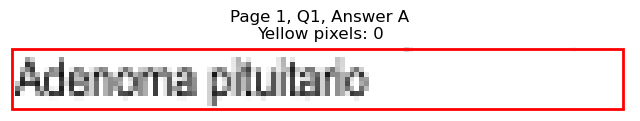

Page 1, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=152.1, y1=121.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 346
Page 1, Q1, B: Yellow percentage: 0.0%


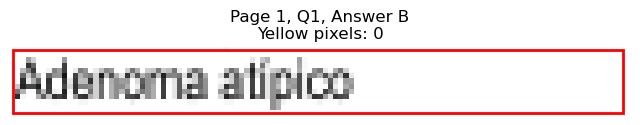

Page 1, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=216.7, y1=133.3
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 674
Page 1, Q1, C: Yellow percentage: 0.0%


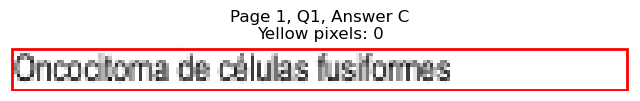

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=415.6, y1=109.2
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 396
Page 1, Q1, D: Yellow percentage: 0.0%


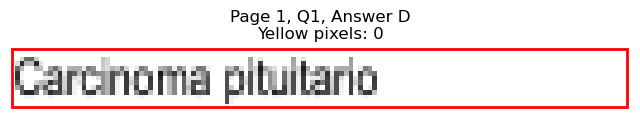

Page 1, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=394.2, y1=121.3
Page 1, Q1, E: Yellow pixels: 1067
Page 1, Q1, E: Total non-white pixels: 1417
Page 1, Q1, E: Yellow percentage: 75.3%


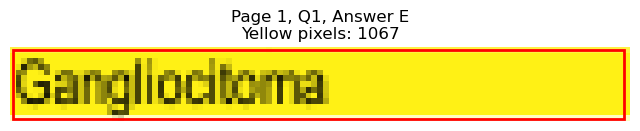


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=166.8, y1=181.5
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 404
Page 1, Q2, A: Yellow percentage: 0.0%


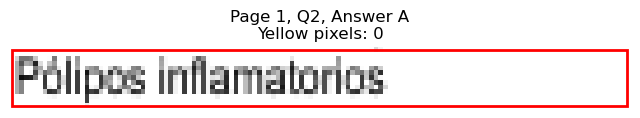

Page 1, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=209.0, y1=193.5
Page 1, Q2, B: Yellow pixels: 175
Page 1, Q2, B: Total non-white pixels: 783
Page 1, Q2, B: Yellow percentage: 22.3%


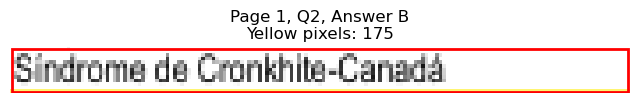

Page 1, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=142.9, y1=205.5
Page 1, Q2, C: Yellow pixels: 1143
Page 1, Q2, C: Total non-white pixels: 1417
Page 1, Q2, C: Yellow percentage: 80.7%


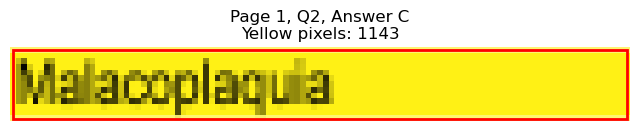

Page 1, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=422.4, y1=181.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 400
Page 1, Q2, D: Yellow percentage: 0.0%


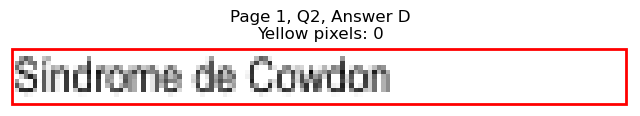

Page 1, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=443.0, y1=193.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 532
Page 1, Q2, E: Yellow percentage: 0.0%


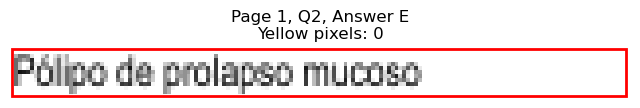


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=121.3, y1=253.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 191
Page 1, Q3, A: Yellow percentage: 0.0%


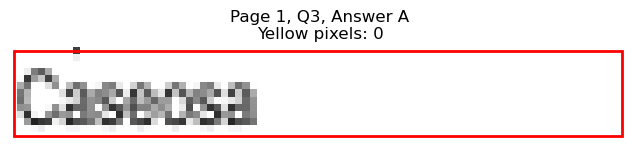

Page 1, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=110.8, y1=265.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 129
Page 1, Q3, B: Yellow percentage: 0.0%


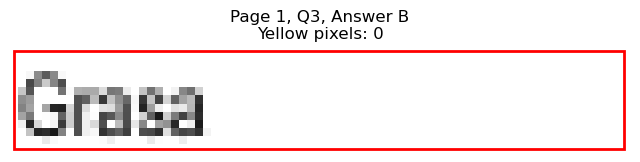

Page 1, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=133.3, y1=277.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 251
Page 1, Q3, C: Yellow percentage: 0.0%


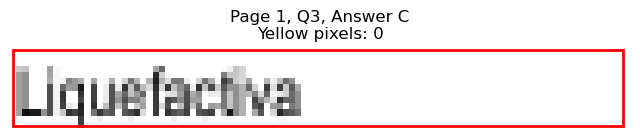

Page 1, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=384.6, y1=253.8
Page 1, Q3, D: Yellow pixels: 977
Page 1, Q3, D: Total non-white pixels: 1287
Page 1, Q3, D: Yellow percentage: 75.9%


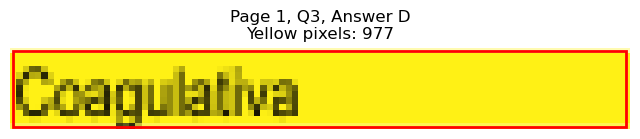

Page 1, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=371.1, y1=265.8
Page 1, Q3, E: Yellow pixels: 82
Page 1, Q3, E: Total non-white pixels: 251
Page 1, Q3, E: Yellow percentage: 32.7%


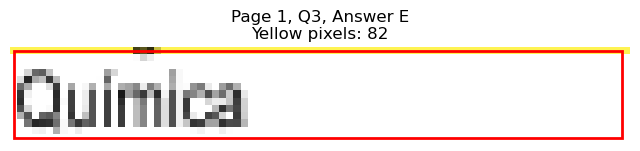


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=171.6, y1=314.0
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 450
Page 1, Q4, A: Yellow percentage: 0.0%


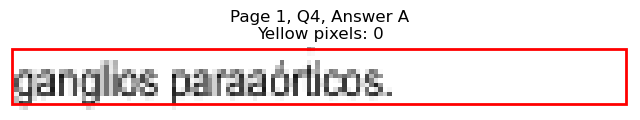

Page 1, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=118.0, y1=326.0
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 154
Page 1, Q4, B: Yellow percentage: 0.0%


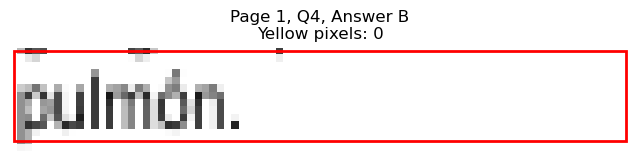

Page 1, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=113.7, y1=338.2
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 143
Page 1, Q4, C: Yellow percentage: 0.0%


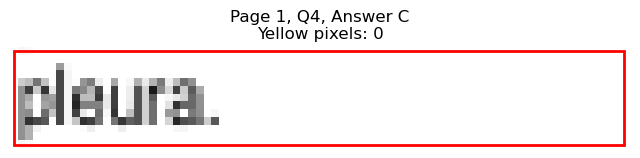

Page 1, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=370.6, y1=314.0
Page 1, Q4, D: Yellow pixels: 85
Page 1, Q4, D: Total non-white pixels: 323
Page 1, Q4, D: Yellow percentage: 26.3%


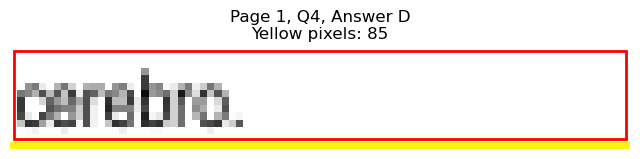

Page 1, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=420.0, y1=326.0
Page 1, Q4, E: Yellow pixels: 1261
Page 1, Q4, E: Total non-white pixels: 1876
Page 1, Q4, E: Yellow percentage: 67.2%


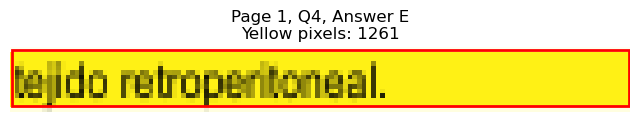


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=374.2, x1=111.7, y1=386.3
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 134
Page 1, Q5, A: Yellow percentage: 0.0%


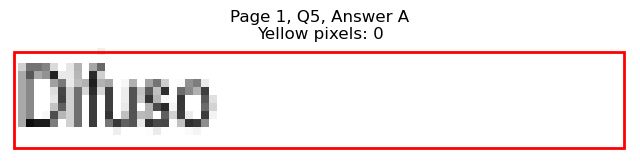

Page 1, Q5 - B: Detected box: x0=85.0, y0=386.3, x1=121.8, y1=398.4
Page 1, Q5, B: Yellow pixels: 915
Page 1, Q5, B: Total non-white pixels: 1144
Page 1, Q5, B: Yellow percentage: 80.0%


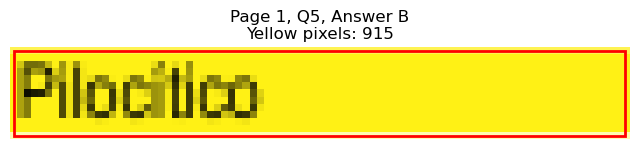

Page 1, Q5 - C: Detected box: x0=85.0, y0=398.3, x1=129.5, y1=410.4
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 332
Page 1, Q5, C: Yellow percentage: 0.0%


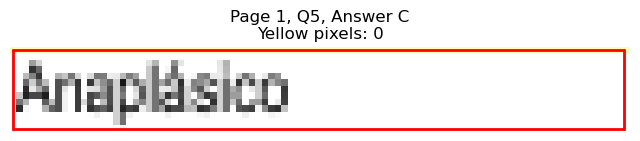

Page 1, Q5 - D: Detected box: x0=336.7, y0=374.2, x1=365.4, y1=386.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 147
Page 1, Q5, D: Yellow percentage: 0.0%


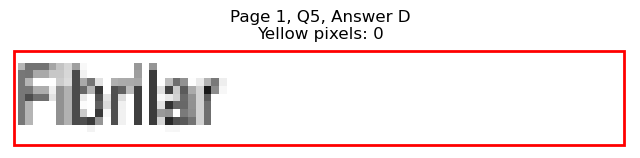

Page 1, Q5 - E: Detected box: x0=336.7, y0=386.3, x1=391.3, y1=398.4
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 274
Page 1, Q5, E: Yellow percentage: 0.0%


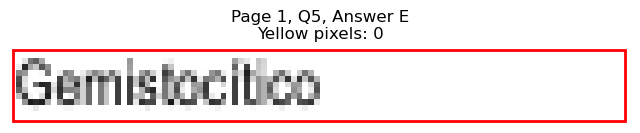


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=434.4, x1=104.5, y1=446.5
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 95
Page 1, Q6, A: Yellow percentage: 0.0%


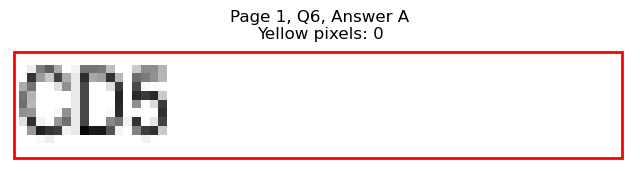

Page 1, Q6 - B: Detected box: x0=85.0, y0=446.6, x1=109.3, y1=458.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 126
Page 1, Q6, B: Yellow percentage: 0.0%


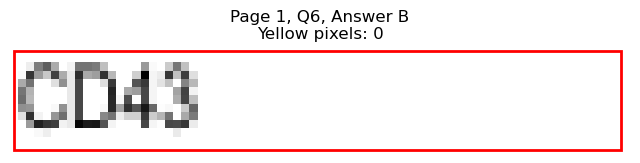

Page 1, Q6 - C: Detected box: x0=85.0, y0=458.6, x1=109.3, y1=470.7
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 123
Page 1, Q6, C: Yellow percentage: 0.0%


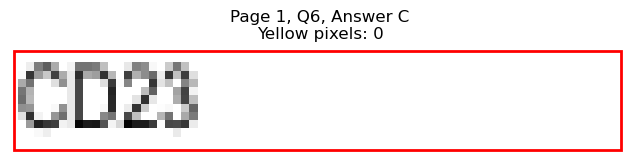

Page 1, Q6 - D: Detected box: x0=336.7, y0=434.4, x1=354.4, y1=446.5
Page 1, Q6, D: Yellow pixels: 838
Page 1, Q6, D: Total non-white pixels: 897
Page 1, Q6, D: Yellow percentage: 93.4%


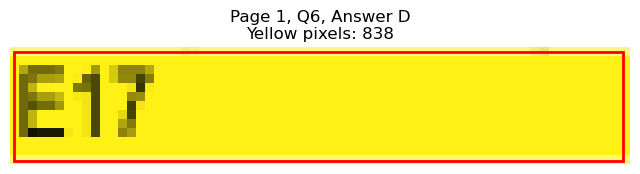

Page 1, Q6 - E: Detected box: x0=336.7, y0=446.6, x1=361.0, y1=458.7
Page 1, Q6, E: Yellow pixels: 76
Page 1, Q6, E: Total non-white pixels: 196
Page 1, Q6, E: Yellow percentage: 38.8%


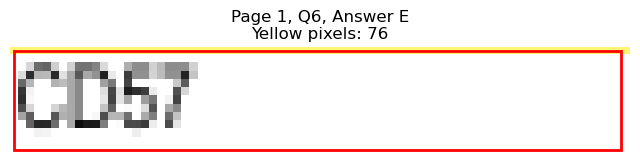


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=494.7, x1=121.3, y1=506.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 165
Page 1, Q7, A: Yellow percentage: 0.0%


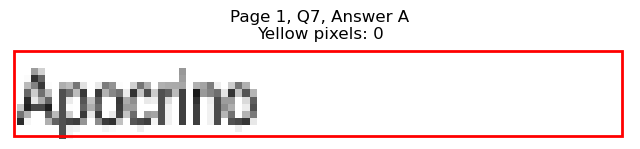

Page 1, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=148.7, y1=518.9
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 443
Page 1, Q7, B: Yellow percentage: 0.0%


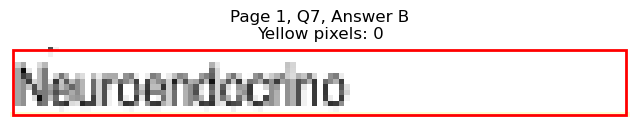

Page 1, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=133.3, y1=530.9
Page 1, Q7, C: Yellow pixels: 965
Page 1, Q7, C: Total non-white pixels: 1300
Page 1, Q7, C: Yellow percentage: 74.2%


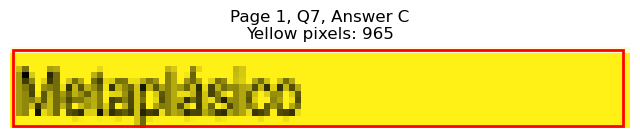

Page 1, Q7 - D: Detected box: x0=336.7, y0=494.7, x1=370.3, y1=506.8
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 177
Page 1, Q7, D: Yellow percentage: 0.0%


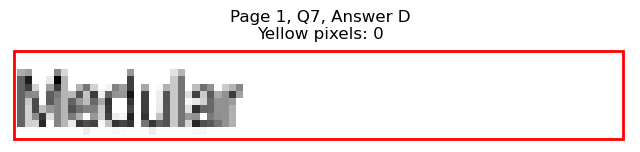

Page 1, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=359.6, y1=518.9
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 122
Page 1, Q7, E: Yellow percentage: 0.0%


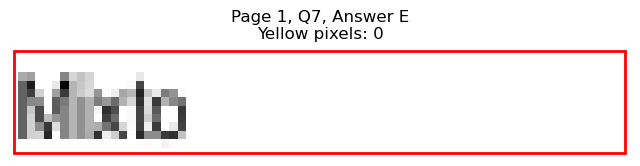


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=554.9, x1=152.9, y1=567.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 353
Page 1, Q8, A: Yellow percentage: 0.0%


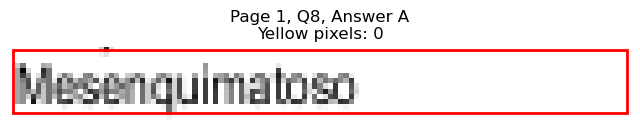

Page 1, Q8 - B: Detected box: x0=85.0, y0=567.1, x1=143.9, y1=579.2
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 285
Page 1, Q8, B: Yellow percentage: 0.0%


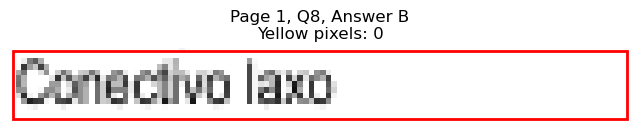

Page 1, Q8 - C: Detected box: x0=85.0, y0=579.1, x1=121.3, y1=591.2
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 188
Page 1, Q8, C: Yellow percentage: 0.0%


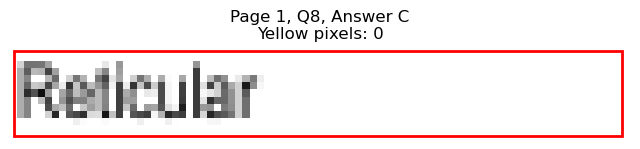

Page 1, Q8 - D: Detected box: x0=336.7, y0=554.9, x1=369.2, y1=567.0
Page 1, Q8, D: Yellow pixels: 879
Page 1, Q8, D: Total non-white pixels: 1176
Page 1, Q8, D: Yellow percentage: 74.7%


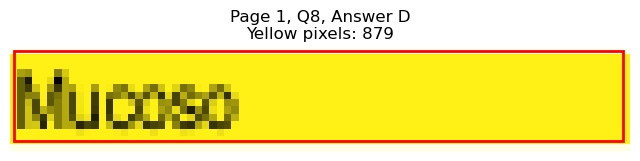

Page 1, Q8 - E: Detected box: x0=336.7, y0=567.1, x1=369.2, y1=579.2
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 254
Page 1, Q8, E: Yellow percentage: 0.0%


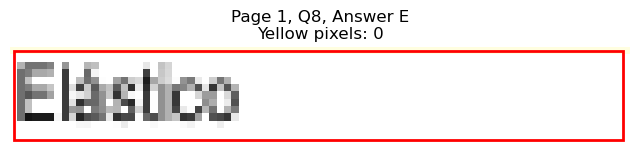


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=615.2, x1=122.3, y1=627.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 170
Page 1, Q9, A: Yellow percentage: 0.0%


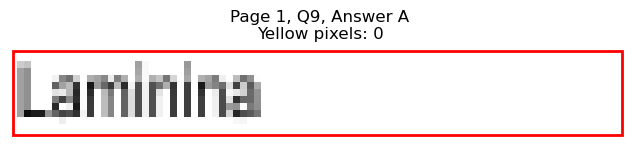

Page 1, Q9 - B: Detected box: x0=85.0, y0=627.3, x1=134.8, y1=639.4
Page 1, Q9, B: Yellow pixels: 993
Page 1, Q9, B: Total non-white pixels: 1313
Page 1, Q9, B: Yellow percentage: 75.6%


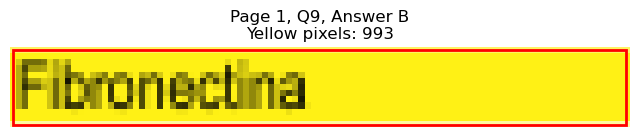

Page 1, Q9 - C: Detected box: x0=85.0, y0=639.3, x1=118.0, y1=651.4
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 271
Page 1, Q9, C: Yellow percentage: 0.0%


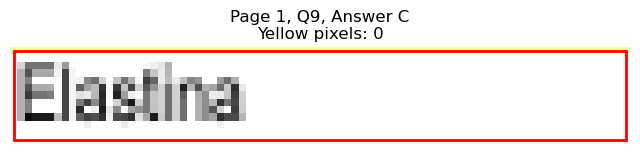

Page 1, Q9 - D: Detected box: x0=336.7, y0=615.2, x1=369.2, y1=627.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 171
Page 1, Q9, D: Yellow percentage: 0.0%


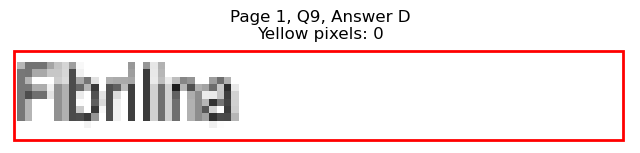

Page 1, Q9 - E: Detected box: x0=336.7, y0=627.3, x1=374.5, y1=639.4
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 195
Page 1, Q9, E: Yellow percentage: 0.0%


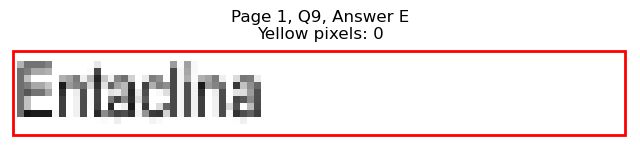


Page 1, Q9 - Selected Answer: B (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=85.0, y0=699.5, x1=182.2, y1=711.7
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 519
Page 1, Q10, A: Yellow percentage: 0.0%


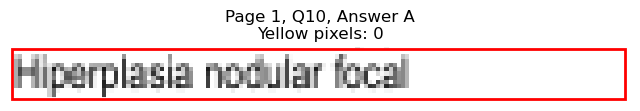

Page 1, Q10 - B: Detected box: x0=85.0, y0=711.7, x1=183.1, y1=723.8
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 511
Page 1, Q10, B: Yellow percentage: 0.0%


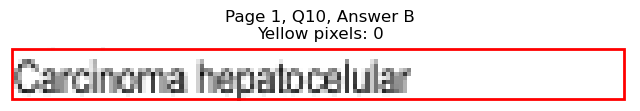

Page 1, Q10 - C: Detected box: x0=85.0, y0=723.7, x1=194.3, y1=735.8
Page 1, Q10, C: Yellow pixels: 0
Page 1, Q10, C: Total non-white pixels: 566
Page 1, Q10, C: Yellow percentage: 0.0%


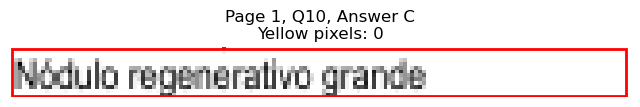

Page 1, Q10 - D: Detected box: x0=336.7, y0=699.5, x1=430.0, y1=711.7
Page 1, Q10, D: Yellow pixels: 1505
Page 1, Q10, D: Total non-white pixels: 1885
Page 1, Q10, D: Yellow percentage: 79.8%


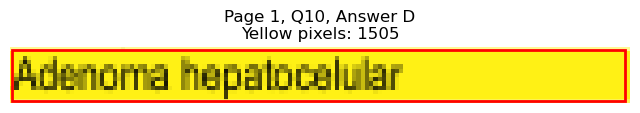

Page 1, Q10 - E: Detected box: x0=336.7, y0=711.7, x1=463.5, y1=723.8
Page 1, Q10, E: Yellow pixels: 178
Page 1, Q10, E: Total non-white pixels: 857
Page 1, Q10, E: Yellow percentage: 20.8%


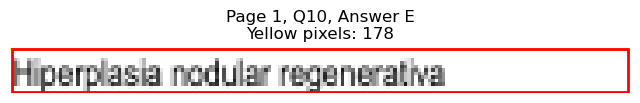


Page 1, Q10 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=284.1, y1=133.3
Page 2, Q1, A: Yellow pixels: 2233
Page 2, Q1, A: Total non-white pixels: 3263
Page 2, Q1, A: Yellow percentage: 68.4%


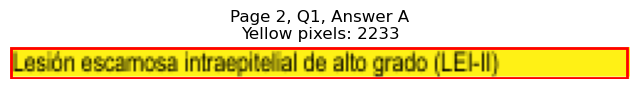

Page 2, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=272.2, y1=145.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 1191
Page 2, Q1, B: Yellow percentage: 0.0%


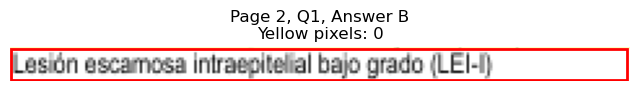

Page 2, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=286.5, y1=157.4
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 1013
Page 2, Q1, C: Yellow percentage: 0.0%


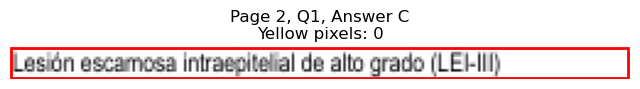

Page 2, Q1 - D: Detected box: x0=85.0, y0=157.3, x1=339.7, y1=169.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 1307
Page 2, Q1, D: Yellow percentage: 0.0%


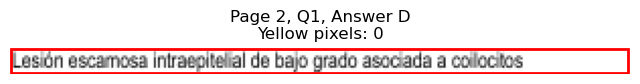

Page 2, Q1 - E: Detected box: x0=85.0, y0=169.4, x1=222.4, y1=181.5
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 695
Page 2, Q1, E: Yellow percentage: 0.0%


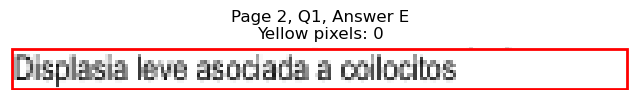


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=163.0, y1=217.7
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 385
Page 2, Q2, A: Yellow percentage: 0.0%


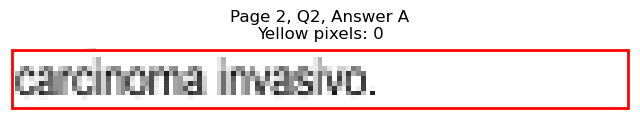

Page 2, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=178.3, y1=229.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 459
Page 2, Q2, B: Yellow percentage: 0.0%


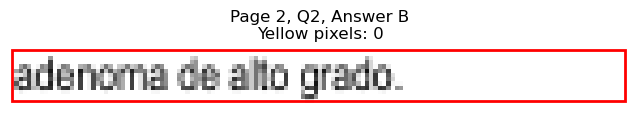

Page 2, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=214.3, y1=241.8
Page 2, Q2, C: Yellow pixels: 1677
Page 2, Q2, C: Total non-white pixels: 2353
Page 2, Q2, C: Yellow percentage: 71.3%


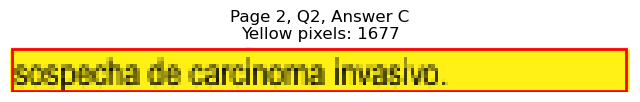

Page 2, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=430.5, y1=217.7
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 452
Page 2, Q2, D: Yellow percentage: 0.0%


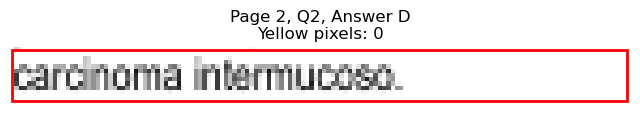

Page 2, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=427.6, y1=229.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 432
Page 2, Q2, E: Yellow percentage: 0.0%


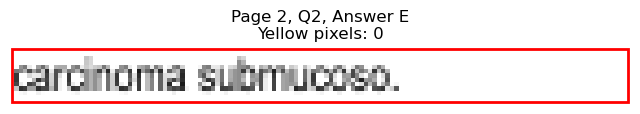


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=149.7, y1=277.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 439
Page 2, Q3, A: Yellow percentage: 0.0%


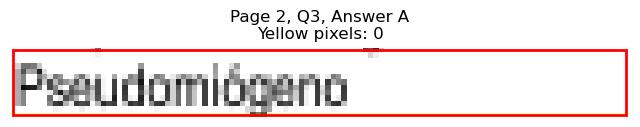

Page 2, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=135.7, y1=289.9
Page 2, Q3, B: Yellow pixels: 1022
Page 2, Q3, B: Total non-white pixels: 1326
Page 2, Q3, B: Yellow percentage: 77.1%


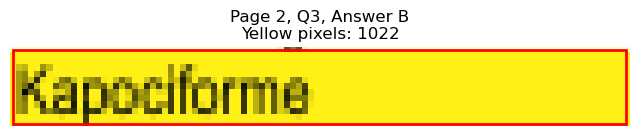

Page 2, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=131.4, y1=302.0
Page 2, Q3, C: Yellow pixels: 97
Page 2, Q3, C: Total non-white pixels: 343
Page 2, Q3, C: Yellow percentage: 28.3%


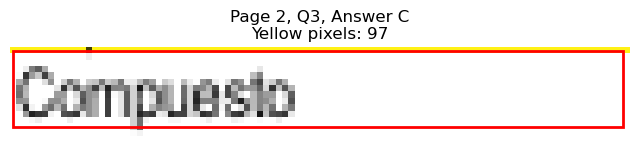

Page 2, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=376.9, y1=277.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 230
Page 2, Q3, D: Yellow percentage: 0.0%


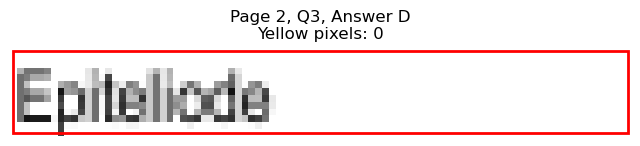

Page 2, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=379.3, y1=289.9
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 236
Page 2, Q3, E: Yellow percentage: 0.0%


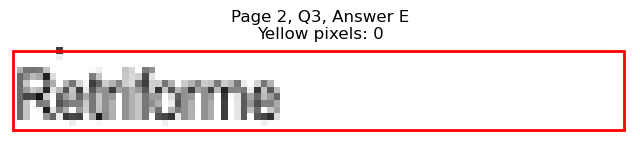


Page 2, Q3 - Selected Answer: B (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=141.5, y1=338.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 296
Page 2, Q4, A: Yellow percentage: 0.0%


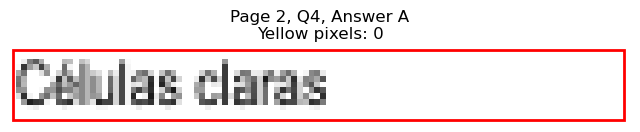

Page 2, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=114.1, y1=350.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 156
Page 2, Q4, B: Yellow percentage: 0.0%


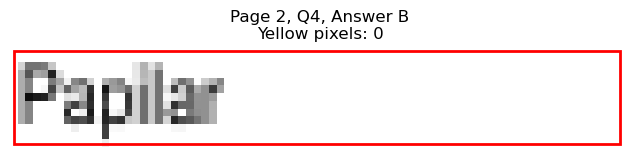

Page 2, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=118.5, y1=362.3
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 177
Page 2, Q4, C: Yellow percentage: 0.0%


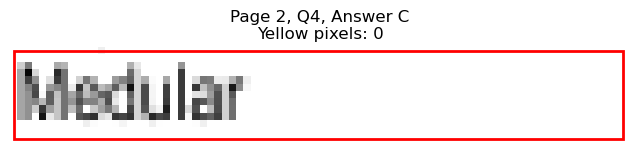

Page 2, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=407.5, y1=338.2
Page 2, Q4, D: Yellow pixels: 122
Page 2, Q4, D: Total non-white pixels: 452
Page 2, Q4, D: Yellow percentage: 27.0%


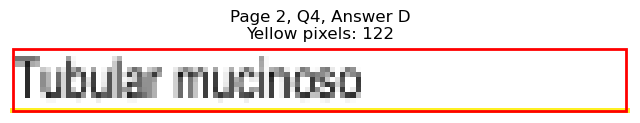

Page 2, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=381.7, y1=350.2
Page 2, Q4, E: Yellow pixels: 978
Page 2, Q4, E: Total non-white pixels: 1248
Page 2, Q4, E: Yellow percentage: 78.4%


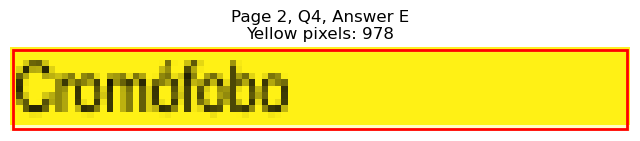


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=166.3, y1=398.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 449
Page 2, Q5, A: Yellow percentage: 0.0%


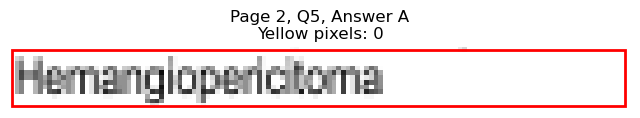

Page 2, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=119.9, y1=410.4
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 186
Page 2, Q5, B: Yellow percentage: 0.0%


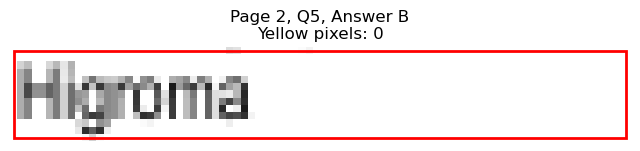

Page 2, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=141.0, y1=422.5
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 306
Page 2, Q5, C: Yellow percentage: 0.0%


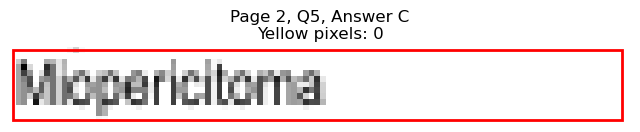

Page 2, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=370.6, y1=398.4
Page 2, Q5, D: Yellow pixels: 884
Page 2, Q5, D: Total non-white pixels: 1105
Page 2, Q5, D: Yellow percentage: 80.0%


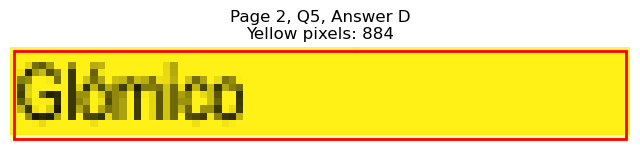

Page 2, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=381.7, y1=410.4
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 333
Page 2, Q5, E: Yellow percentage: 0.0%


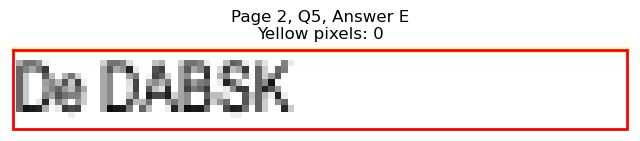


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=162.5, y1=470.7
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 415
Page 2, Q6, A: Yellow percentage: 0.0%


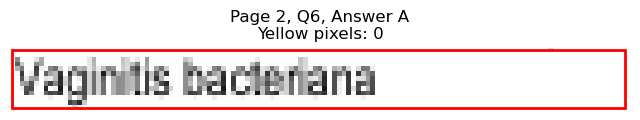

Page 2, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=138.1, y1=482.8
Page 2, Q6, B: Yellow pixels: 1
Page 2, Q6, B: Total non-white pixels: 390
Page 2, Q6, B: Yellow percentage: 0.3%


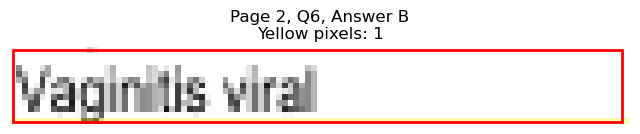

Page 2, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=167.3, y1=494.8
Page 2, Q6, C: Yellow pixels: 1264
Page 2, Q6, C: Total non-white pixels: 1742
Page 2, Q6, C: Yellow percentage: 72.6%


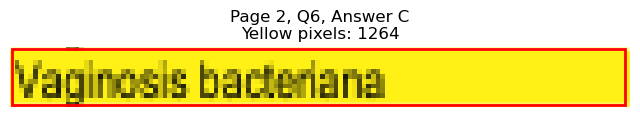

Page 2, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=403.6, y1=470.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 366
Page 2, Q6, D: Yellow percentage: 0.0%


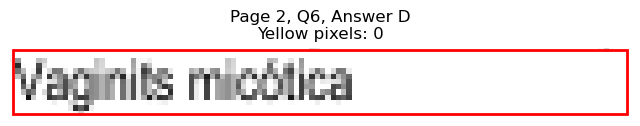

Page 2, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=437.7, y1=482.8
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 522
Page 2, Q6, E: Yellow percentage: 0.0%


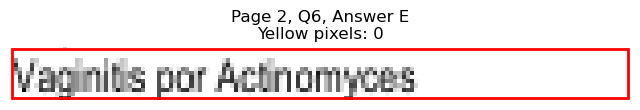


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=110.8, y1=530.9
Page 2, Q7, A: Yellow pixels: 825
Page 2, Q7, A: Total non-white pixels: 1001
Page 2, Q7, A: Yellow percentage: 82.4%


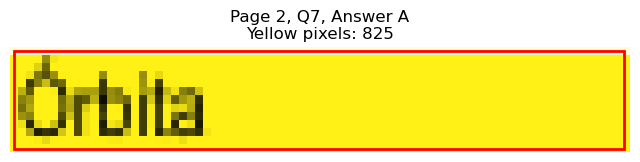

Page 2, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=133.8, y1=543.0
Page 2, Q7, B: Yellow pixels: 100
Page 2, Q7, B: Total non-white pixels: 374
Page 2, Q7, B: Yellow percentage: 26.7%


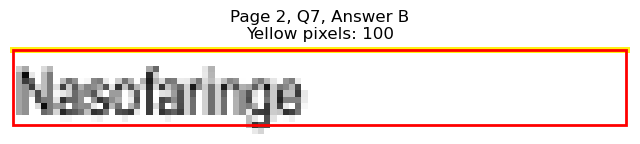

Page 2, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=131.9, y1=555.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 245
Page 2, Q7, C: Yellow percentage: 0.0%


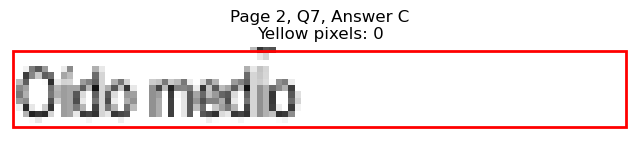

Page 2, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=399.9, y1=530.9
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 326
Page 2, Q7, D: Yellow percentage: 0.0%


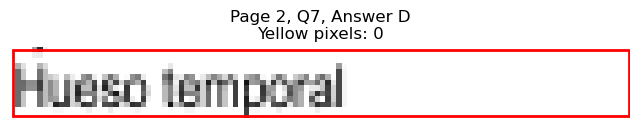

Page 2, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=388.9, y1=543.0
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 253
Page 2, Q7, E: Yellow percentage: 0.0%


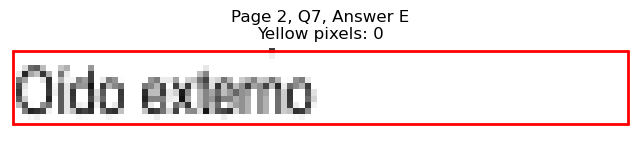


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=127.6, y1=603.3
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 201
Page 2, Q8, A: Yellow percentage: 0.0%


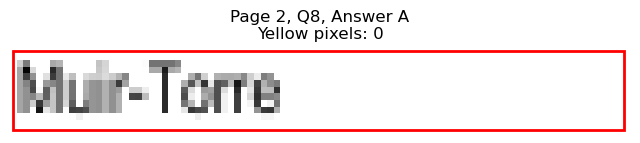

Page 2, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=110.3, y1=615.3
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 150
Page 2, Q8, B: Yellow percentage: 0.0%


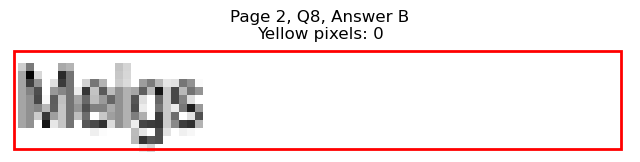

Page 2, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=115.1, y1=627.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 175
Page 2, Q8, C: Yellow percentage: 0.0%


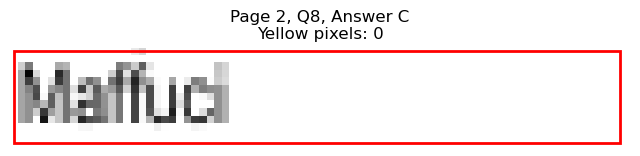

Page 2, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=365.8, y1=603.3
Page 2, Q8, D: Yellow pixels: 841
Page 2, Q8, D: Total non-white pixels: 1040
Page 2, Q8, D: Yellow percentage: 80.9%


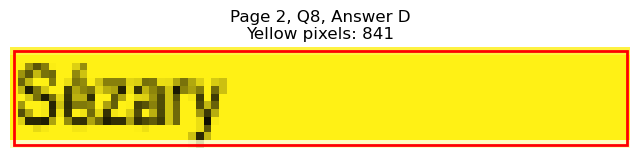

Page 2, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=363.4, y1=615.3
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 197
Page 2, Q8, E: Yellow percentage: 0.0%


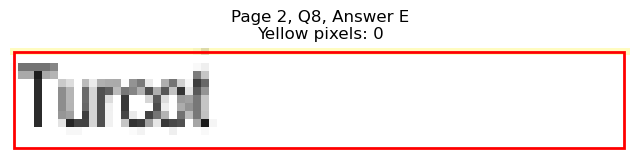


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=161.5, y1=699.7
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 406
Page 2, Q9, A: Yellow percentage: 0.0%


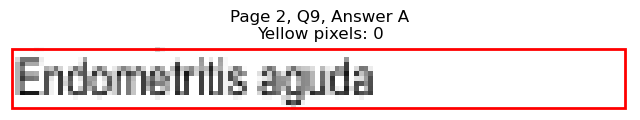

Page 2, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=193.3, y1=711.7
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 562
Page 2, Q9, B: Yellow percentage: 0.0%


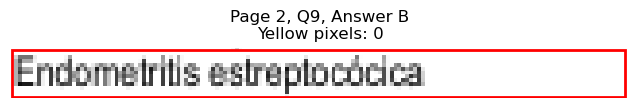

Page 2, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=180.7, y1=723.8
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 505
Page 2, Q9, C: Yellow percentage: 0.0%


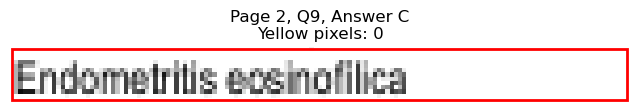

Page 2, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=491.7, y1=699.7
Page 2, Q9, D: Yellow pixels: 189
Page 2, Q9, D: Total non-white pixels: 972
Page 2, Q9, D: Yellow percentage: 19.4%


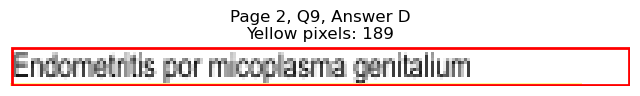

Page 2, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=417.1, y1=711.7
Page 2, Q9, E: Yellow pixels: 1365
Page 2, Q9, E: Total non-white pixels: 1716
Page 2, Q9, E: Yellow percentage: 79.5%


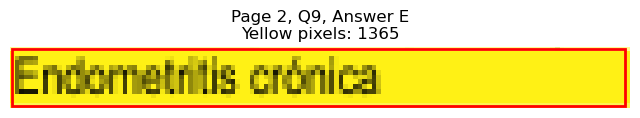


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=129.5, y1=133.3
Page 3, Q1, A: Yellow pixels: 96
Page 3, Q1, A: Total non-white pixels: 299
Page 3, Q1, A: Yellow percentage: 32.1%


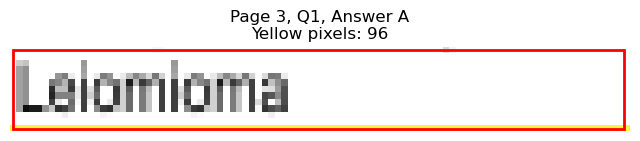

Page 3, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=208.0, y1=145.3
Page 3, Q1, B: Yellow pixels: 1601
Page 3, Q1, B: Total non-white pixels: 2275
Page 3, Q1, B: Yellow percentage: 70.4%


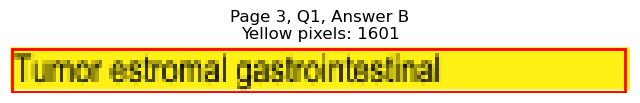

Page 3, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=144.4, y1=157.4
Page 3, Q1, C: Yellow pixels: 2
Page 3, Q1, C: Total non-white pixels: 409
Page 3, Q1, C: Yellow percentage: 0.5%


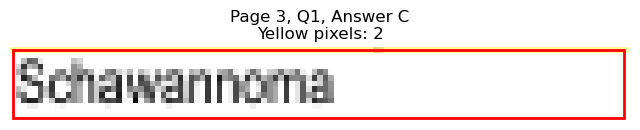

Page 3, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=390.3, y1=133.3
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 285
Page 3, Q1, D: Yellow percentage: 0.0%


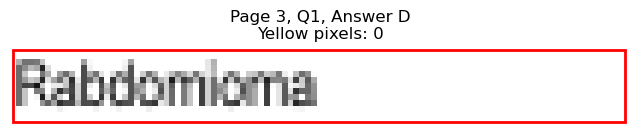

Page 3, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=388.4, y1=145.3
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 256
Page 3, Q1, E: Yellow percentage: 0.0%


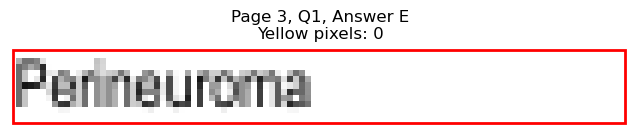


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=109.3, y1=193.5
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 119
Page 3, Q2, A: Yellow percentage: 0.0%


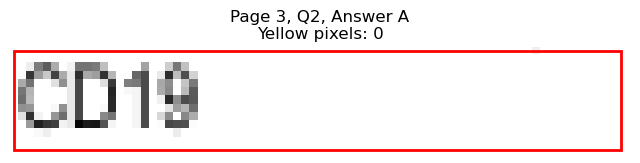

Page 3, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=109.3, y1=205.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 125
Page 3, Q2, B: Yellow percentage: 0.0%


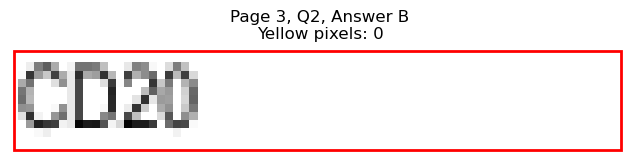

Page 3, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=109.3, y1=217.7
Page 3, Q2, C: Yellow pixels: 890
Page 3, Q2, C: Total non-white pixels: 988
Page 3, Q2, C: Yellow percentage: 90.1%


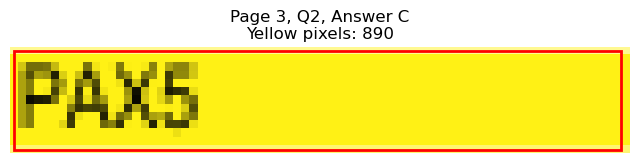

Page 3, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=359.6, y1=193.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 118
Page 3, Q2, D: Yellow percentage: 0.0%


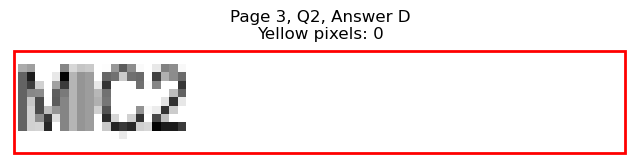

Page 3, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=356.2, y1=205.5
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 99
Page 3, Q2, E: Yellow percentage: 0.0%


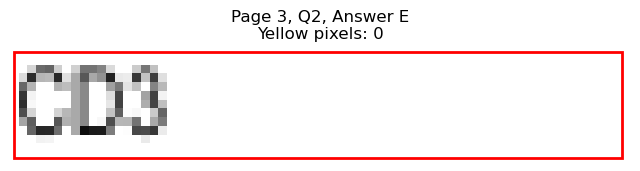


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=156.3, y1=277.9
Page 3, Q3, A: Yellow pixels: 1189
Page 3, Q3, A: Total non-white pixels: 1599
Page 3, Q3, A: Yellow percentage: 74.4%


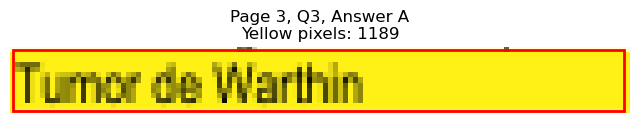

Page 3, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=197.6, y1=289.9
Page 3, Q3, B: Yellow pixels: 164
Page 3, Q3, B: Total non-white pixels: 734
Page 3, Q3, B: Yellow percentage: 22.3%


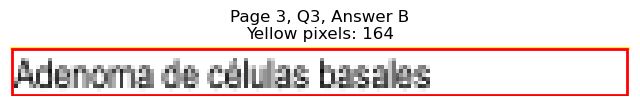

Page 3, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=198.9, y1=302.0
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 594
Page 3, Q3, C: Yellow percentage: 0.0%


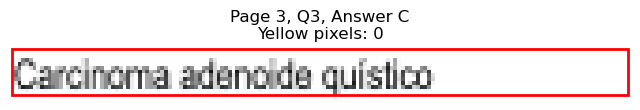

Page 3, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=426.3, y1=277.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 471
Page 3, Q3, D: Yellow percentage: 0.0%


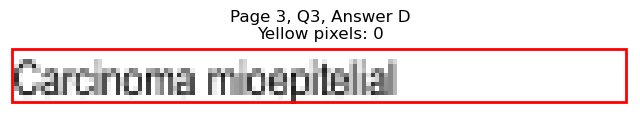

Page 3, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=451.5, y1=289.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 576
Page 3, Q3, E: Yellow percentage: 0.0%


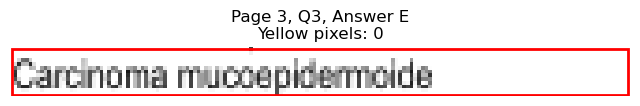


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=109.3, y1=338.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 126
Page 3, Q4, A: Yellow percentage: 0.0%


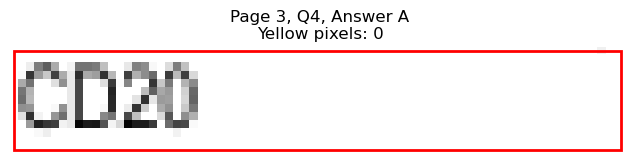

Page 3, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=109.3, y1=350.2
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 123
Page 3, Q4, B: Yellow percentage: 0.0%


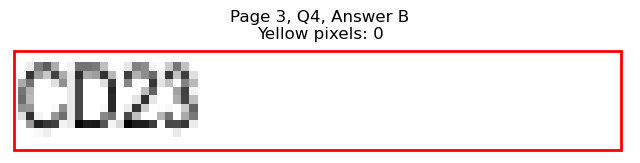

Page 3, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=104.5, y1=362.3
Page 3, Q4, C: Yellow pixels: 781
Page 3, Q4, C: Total non-white pixels: 923
Page 3, Q4, C: Yellow percentage: 84.6%


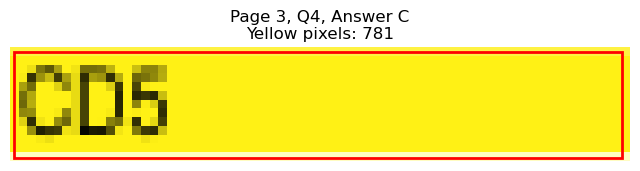

Page 3, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=361.0, y1=338.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 118
Page 3, Q4, D: Yellow percentage: 0.0%


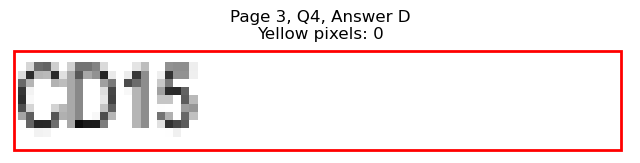

Page 3, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=361.0, y1=350.2
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 122
Page 3, Q4, E: Yellow percentage: 0.0%


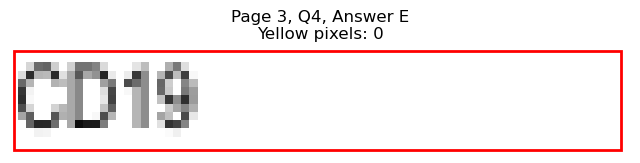


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=113.2, y1=398.4
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 149
Page 3, Q5, A: Yellow percentage: 0.0%


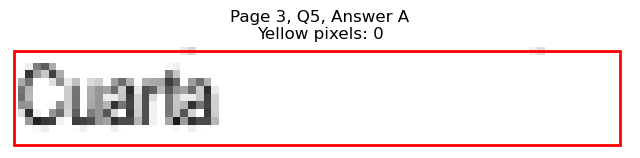

Page 3, Q5 - B: Detected box: x0=85.0, y0=398.3, x1=117.5, y1=410.4
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 156
Page 3, Q5, B: Yellow percentage: 0.0%


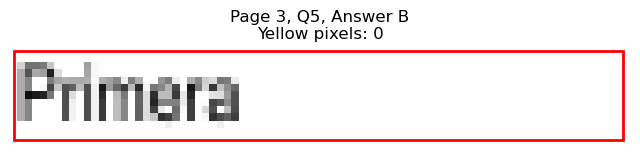

Page 3, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=121.8, y1=422.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 199
Page 3, Q5, C: Yellow percentage: 0.0%


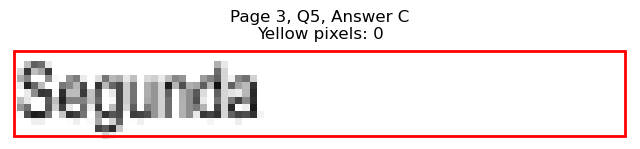

Page 3, Q5 - D: Detected box: x0=336.7, y0=386.3, x1=397.5, y1=398.4
Page 3, Q5, D: Yellow pixels: 112
Page 3, Q5, D: Total non-white pixels: 395
Page 3, Q5, D: Yellow percentage: 28.4%


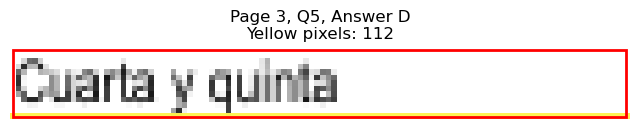

Page 3, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=401.7, y1=410.4
Page 3, Q5, E: Yellow pixels: 1288
Page 3, Q5, E: Total non-white pixels: 1508
Page 3, Q5, E: Yellow percentage: 85.4%


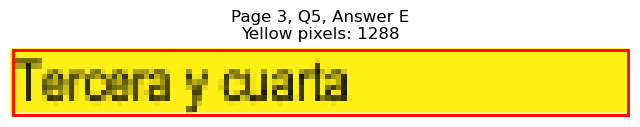


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=231.1, y1=458.7
Page 3, Q6, A: Yellow pixels: 198
Page 3, Q6, A: Total non-white pixels: 946
Page 3, Q6, A: Yellow percentage: 20.9%


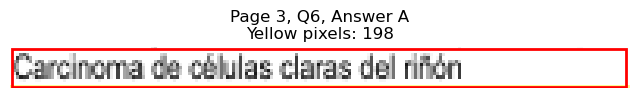

Page 3, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=127.6, y1=470.7
Page 3, Q6, B: Yellow pixels: 1031
Page 3, Q6, B: Total non-white pixels: 1222
Page 3, Q6, B: Yellow percentage: 84.4%


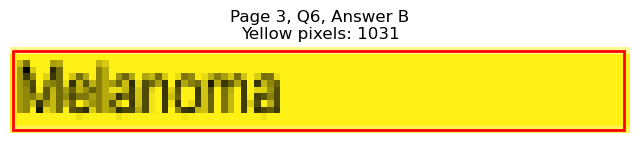

Page 3, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=206.6, y1=482.8
Page 3, Q6, C: Yellow pixels: 173
Page 3, Q6, C: Total non-white pixels: 803
Page 3, Q6, C: Yellow percentage: 21.5%


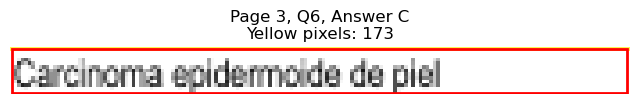

Page 3, Q6 - D: Detected box: x0=85.0, y0=482.7, x1=184.6, y1=494.8
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 520
Page 3, Q6, D: Yellow percentage: 0.0%


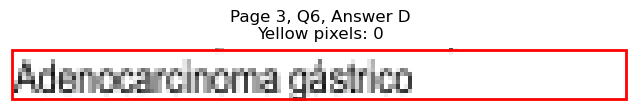

Page 3, Q6 - E: Detected box: x0=85.0, y0=494.7, x1=247.7, y1=506.8
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 800
Page 3, Q6, E: Yellow percentage: 0.0%


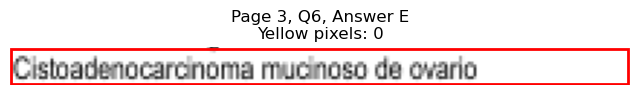


Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=70.8, y0=530.9, x1=79.0, y1=543.0
Page 3, Q7, A: Yellow pixels: 59
Page 3, Q7, A: Total non-white pixels: 179
Page 3, Q7, A: Yellow percentage: 33.0%


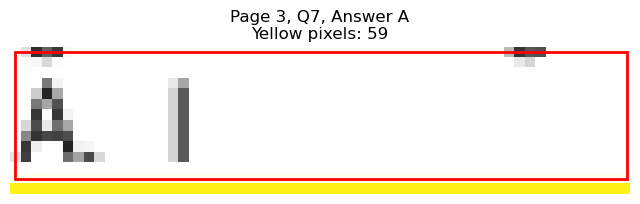

Page 3, Q7 - B: Detected box: x0=85.0, y0=542.9, x1=126.6, y1=555.0
Page 3, Q7, B: Yellow pixels: 950
Page 3, Q7, B: Total non-white pixels: 1209
Page 3, Q7, B: Yellow percentage: 78.6%


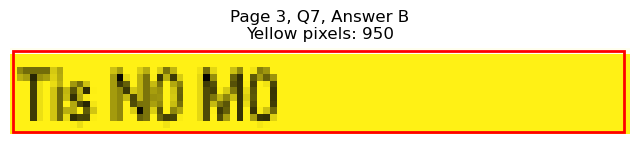

Page 3, Q7 - C: Detected box: x0=85.0, y0=554.9, x1=125.2, y1=567.0
Page 3, Q7, C: Yellow pixels: 92
Page 3, Q7, C: Total non-white pixels: 284
Page 3, Q7, C: Yellow percentage: 32.4%


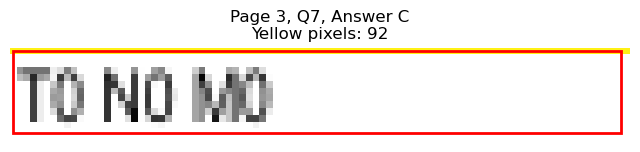

Page 3, Q7 - D: Detected box: x0=336.7, y0=530.9, x1=376.9, y1=543.0
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 170
Page 3, Q7, D: Yellow percentage: 0.0%


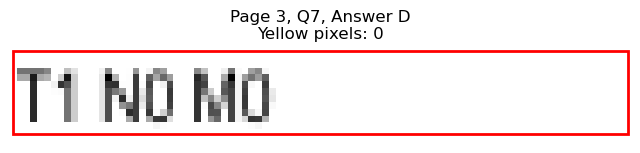

Page 3, Q7 - E: Detected box: x0=322.5, y0=542.9, x1=330.7, y1=555.0
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 62
Page 3, Q7, E: Yellow percentage: 0.0%


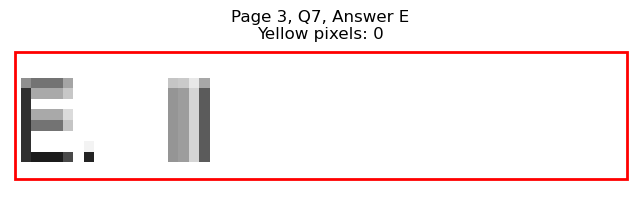


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=591.2, x1=153.9, y1=603.3
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 356
Page 3, Q8, A: Yellow percentage: 0.0%


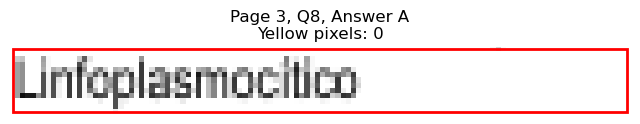

Page 3, Q8 - B: Detected box: x0=85.0, y0=603.2, x1=111.7, y1=615.3
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 142
Page 3, Q8, B: Yellow percentage: 0.0%


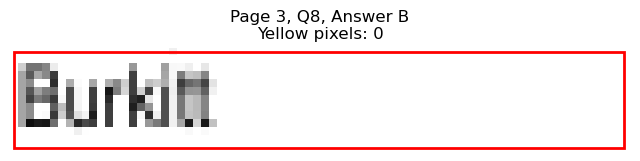

Page 3, Q8 - C: Detected box: x0=85.0, y0=615.2, x1=156.3, y1=627.3
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 380
Page 3, Q8, C: Yellow percentage: 0.0%


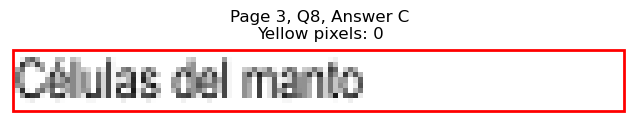

Page 3, Q8 - D: Detected box: x0=336.7, y0=591.2, x1=459.2, y1=603.3
Page 3, Q8, D: Yellow pixels: 174
Page 3, Q8, D: Total non-white pixels: 796
Page 3, Q8, D: Yellow percentage: 21.9%


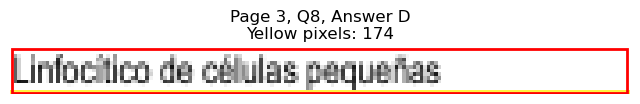

Page 3, Q8 - E: Detected box: x0=336.7, y0=603.2, x1=371.6, y1=615.3
Page 3, Q8, E: Yellow pixels: 896
Page 3, Q8, E: Total non-white pixels: 1118
Page 3, Q8, E: Yellow percentage: 80.1%


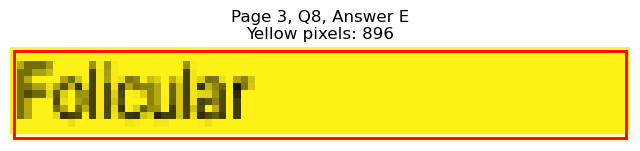


Page 3, Q8 - Selected Answer: E (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=124.2, y1=675.5
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 203
Page 3, Q9, A: Yellow percentage: 0.0%


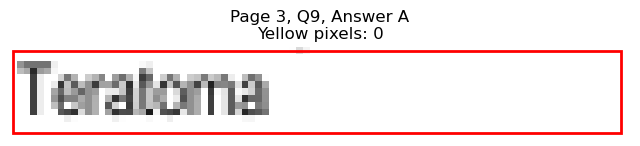

Page 3, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=145.8, y1=687.5
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 319
Page 3, Q9, B: Yellow percentage: 0.0%


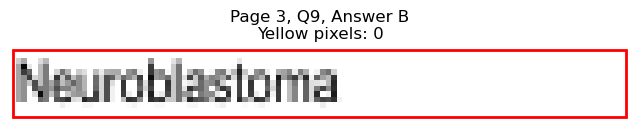

Page 3, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=139.1, y1=699.7
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 285
Page 3, Q9, C: Yellow percentage: 0.0%


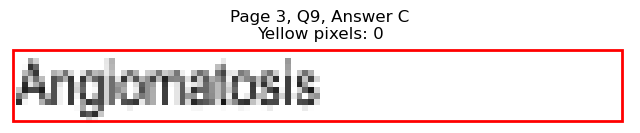

Page 3, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=392.7, y1=675.5
Page 3, Q9, D: Yellow pixels: 1164
Page 3, Q9, D: Total non-white pixels: 1391
Page 3, Q9, D: Yellow percentage: 83.7%


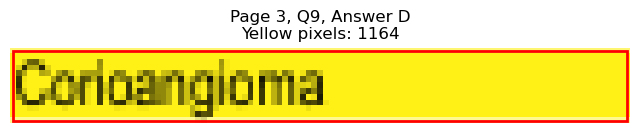

Page 3, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=386.0, y1=687.5
Page 3, Q9, E: Yellow pixels: 100
Page 3, Q9, E: Total non-white pixels: 347
Page 3, Q9, E: Yellow percentage: 28.8%


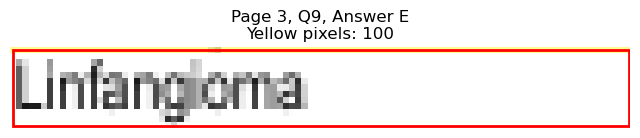


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=116.1, y1=735.8
Page 3, Q10, A: Yellow pixels: 871
Page 3, Q10, A: Total non-white pixels: 1079
Page 3, Q10, A: Yellow percentage: 80.7%


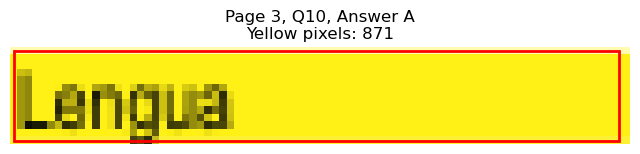

Page 3, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=140.1, y1=747.9
Page 3, Q10, B: Yellow pixels: 103
Page 3, Q10, B: Total non-white pixels: 398
Page 3, Q10, B: Yellow percentage: 25.9%


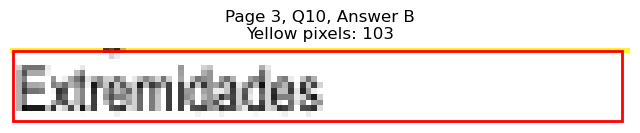

Page 3, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=146.3, y1=759.9
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 318
Page 3, Q10, C: Yellow percentage: 0.0%


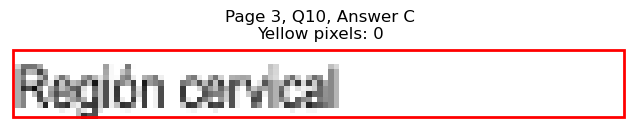

Page 3, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=412.8, y1=735.8
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 377
Page 3, Q10, D: Yellow percentage: 0.0%


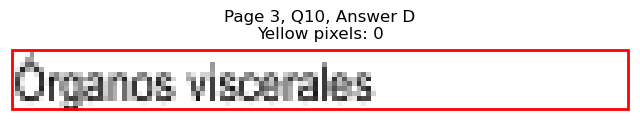

Page 3, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=363.9, y1=747.9
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 142
Page 3, Q10, E: Yellow percentage: 0.0%


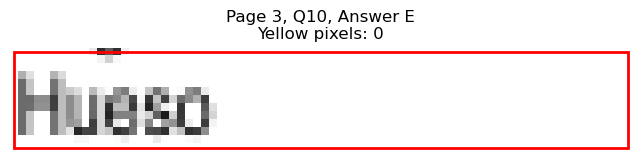


Page 3, Q10 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=146.3, y1=109.2
Page 4, Q1, A: Yellow pixels: 1098
Page 4, Q1, A: Total non-white pixels: 1469
Page 4, Q1, A: Yellow percentage: 74.7%


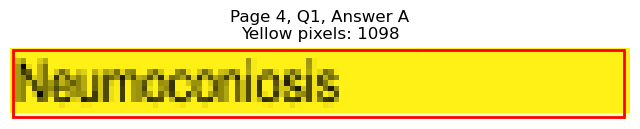

Page 4, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=118.5, y1=121.3
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 268
Page 4, Q1, B: Yellow percentage: 0.0%


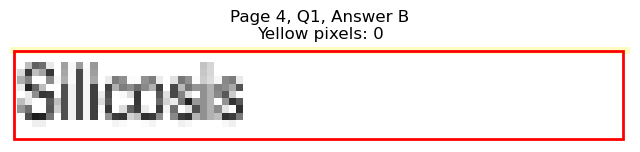

Page 4, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=129.0, y1=133.3
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 230
Page 4, Q1, C: Yellow percentage: 0.0%


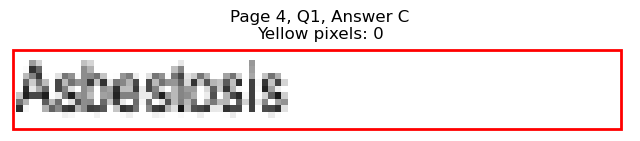

Page 4, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=373.5, y1=109.2
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 211
Page 4, Q1, D: Yellow percentage: 0.0%


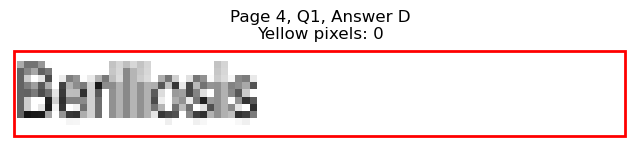

Page 4, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=370.6, y1=121.3
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 165
Page 4, Q1, E: Yellow percentage: 0.0%


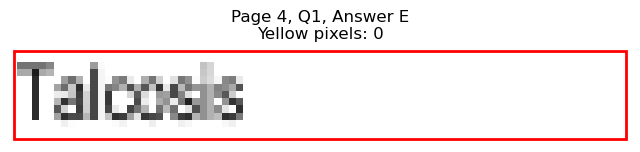


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=130.9, y1=169.4
Page 4, Q2, A: Yellow pixels: 1078
Page 4, Q2, A: Total non-white pixels: 1261
Page 4, Q2, A: Yellow percentage: 85.5%


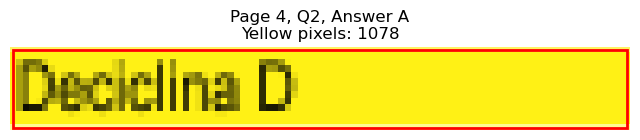

Page 4, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=101.8, y1=181.5
Page 4, Q2, B: Yellow pixels: 68
Page 4, Q2, B: Total non-white pixels: 158
Page 4, Q2, B: Yellow percentage: 43.0%


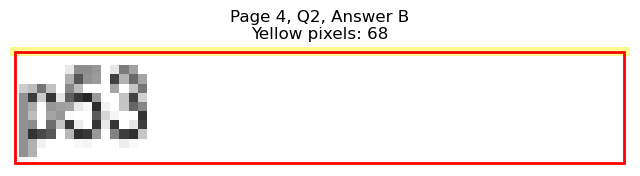

Page 4, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=129.5, y1=193.5
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 228
Page 4, Q2, C: Yellow percentage: 0.0%


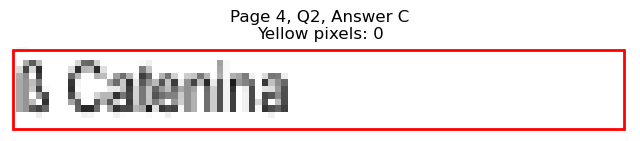

Page 4, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=353.5, y1=169.4
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 77
Page 4, Q2, D: Yellow percentage: 0.0%


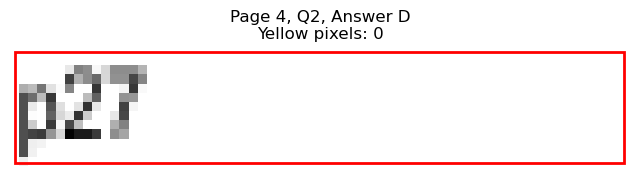

Page 4, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=387.4, y1=181.5
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 261
Page 4, Q2, E: Yellow percentage: 0.0%


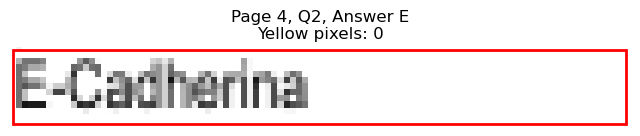


Page 4, Q2 - Selected Answer: A (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=265.5, y1=229.7
Page 4, Q3, A: Yellow pixels: 1751
Page 4, Q3, A: Total non-white pixels: 2483
Page 4, Q3, A: Yellow percentage: 70.5%


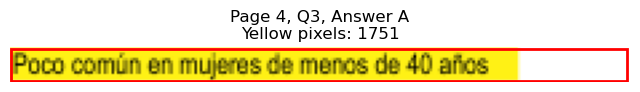

Page 4, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=189.9, y1=241.8
Page 4, Q3, B: Yellow pixels: 156
Page 4, Q3, B: Total non-white pixels: 683
Page 4, Q3, B: Yellow percentage: 22.8%


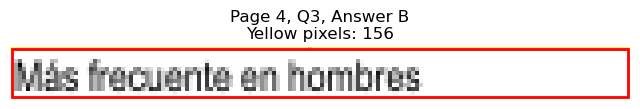

Page 4, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=275.2, y1=253.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 950
Page 4, Q3, C: Yellow percentage: 0.0%


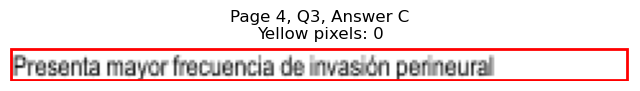

Page 4, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=454.4, y1=229.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 598
Page 4, Q3, D: Yellow percentage: 0.0%


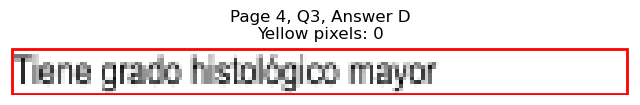

Page 4, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=501.3, y1=241.8
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 855
Page 4, Q3, E: Yellow percentage: 0.0%


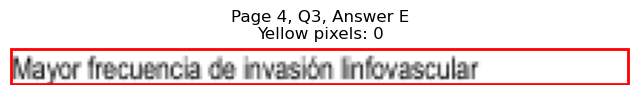


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=277.8, x1=173.5, y1=289.9
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 450
Page 4, Q4, A: Yellow percentage: 0.0%


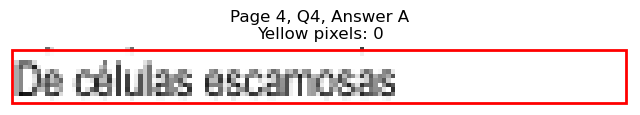

Page 4, Q4 - B: Detected box: x0=85.0, y0=289.9, x1=167.8, y1=302.0
Page 4, Q4, B: Yellow pixels: 1262
Page 4, Q4, B: Total non-white pixels: 1745
Page 4, Q4, B: Yellow percentage: 72.3%


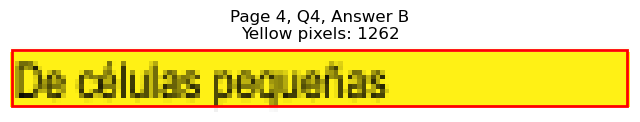

Page 4, Q4 - C: Detected box: x0=85.0, y0=301.9, x1=161.1, y1=314.0
Page 4, Q4, C: Yellow pixels: 125
Page 4, Q4, C: Total non-white pixels: 514
Page 4, Q4, C: Yellow percentage: 24.3%


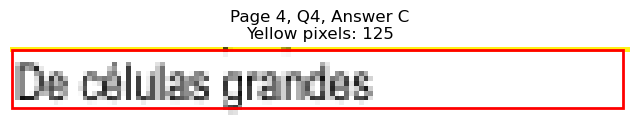

Page 4, Q4 - D: Detected box: x0=336.7, y0=277.8, x1=410.5, y1=289.9
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 378
Page 4, Q4, D: Yellow percentage: 0.0%


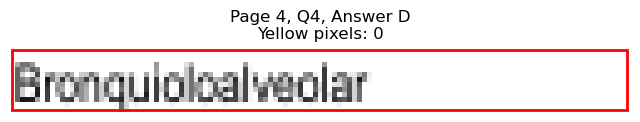

Page 4, Q4 - E: Detected box: x0=336.7, y0=289.9, x1=403.8, y1=302.0
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 333
Page 4, Q4, E: Yellow percentage: 0.0%


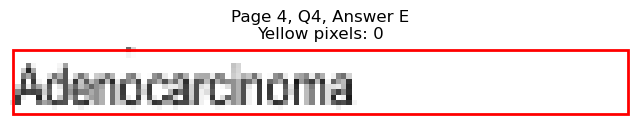


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=338.1, x1=243.9, y1=350.2
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 832
Page 4, Q5, A: Yellow percentage: 0.0%


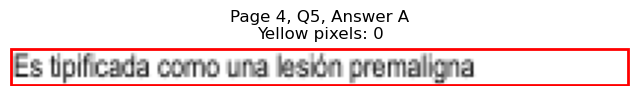

Page 4, Q5 - B: Detected box: x0=85.0, y0=350.2, x1=275.2, y1=362.3
Page 4, Q5, B: Yellow pixels: 1710
Page 4, Q5, B: Total non-white pixels: 2483
Page 4, Q5, B: Yellow percentage: 68.9%


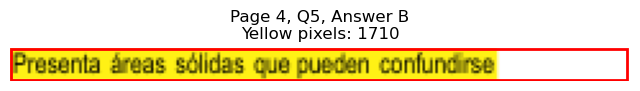

Page 4, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=253.0, y1=386.3
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 1051
Page 4, Q5, C: Yellow percentage: 0.0%


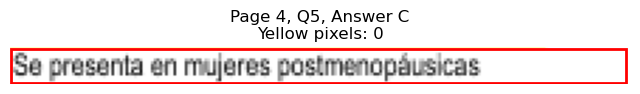

Page 4, Q5 - D: Detected box: x0=473.7, y0=338.1, x1=526.8, y1=350.2
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 258
Page 4, Q5, D: Yellow percentage: 0.0%


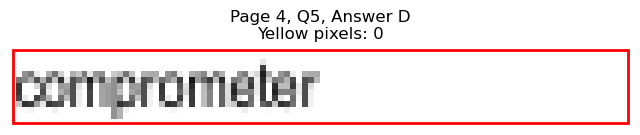

Page 4, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=517.2, y1=374.3
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 886
Page 4, Q5, E: Yellow percentage: 0.0%


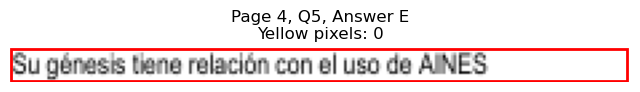


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=346.4, y1=422.5
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 1337
Page 4, Q6, A: Yellow percentage: 0.0%


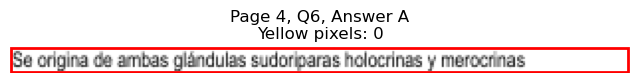

Page 4, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=218.6, y1=434.5
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 641
Page 4, Q6, B: Yellow percentage: 0.0%


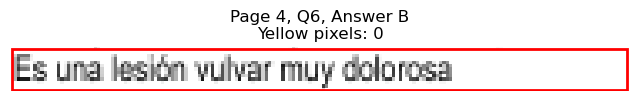

Page 4, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=243.4, y1=446.5
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 800
Page 4, Q6, C: Yellow percentage: 0.0%


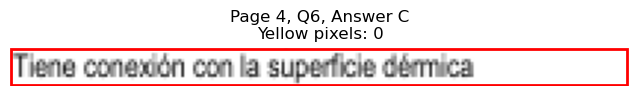

Page 4, Q6 - D: Detected box: x0=85.0, y0=446.6, x1=259.7, y1=458.7
Page 4, Q6, D: Yellow pixels: 226
Page 4, Q6, D: Total non-white pixels: 1091
Page 4, Q6, D: Yellow percentage: 20.7%


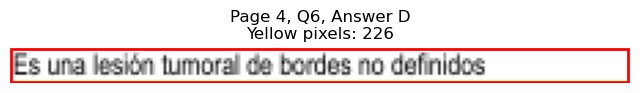

Page 4, Q6 - E: Detected box: x0=85.0, y0=458.6, x1=254.9, y1=470.7
Page 4, Q6, E: Yellow pixels: 2155
Page 4, Q6, E: Total non-white pixels: 2873
Page 4, Q6, E: Yellow percentage: 75.0%


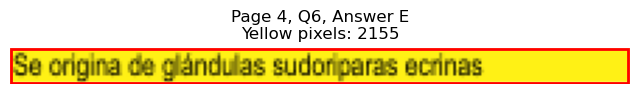


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=168.3, y1=518.9
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 553
Page 4, Q7, A: Yellow percentage: 0.0%


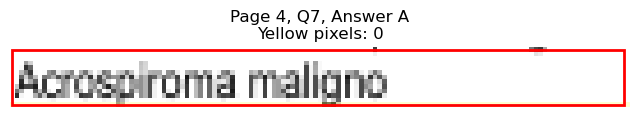

Page 4, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=198.9, y1=530.9
Page 4, Q7, B: Yellow pixels: 1512
Page 4, Q7, B: Total non-white pixels: 2145
Page 4, Q7, B: Yellow percentage: 70.5%


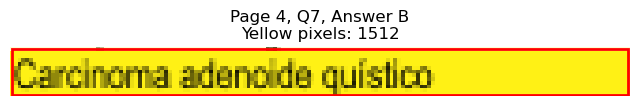

Page 4, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=143.4, y1=543.0
Page 4, Q7, C: Yellow pixels: 108
Page 4, Q7, C: Total non-white pixels: 377
Page 4, Q7, C: Yellow percentage: 28.6%


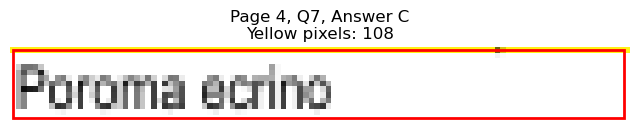

Page 4, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=420.0, y1=518.9
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 399
Page 4, Q7, D: Yellow percentage: 0.0%


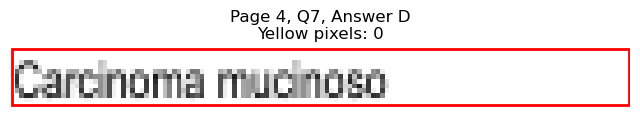

Page 4, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=438.7, y1=530.9
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 505
Page 4, Q7, E: Yellow percentage: 0.0%


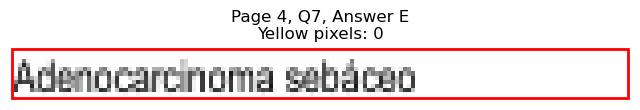


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=211.4, y1=579.2
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 645
Page 4, Q8, A: Yellow percentage: 0.0%


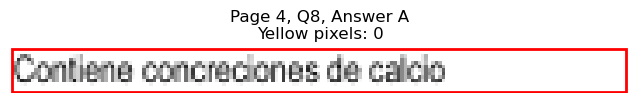

Page 4, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=273.2, y1=591.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 968
Page 4, Q8, B: Yellow percentage: 0.0%


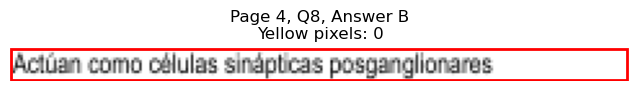

Page 4, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=187.1, y1=603.3
Page 4, Q8, C: Yellow pixels: 1453
Page 4, Q8, C: Total non-white pixels: 2002
Page 4, Q8, C: Yellow percentage: 72.6%


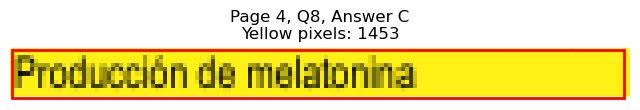

Page 4, Q8 - D: Detected box: x0=85.0, y0=603.2, x1=278.3, y1=615.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 1167
Page 4, Q8, D: Yellow percentage: 0.0%


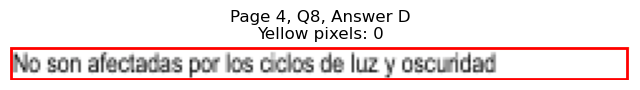

Page 4, Q8 - E: Detected box: x0=85.0, y0=615.2, x1=191.3, y1=627.3
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 512
Page 4, Q8, E: Yellow percentage: 0.0%


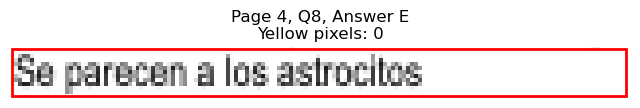


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=85.0, y0=675.4, x1=195.2, y1=687.5
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 586
Page 4, Q9, A: Yellow percentage: 0.0%


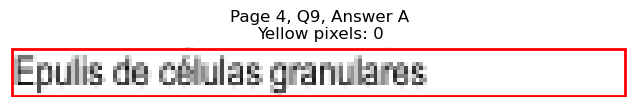

Page 4, Q9 - B: Detected box: x0=85.0, y0=687.5, x1=145.3, y1=699.7
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 306
Page 4, Q9, B: Yellow percentage: 0.0%


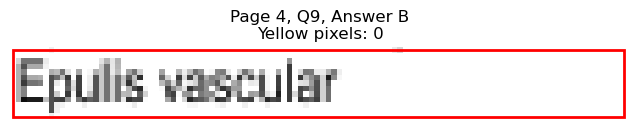

Page 4, Q9 - C: Detected box: x0=85.0, y0=699.5, x1=162.5, y1=711.7
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 379
Page 4, Q9, C: Yellow percentage: 0.0%


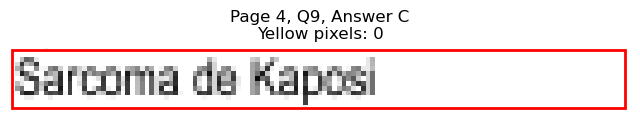

Page 4, Q9 - D: Detected box: x0=336.7, y0=675.4, x1=448.2, y1=687.5
Page 4, Q9, D: Yellow pixels: 1610
Page 4, Q9, D: Total non-white pixels: 2119
Page 4, Q9, D: Yellow percentage: 76.0%


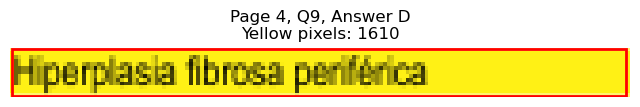

Page 4, Q9 - E: Detected box: x0=336.7, y0=687.5, x1=414.8, y1=699.7
Page 4, Q9, E: Yellow pixels: 129
Page 4, Q9, E: Total non-white pixels: 516
Page 4, Q9, E: Yellow percentage: 25.0%


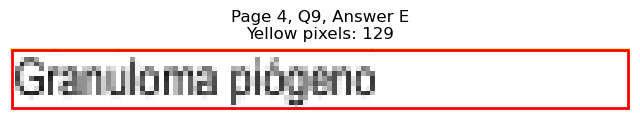


Page 4, Q9 - Selected Answer: D (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=85.0, y0=747.8, x1=180.3, y1=759.9
Page 4, Q10, A: Yellow pixels: 1363
Page 4, Q10, A: Total non-white pixels: 1911
Page 4, Q10, A: Yellow percentage: 71.3%


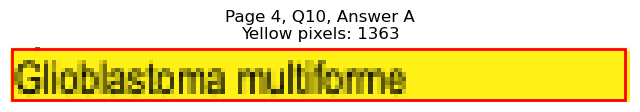

Page 4, Q10 - B: Detected box: x0=85.0, y0=759.8, x1=176.4, y1=771.9
Page 4, Q10, B: Yellow pixels: 143
Page 4, Q10, B: Total non-white pixels: 609
Page 4, Q10, B: Yellow percentage: 23.5%


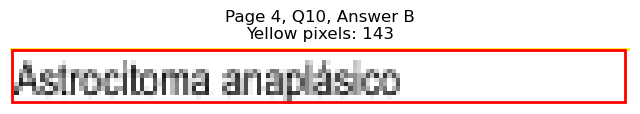

Page 4, Q10 - C: Detected box: x0=85.0, y0=771.9, x1=158.2, y1=784.0
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 372
Page 4, Q10, C: Yellow percentage: 0.0%


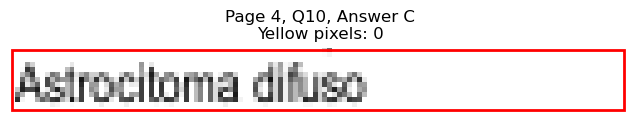

Page 4, Q10 - D: Detected box: x0=336.7, y0=747.8, x1=411.8, y1=759.9
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 387
Page 4, Q10, D: Yellow percentage: 0.0%


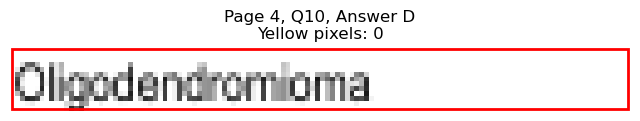

Page 4, Q10 - E: Detected box: x0=336.7, y0=759.8, x1=389.8, y1=771.9
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 268
Page 4, Q10, E: Yellow percentage: 0.0%


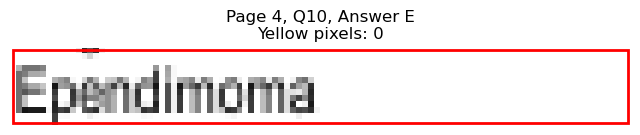


Page 4, Q10 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=102.3, y1=109.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 75
Page 5, Q1, A: Yellow percentage: 0.0%


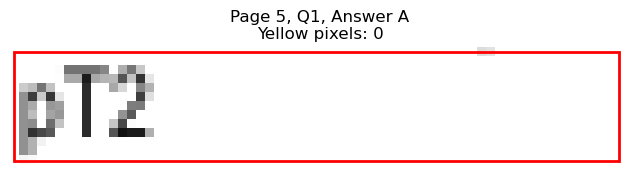

Page 5, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=102.3, y1=121.3
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 76
Page 5, Q1, B: Yellow percentage: 0.0%


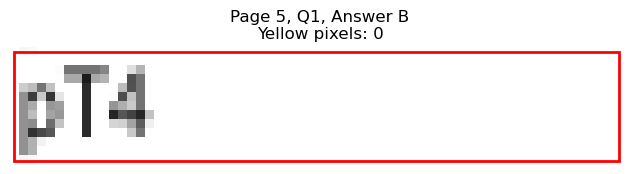

Page 5, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=107.1, y1=133.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 101
Page 5, Q1, C: Yellow percentage: 0.0%


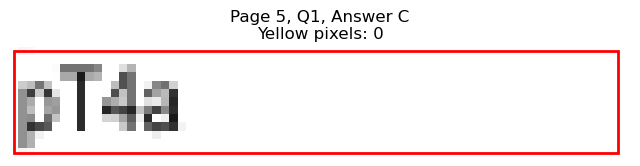

Page 5, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=358.8, y1=109.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 108
Page 5, Q1, D: Yellow percentage: 0.0%


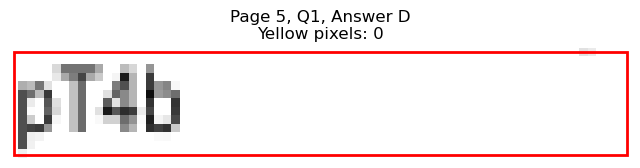

Page 5, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=354.0, y1=121.3
Page 5, Q1, E: Yellow pixels: 755
Page 5, Q1, E: Total non-white pixels: 884
Page 5, Q1, E: Yellow percentage: 85.4%


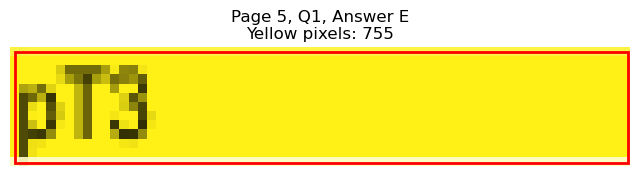


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=194.7, y1=169.4
Page 5, Q2, A: Yellow pixels: 1646
Page 5, Q2, A: Total non-white pixels: 2093
Page 5, Q2, A: Yellow percentage: 78.6%


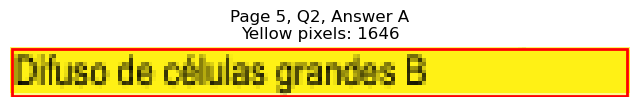

Page 5, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=144.4, y1=181.5
Page 5, Q2, B: Yellow pixels: 111
Page 5, Q2, B: Total non-white pixels: 415
Page 5, Q2, B: Yellow percentage: 26.7%


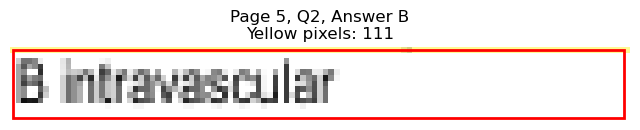

Page 5, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=143.9, y1=193.5
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 286
Page 5, Q2, C: Yellow percentage: 0.0%


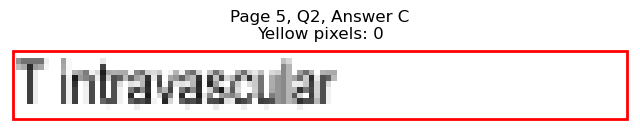

Page 5, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=363.4, y1=169.4
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 141
Page 5, Q2, D: Yellow percentage: 0.0%


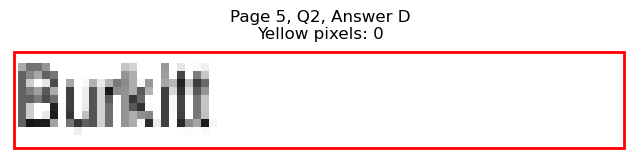

Page 5, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=370.6, y1=181.5
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 181
Page 5, Q2, E: Yellow percentage: 0.0%


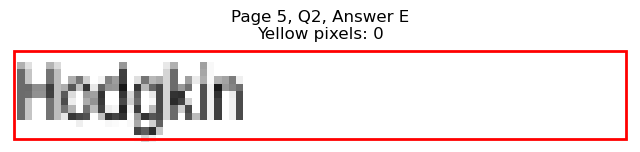


Page 5, Q2 - Selected Answer: A (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=156.3, y1=229.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 373
Page 5, Q3, A: Yellow percentage: 0.0%


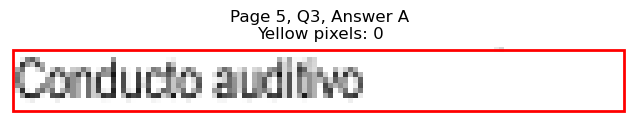

Page 5, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=170.2, y1=241.8
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 436
Page 5, Q3, B: Yellow percentage: 0.0%


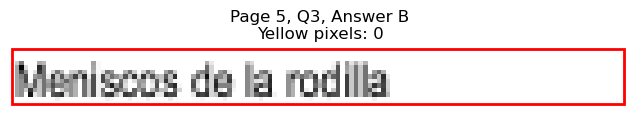

Page 5, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=121.8, y1=253.8
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 215
Page 5, Q3, C: Yellow percentage: 0.0%


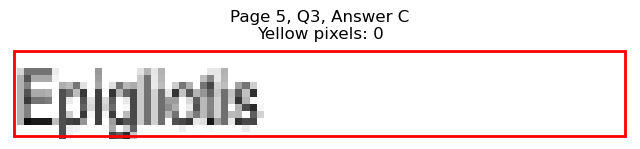

Page 5, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=465.5, y1=229.7
Page 5, Q3, D: Yellow pixels: 1790
Page 5, Q3, D: Total non-white pixels: 2340
Page 5, Q3, D: Yellow percentage: 76.5%


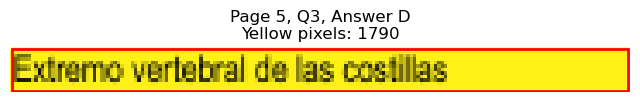

Page 5, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=407.0, y1=241.8
Page 5, Q3, E: Yellow pixels: 121
Page 5, Q3, E: Total non-white pixels: 492
Page 5, Q3, E: Yellow percentage: 24.6%


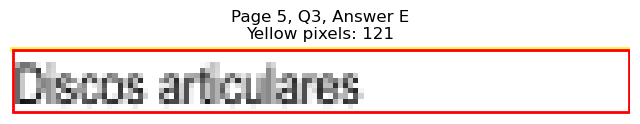


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=111.7, y1=302.0
Page 5, Q4, A: Yellow pixels: 857
Page 5, Q4, A: Total non-white pixels: 1014
Page 5, Q4, A: Yellow percentage: 84.5%


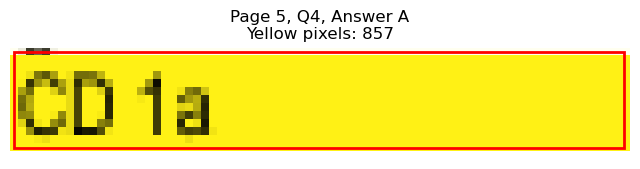

Page 5, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=106.9, y1=314.0
Page 5, Q4, B: Yellow pixels: 73
Page 5, Q4, B: Total non-white pixels: 170
Page 5, Q4, B: Yellow percentage: 42.9%


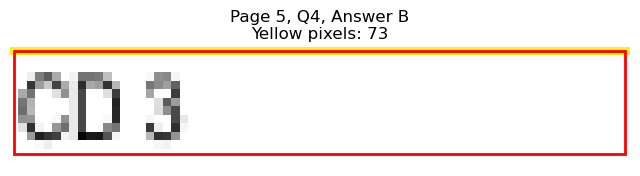

Page 5, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=111.7, y1=326.0
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 118
Page 5, Q4, C: Yellow percentage: 0.0%


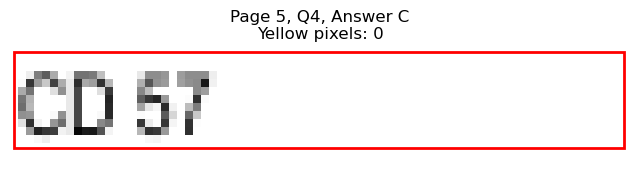

Page 5, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=363.4, y1=302.0
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 136
Page 5, Q4, D: Yellow percentage: 0.0%


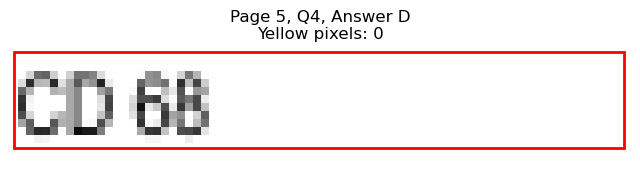

Page 5, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=363.4, y1=314.0
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 115
Page 5, Q4, E: Yellow percentage: 0.0%


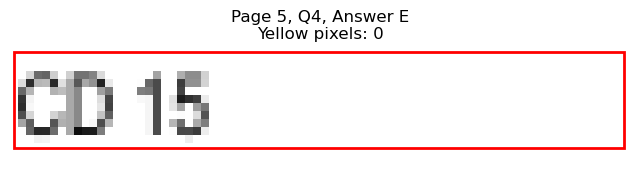


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=145.3, y1=362.3
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 311
Page 5, Q5, A: Yellow percentage: 0.0%


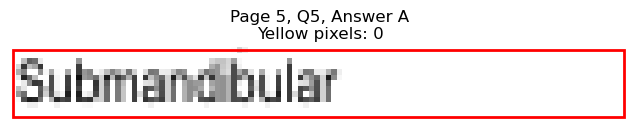

Page 5, Q5 - B: Detected box: x0=85.0, y0=362.2, x1=138.6, y1=374.3
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 262
Page 5, Q5, B: Yellow percentage: 0.0%


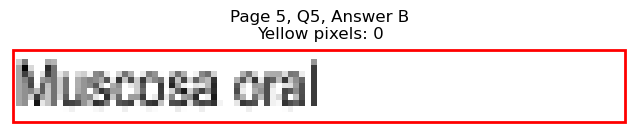

Page 5, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=142.0, y1=386.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 268
Page 5, Q5, C: Yellow percentage: 0.0%


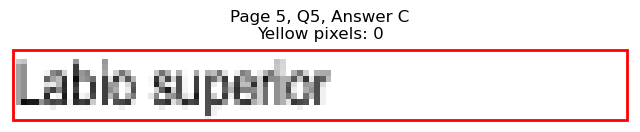

Page 5, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=371.1, y1=362.3
Page 5, Q5, D: Yellow pixels: 873
Page 5, Q5, D: Total non-white pixels: 1118
Page 5, Q5, D: Yellow percentage: 78.1%


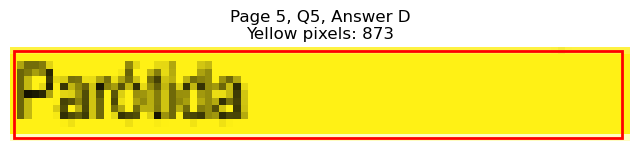

Page 5, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=368.7, y1=374.3
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 250
Page 5, Q5, E: Yellow percentage: 0.0%


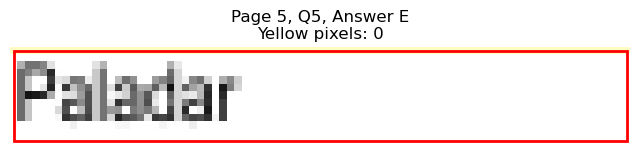


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=163.5, y1=422.5
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 391
Page 5, Q6, A: Yellow percentage: 0.0%


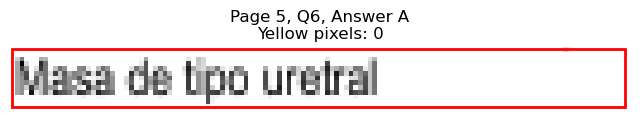

Page 5, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=129.5, y1=434.5
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 200
Page 5, Q6, B: Yellow percentage: 0.0%


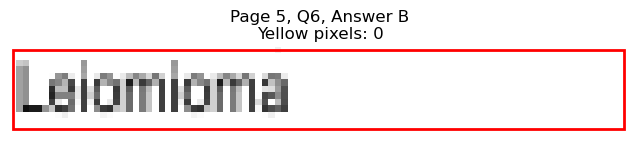

Page 5, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=145.3, y1=446.5
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 303
Page 5, Q6, C: Yellow percentage: 0.0%


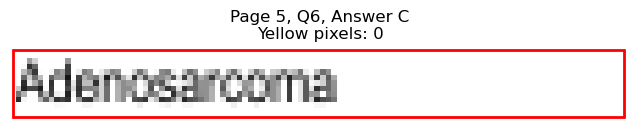

Page 5, Q6 - D: Detected box: x0=336.7, y0=410.4, x1=432.0, y1=422.5
Page 5, Q6, D: Yellow pixels: 1531
Page 5, Q6, D: Total non-white pixels: 1898
Page 5, Q6, D: Yellow percentage: 80.7%


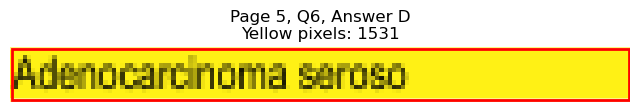

Page 5, Q6 - E: Detected box: x0=336.7, y0=422.4, x1=420.9, y1=434.5
Page 5, Q6, E: Yellow pixels: 135
Page 5, Q6, E: Total non-white pixels: 571
Page 5, Q6, E: Yellow percentage: 23.6%


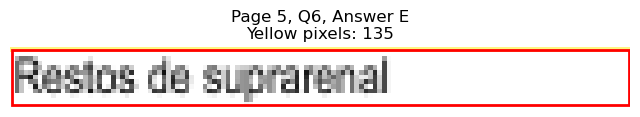


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=85.0, y0=494.7, x1=163.9, y1=506.8
Page 5, Q7, A: Yellow pixels: 1235
Page 5, Q7, A: Total non-white pixels: 1690
Page 5, Q7, A: Yellow percentage: 73.1%


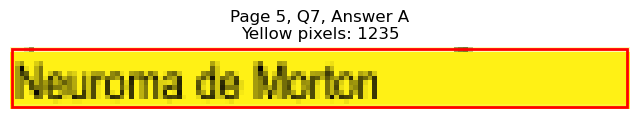

Page 5, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=165.4, y1=518.9
Page 5, Q7, B: Yellow pixels: 132
Page 5, Q7, B: Total non-white pixels: 548
Page 5, Q7, B: Yellow percentage: 24.1%


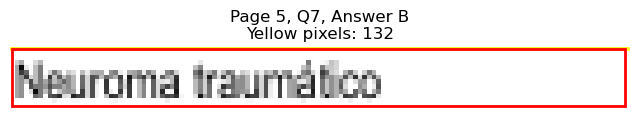

Page 5, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=163.0, y1=530.9
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 390
Page 5, Q7, C: Yellow percentage: 0.0%


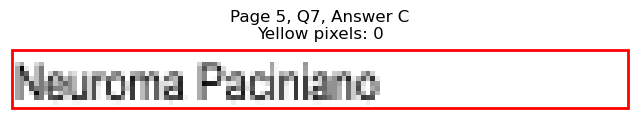

Page 5, Q7 - D: Detected box: x0=336.7, y0=494.7, x1=407.0, y1=506.8
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 328
Page 5, Q7, D: Yellow percentage: 0.0%


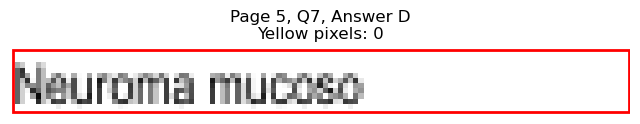

Page 5, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=452.5, y1=518.9
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 567
Page 5, Q7, E: Yellow percentage: 0.0%


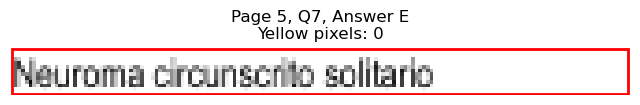


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=236.5, y1=591.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 694
Page 5, Q8, A: Yellow percentage: 0.0%


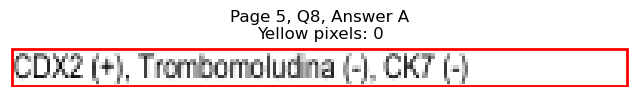

Page 5, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=240.8, y1=603.3
Page 5, Q8, B: Yellow pixels: 1728
Page 5, Q8, B: Total non-white pixels: 2483
Page 5, Q8, B: Yellow percentage: 69.6%


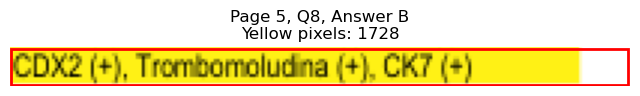

Page 5, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=238.6, y1=615.3
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 882
Page 5, Q8, C: Yellow percentage: 0.0%


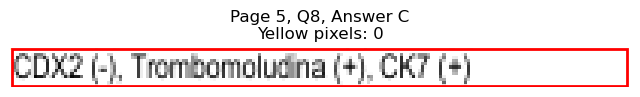

Page 5, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=490.3, y1=591.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 696
Page 5, Q8, D: Yellow percentage: 0.0%


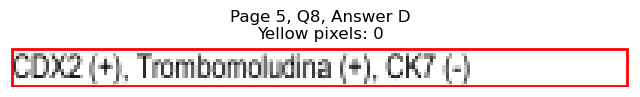

Page 5, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=488.1, y1=603.3
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 698
Page 5, Q8, E: Yellow percentage: 0.0%


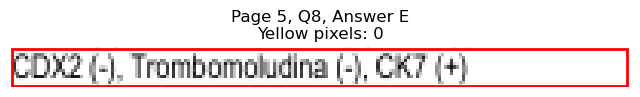


Page 5, Q8 - Selected Answer: B (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=126.6, y1=651.4
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 217
Page 5, Q9, A: Yellow percentage: 0.0%


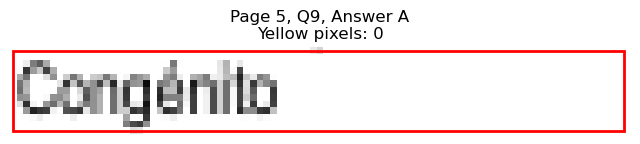

Page 5, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=111.7, y1=663.5
Page 5, Q9, B: Yellow pixels: 78
Page 5, Q9, B: Total non-white pixels: 191
Page 5, Q9, B: Yellow percentage: 40.8%


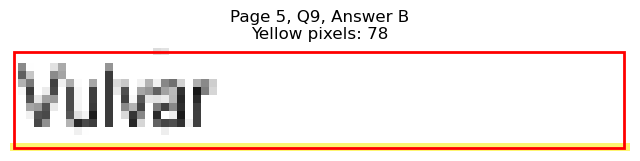

Page 5, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=155.3, y1=675.5
Page 5, Q9, C: Yellow pixels: 1266
Page 5, Q9, C: Total non-white pixels: 1586
Page 5, Q9, C: Yellow percentage: 79.8%


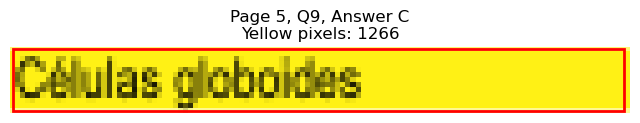

Page 5, Q9 - D: Detected box: x0=336.7, y0=639.3, x1=358.6, y1=651.4
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 98
Page 5, Q9, D: Yellow percentage: 0.0%


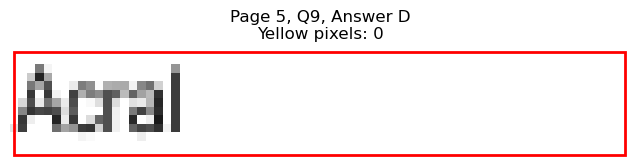

Page 5, Q9 - E: Detected box: x0=336.7, y0=651.4, x1=353.0, y1=663.5
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 74
Page 5, Q9, E: Yellow percentage: 0.0%


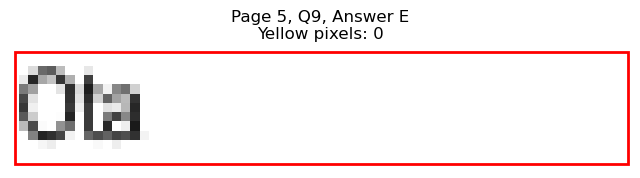


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=70.8, y0=699.5, x1=79.0, y1=711.7
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 53
Page 5, Q10, A: Yellow percentage: 0.0%


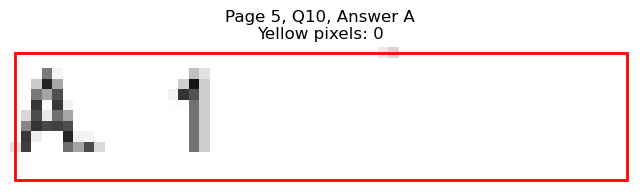

Page 5, Q10 - B: Detected box: x0=70.8, y0=711.7, x1=79.0, y1=723.8
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 69
Page 5, Q10, B: Yellow percentage: 0.0%


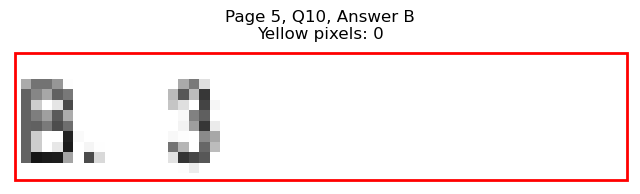

Page 5, Q10 - C: Detected box: x0=70.8, y0=723.7, x1=79.5, y1=735.8
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 68
Page 5, Q10, C: Yellow percentage: 0.0%


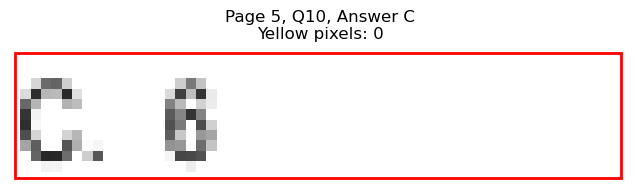

Page 5, Q10 - D: Detected box: x0=322.5, y0=699.5, x1=331.2, y1=711.7
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 66
Page 5, Q10, D: Yellow percentage: 0.0%


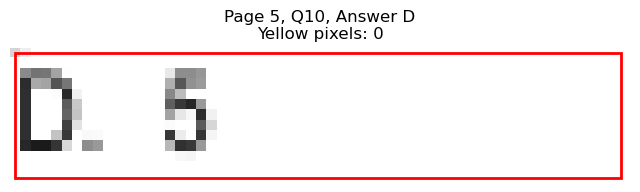

Page 5, Q10 - E: Detected box: x0=322.5, y0=711.7, x1=330.7, y1=723.8
Page 5, Q10, E: Yellow pixels: 658
Page 5, Q10, E: Total non-white pixels: 767
Page 5, Q10, E: Yellow percentage: 85.8%


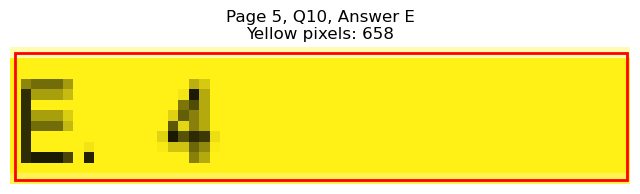


Page 5, Q10 - Selected Answer: E (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=121.3, y1=109.2
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 191
Page 6, Q1, A: Yellow percentage: 0.0%


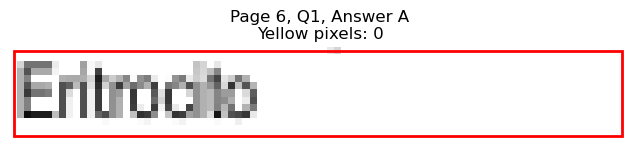

Page 6, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=119.4, y1=121.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 177
Page 6, Q1, B: Yellow percentage: 0.0%


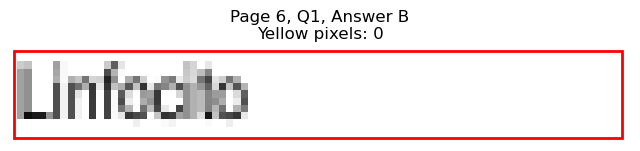

Page 6, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=122.3, y1=133.3
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 199
Page 6, Q1, C: Yellow percentage: 0.0%


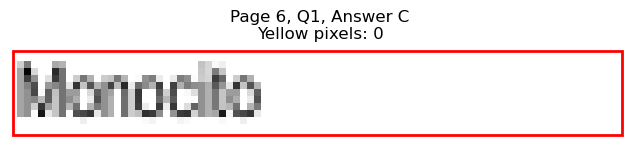

Page 6, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=377.4, y1=109.2
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 218
Page 6, Q1, D: Yellow percentage: 0.0%


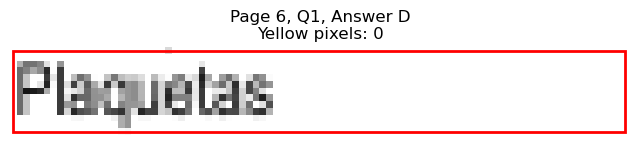

Page 6, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=375.9, y1=121.3
Page 6, Q1, E: Yellow pixels: 902
Page 6, Q1, E: Total non-white pixels: 1170
Page 6, Q1, E: Yellow percentage: 77.1%


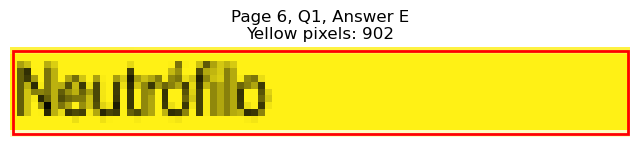


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=232.9, y1=169.4
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 756
Page 6, Q2, A: Yellow percentage: 0.0%


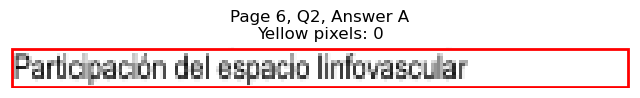

Page 6, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=240.5, y1=181.5
Page 6, Q2, B: Yellow pixels: 1790
Page 6, Q2, B: Total non-white pixels: 2483
Page 6, Q2, B: Yellow percentage: 72.1%


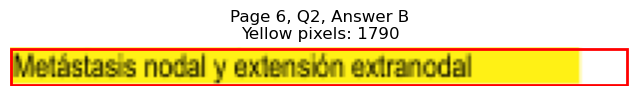

Page 6, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=158.7, y1=193.5
Page 6, Q2, C: Yellow pixels: 125
Page 6, Q2, C: Total non-white pixels: 472
Page 6, Q2, C: Yellow percentage: 26.5%


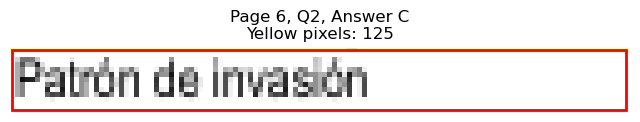

Page 6, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=429.6, y1=169.4
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 505
Page 6, Q2, D: Yellow percentage: 0.0%


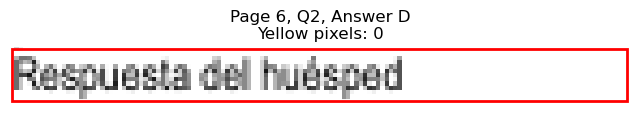

Page 6, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=418.0, y1=181.5
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 420
Page 6, Q2, E: Yellow percentage: 0.0%


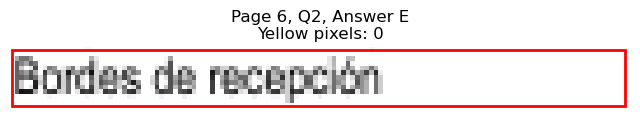


Page 6, Q2 - Selected Answer: B (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=217.5, x1=111.7, y1=229.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 124
Page 6, Q3, A: Yellow percentage: 0.0%


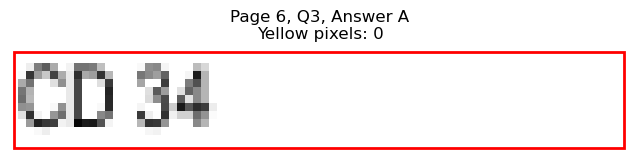

Page 6, Q3 - B: Detected box: x0=85.0, y0=229.7, x1=97.5, y1=241.8
Page 6, Q3, B: Yellow pixels: 714
Page 6, Q3, B: Total non-white pixels: 832
Page 6, Q3, B: Yellow percentage: 85.8%


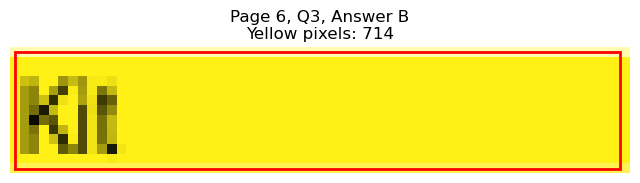

Page 6, Q3 - C: Detected box: x0=85.0, y0=241.7, x1=106.0, y1=253.8
Page 6, Q3, C: Yellow pixels: 72
Page 6, Q3, C: Total non-white pixels: 183
Page 6, Q3, C: Yellow percentage: 39.3%


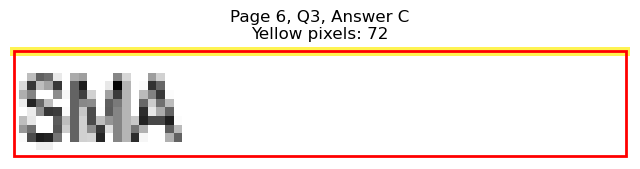

Page 6, Q3 - D: Detected box: x0=336.7, y0=217.5, x1=359.2, y1=229.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 118
Page 6, Q3, D: Yellow percentage: 0.0%


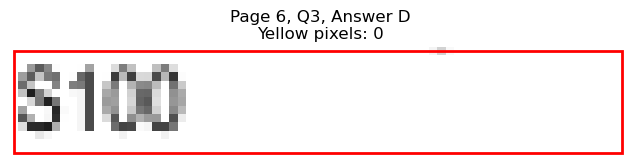

Page 6, Q3 - E: Detected box: x0=336.7, y0=229.7, x1=373.0, y1=241.8
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 191
Page 6, Q3, E: Yellow percentage: 0.0%


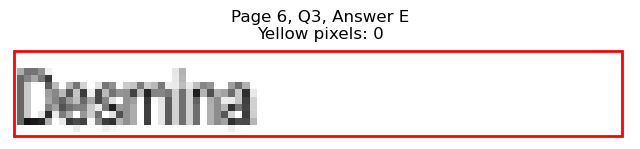


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=277.8, x1=165.9, y1=289.9
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 406
Page 6, Q4, A: Yellow percentage: 0.0%


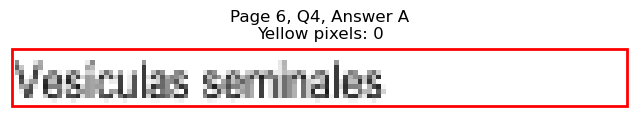

Page 6, Q4 - B: Detected box: x0=85.0, y0=289.9, x1=183.1, y1=302.0
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 535
Page 6, Q4, B: Yellow percentage: 0.0%


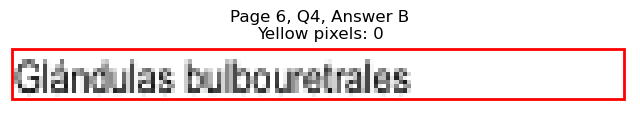

Page 6, Q4 - C: Detected box: x0=85.0, y0=301.9, x1=161.5, y1=314.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 422
Page 6, Q4, C: Yellow percentage: 0.0%


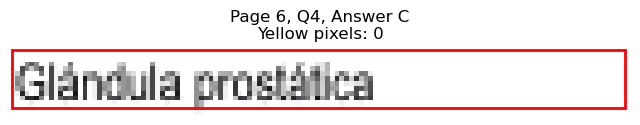

Page 6, Q4 - D: Detected box: x0=336.7, y0=277.8, x1=407.5, y1=289.9
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 341
Page 6, Q4, D: Yellow percentage: 0.0%


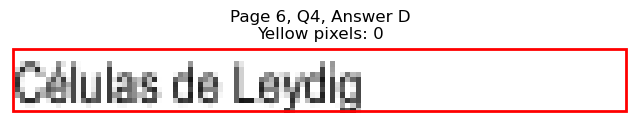

Page 6, Q4 - E: Detected box: x0=336.7, y0=289.9, x1=406.5, y1=302.0
Page 6, Q4, E: Yellow pixels: 1184
Page 6, Q4, E: Total non-white pixels: 1573
Page 6, Q4, E: Yellow percentage: 75.3%


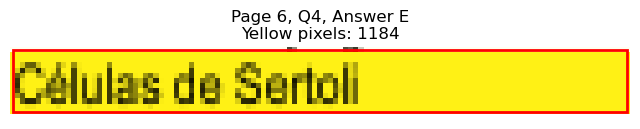


Page 6, Q4 - Selected Answer: E (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=338.1, x1=278.0, y1=350.2
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 952
Page 6, Q5, A: Yellow percentage: 0.0%


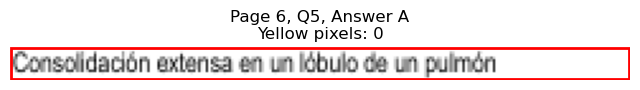

Page 6, Q5 - B: Detected box: x0=85.0, y0=350.2, x1=221.5, y1=362.3
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 663
Page 6, Q5, B: Yellow percentage: 0.0%


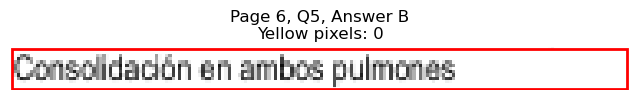

Page 6, Q5 - C: Detected box: x0=85.0, y0=362.2, x1=165.9, y1=374.3
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 421
Page 6, Q5, C: Yellow percentage: 0.0%


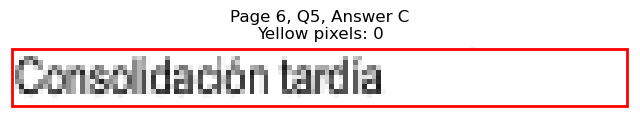

Page 6, Q5 - D: Detected box: x0=85.0, y0=374.2, x1=300.4, y1=386.3
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 1052
Page 6, Q5, D: Yellow percentage: 0.0%


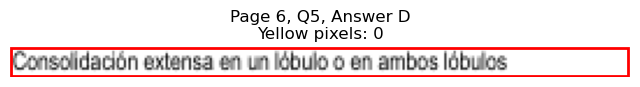

Page 6, Q5 - E: Detected box: x0=85.0, y0=386.3, x1=184.6, y1=398.4
Page 6, Q5, E: Yellow pixels: 1405
Page 6, Q5, E: Total non-white pixels: 1963
Page 6, Q5, E: Yellow percentage: 71.6%


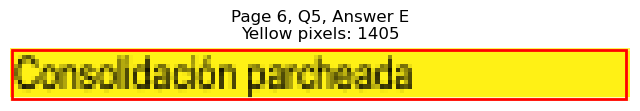


Page 6, Q5 - Selected Answer: E (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=115.6, y1=458.7
Page 6, Q6, A: Yellow pixels: 82
Page 6, Q6, A: Total non-white pixels: 226
Page 6, Q6, A: Yellow percentage: 36.3%


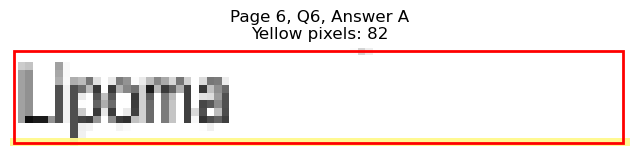

Page 6, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=148.7, y1=470.7
Page 6, Q6, B: Yellow pixels: 1220
Page 6, Q6, B: Total non-white pixels: 1495
Page 6, Q6, B: Yellow percentage: 81.6%


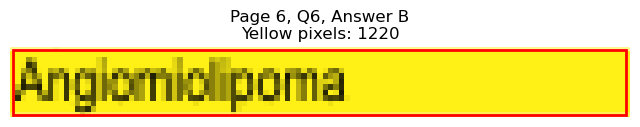

Page 6, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=142.5, y1=482.8
Page 6, Q6, C: Yellow pixels: 109
Page 6, Q6, C: Total non-white pixels: 397
Page 6, Q6, C: Yellow percentage: 27.5%


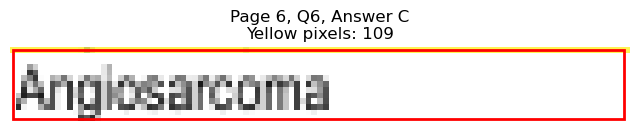

Page 6, Q6 - D: Detected box: x0=336.7, y0=446.6, x1=388.4, y1=458.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 251
Page 6, Q6, D: Yellow percentage: 0.0%


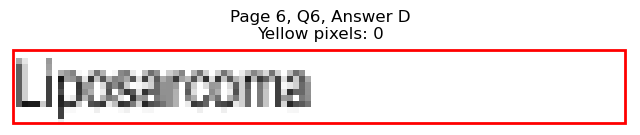

Page 6, Q6 - E: Detected box: x0=336.7, y0=458.6, x1=381.2, y1=470.7
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 228
Page 6, Q6, E: Yellow percentage: 0.0%


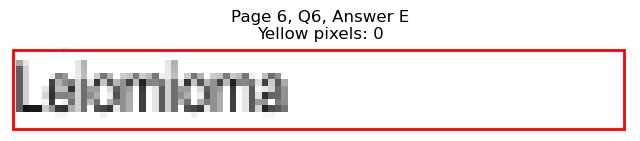


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=189.4, y1=518.9
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 712
Page 6, Q7, A: Yellow percentage: 0.0%


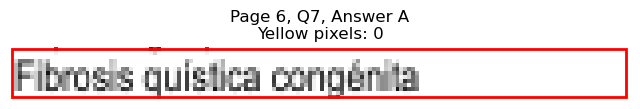

Page 6, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=156.3, y1=530.9
Page 6, Q7, B: Yellow pixels: 1138
Page 6, Q7, B: Total non-white pixels: 1599
Page 6, Q7, B: Yellow percentage: 71.2%


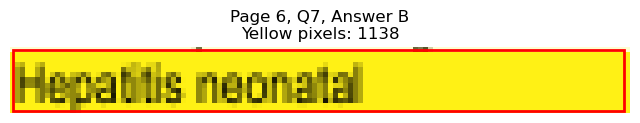

Page 6, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=155.8, y1=543.0
Page 6, Q7, C: Yellow pixels: 120
Page 6, Q7, C: Total non-white pixels: 482
Page 6, Q7, C: Yellow percentage: 24.9%


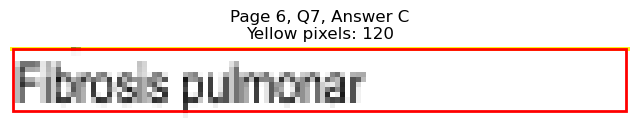

Page 6, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=407.5, y1=518.9
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 353
Page 6, Q7, D: Yellow percentage: 0.0%


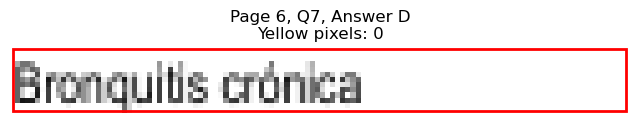

Page 6, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=426.2, y1=530.9
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 462
Page 6, Q7, E: Yellow percentage: 0.0%


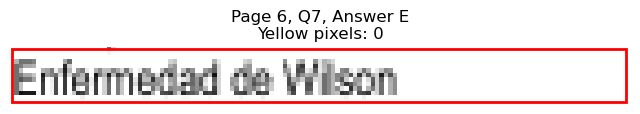


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=113.7, y1=579.2
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 143
Page 6, Q8, A: Yellow percentage: 0.0%


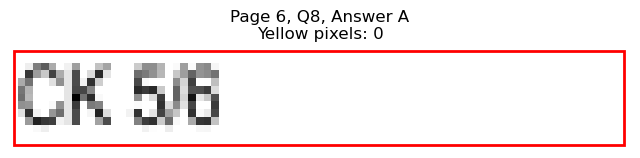

Page 6, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=128.5, y1=591.2
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 235
Page 6, Q8, B: Yellow percentage: 0.0%


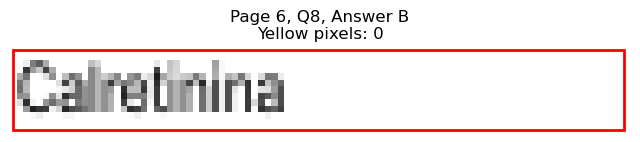

Page 6, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=105.0, y1=603.3
Page 6, Q8, C: Yellow pixels: 788
Page 6, Q8, C: Total non-white pixels: 936
Page 6, Q8, C: Yellow percentage: 84.2%


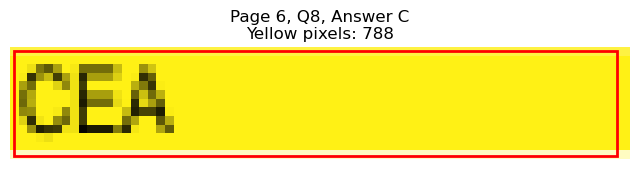

Page 6, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=387.0, y1=579.2
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 270
Page 6, Q8, D: Yellow percentage: 0.0%


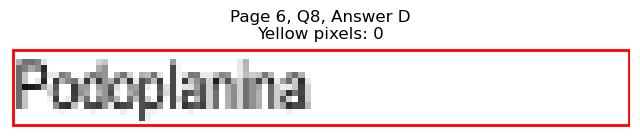

Page 6, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=357.7, y1=591.2
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 106
Page 6, Q8, E: Yellow percentage: 0.0%


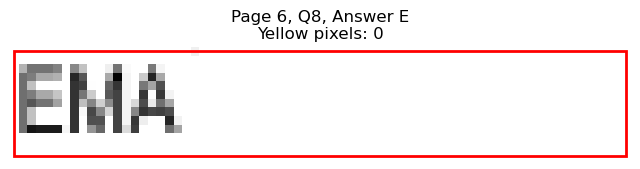


Page 6, Q8 - Selected Answer: C (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=151.6, y1=639.4
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 334
Page 6, Q9, A: Yellow percentage: 0.0%


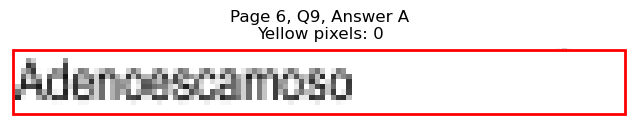

Page 6, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=212.3, y1=651.4
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 653
Page 6, Q9, B: Yellow percentage: 0.0%


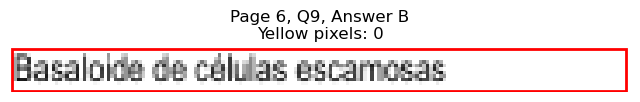

Page 6, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=178.3, y1=663.5
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 491
Page 6, Q9, C: Yellow percentage: 0.0%


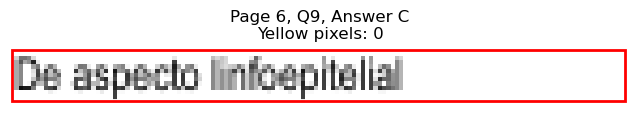

Page 6, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=378.3, y1=639.4
Page 6, Q9, D: Yellow pixels: 953
Page 6, Q9, D: Total non-white pixels: 1209
Page 6, Q9, D: Yellow percentage: 78.8%


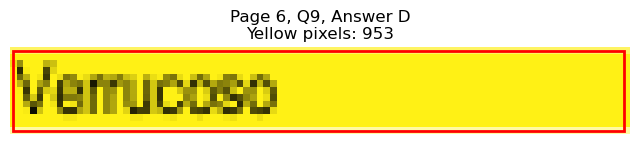

Page 6, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=414.2, y1=651.4
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 550
Page 6, Q9, E: Yellow percentage: 0.0%


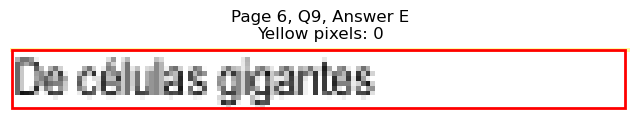


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=85.0, y0=687.5, x1=144.4, y1=699.7
Page 6, Q10, A: Yellow pixels: 1179
Page 6, Q10, A: Total non-white pixels: 1443
Page 6, Q10, A: Yellow percentage: 81.7%


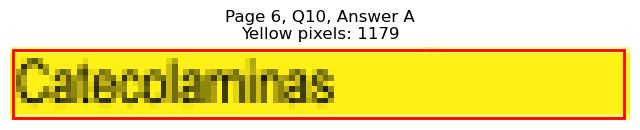

Page 6, Q10 - B: Detected box: x0=85.0, y0=699.5, x1=161.5, y1=711.7
Page 6, Q10, B: Yellow pixels: 128
Page 6, Q10, B: Total non-white pixels: 533
Page 6, Q10, B: Yellow percentage: 24.0%


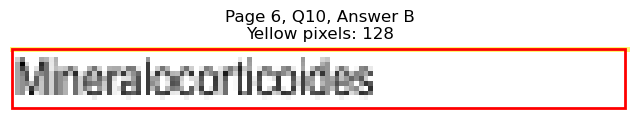

Page 6, Q10 - C: Detected box: x0=85.0, y0=711.7, x1=151.1, y1=723.8
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 345
Page 6, Q10, C: Yellow percentage: 0.0%


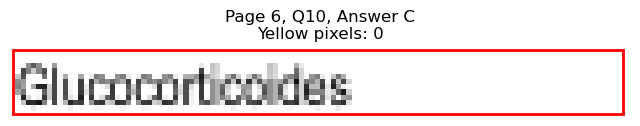

Page 6, Q10 - D: Detected box: x0=336.7, y0=687.5, x1=385.5, y1=699.7
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 250
Page 6, Q10, D: Yellow percentage: 0.0%


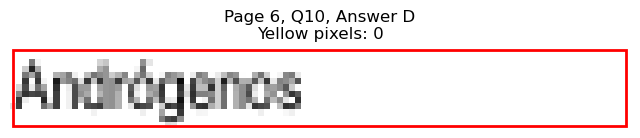

Page 6, Q10 - E: Detected box: x0=336.7, y0=699.5, x1=380.4, y1=711.7
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 243
Page 6, Q10, E: Yellow percentage: 0.0%


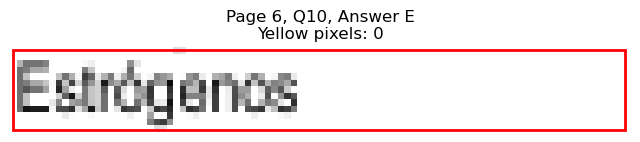


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=117.0, y1=121.3
Page 7, Q1, A: Yellow pixels: 879
Page 7, Q1, A: Total non-white pixels: 1092
Page 7, Q1, A: Yellow percentage: 80.5%


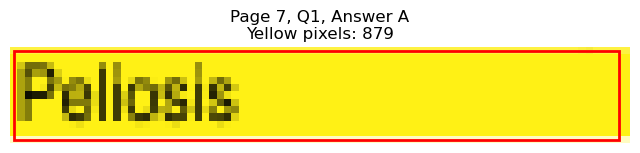

Page 7, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=138.6, y1=133.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 380
Page 7, Q1, B: Yellow percentage: 0.0%


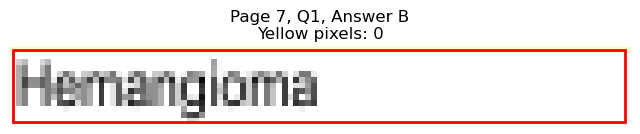

Page 7, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=134.3, y1=145.3
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 264
Page 7, Q1, C: Yellow percentage: 0.0%


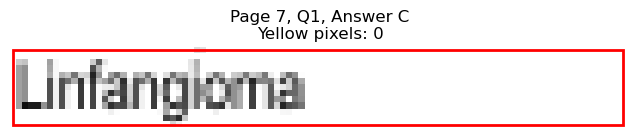

Page 7, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=446.4, y1=121.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 593
Page 7, Q1, D: Yellow percentage: 0.0%


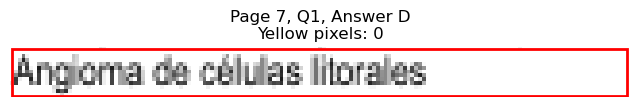

Page 7, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=411.3, y1=133.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 400
Page 7, Q1, E: Yellow percentage: 0.0%


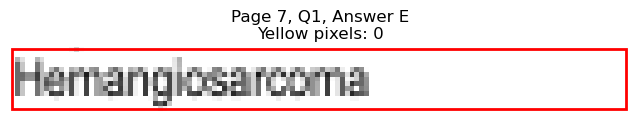


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=158.7, y1=181.5
Page 7, Q2, A: Yellow pixels: 1329
Page 7, Q2, A: Total non-white pixels: 1625
Page 7, Q2, A: Yellow percentage: 81.8%


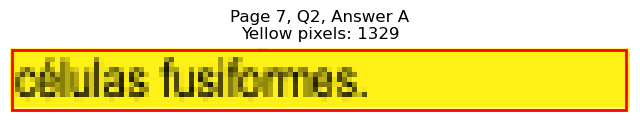

Page 7, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=119.9, y1=193.5
Page 7, Q2, B: Yellow pixels: 86
Page 7, Q2, B: Total non-white pixels: 255
Page 7, Q2, B: Yellow percentage: 33.7%


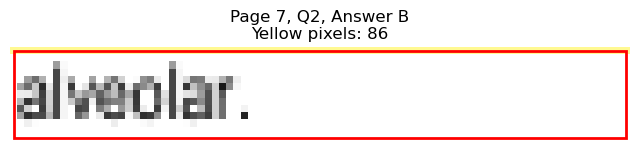

Page 7, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=128.1, y1=205.5
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 212
Page 7, Q2, C: Yellow percentage: 0.0%


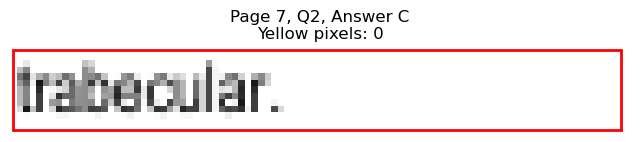

Page 7, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=363.9, y1=181.5
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 134
Page 7, Q2, D: Yellow percentage: 0.0%


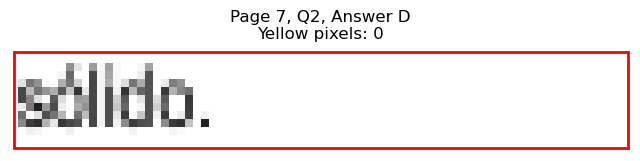

Page 7, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=481.3, y1=193.5
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 711
Page 7, Q2, E: Yellow percentage: 0.0%


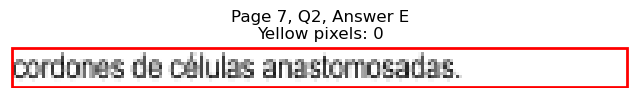


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=229.7, x1=128.5, y1=241.8
Page 7, Q3, A: Yellow pixels: 934
Page 7, Q3, A: Total non-white pixels: 1235
Page 7, Q3, A: Yellow percentage: 75.6%


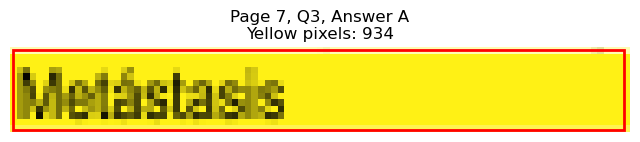

Page 7, Q3 - B: Detected box: x0=85.0, y0=241.7, x1=135.7, y1=253.8
Page 7, Q3, B: Yellow pixels: 102
Page 7, Q3, B: Total non-white pixels: 367
Page 7, Q3, B: Yellow percentage: 27.8%


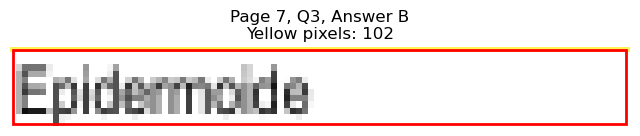

Page 7, Q3 - C: Detected box: x0=85.0, y0=253.7, x1=135.3, y1=265.8
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 233
Page 7, Q3, C: Yellow percentage: 0.0%


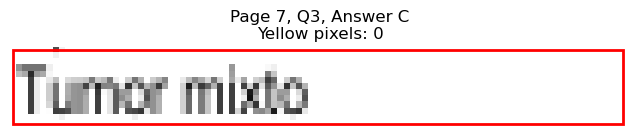

Page 7, Q3 - D: Detected box: x0=336.7, y0=229.7, x1=403.8, y1=241.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 330
Page 7, Q3, D: Yellow percentage: 0.0%


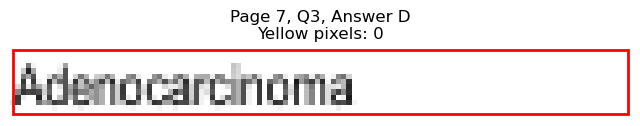

Page 7, Q3 - E: Detected box: x0=336.7, y0=241.7, x1=462.1, y1=253.8
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 609
Page 7, Q3, E: Yellow percentage: 0.0%


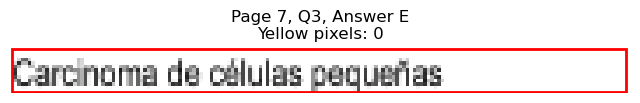


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=289.9, x1=134.8, y1=302.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 261
Page 7, Q4, A: Yellow percentage: 0.0%


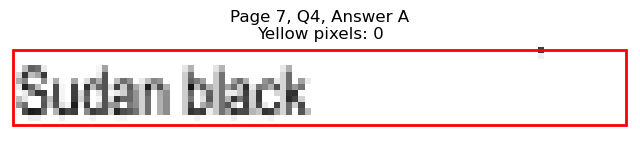

Page 7, Q4 - B: Detected box: x0=85.0, y0=301.9, x1=104.7, y1=314.0
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 94
Page 7, Q4, B: Yellow percentage: 0.0%


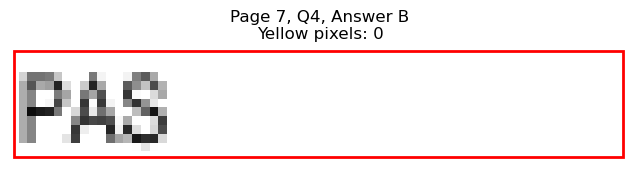

Page 7, Q4 - C: Detected box: x0=85.0, y0=313.9, x1=111.7, y1=326.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 128
Page 7, Q4, C: Yellow percentage: 0.0%


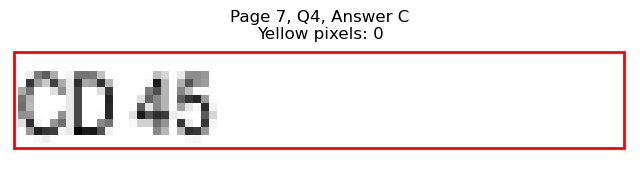

Page 7, Q4 - D: Detected box: x0=336.7, y0=289.9, x1=401.8, y1=302.0
Page 7, Q4, D: Yellow pixels: 1100
Page 7, Q4, D: Total non-white pixels: 1509
Page 7, Q4, D: Yellow percentage: 72.9%


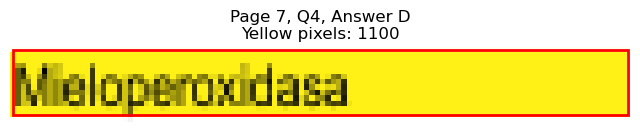

Page 7, Q4 - E: Detected box: x0=336.7, y0=301.9, x1=367.3, y1=314.0
Page 7, Q4, E: Yellow pixels: 80
Page 7, Q4, E: Total non-white pixels: 225
Page 7, Q4, E: Yellow percentage: 35.6%


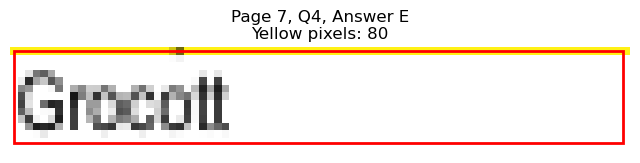


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=350.2, x1=179.8, y1=362.3
Page 7, Q5, A: Yellow pixels: 1358
Page 7, Q5, A: Total non-white pixels: 1898
Page 7, Q5, A: Yellow percentage: 71.5%


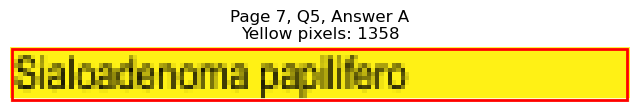

Page 7, Q5 - B: Detected box: x0=85.0, y0=362.2, x1=156.3, y1=374.3
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 469
Page 7, Q5, B: Yellow percentage: 0.0%


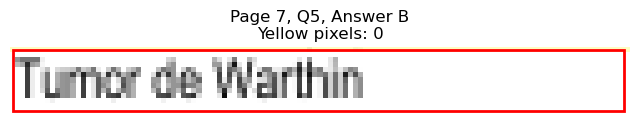

Page 7, Q5 - C: Detected box: x0=85.0, y0=374.2, x1=207.1, y1=386.3
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 635
Page 7, Q5, C: Yellow percentage: 0.0%


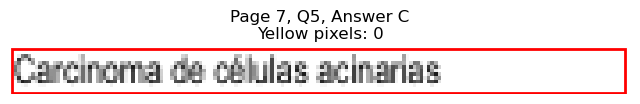

Page 7, Q5 - D: Detected box: x0=336.7, y0=350.2, x1=385.0, y1=362.3
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 239
Page 7, Q5, D: Yellow percentage: 0.0%


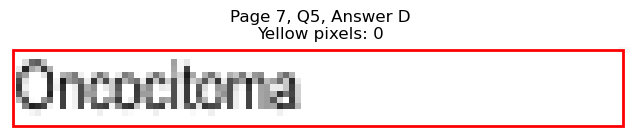

Page 7, Q5 - E: Detected box: x0=336.7, y0=362.2, x1=419.5, y1=374.3
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 414
Page 7, Q5, E: Yellow percentage: 0.0%


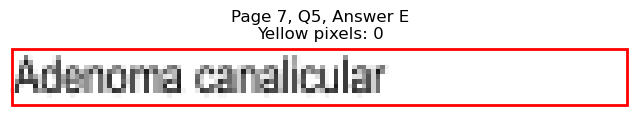


Page 7, Q5 - Selected Answer: A (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=410.4, x1=108.9, y1=422.5
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 122
Page 7, Q6, A: Yellow percentage: 0.0%


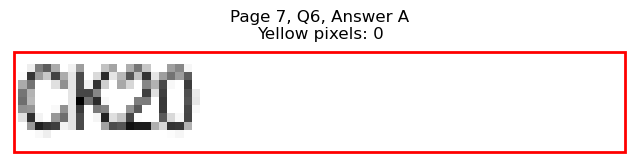

Page 7, Q6 - B: Detected box: x0=85.0, y0=422.4, x1=106.5, y1=434.5
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 111
Page 7, Q6, B: Yellow percentage: 0.0%


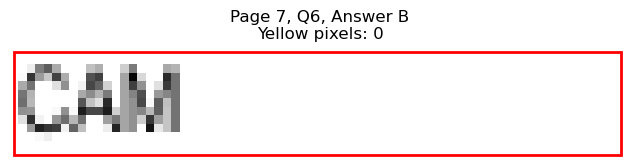

Page 7, Q6 - C: Detected box: x0=85.0, y0=434.4, x1=106.0, y1=446.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 109
Page 7, Q6, C: Yellow percentage: 0.0%


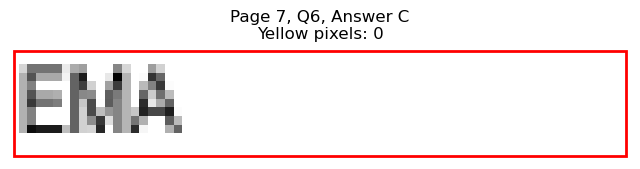

Page 7, Q6 - D: Detected box: x0=336.7, y0=410.4, x1=393.7, y1=422.5
Page 7, Q6, D: Yellow pixels: 108
Page 7, Q6, D: Total non-white pixels: 385
Page 7, Q6, D: Yellow percentage: 28.1%


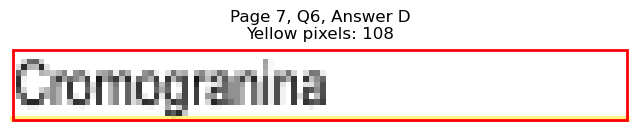

Page 7, Q6 - E: Detected box: x0=336.7, y0=422.4, x1=354.4, y1=434.5
Page 7, Q6, E: Yellow pixels: 825
Page 7, Q6, E: Total non-white pixels: 897
Page 7, Q6, E: Yellow percentage: 92.0%


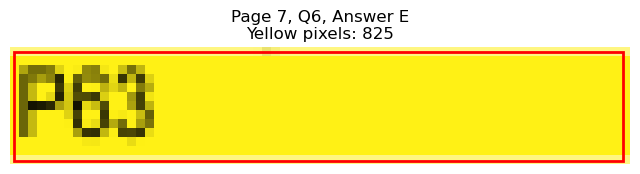


Page 7, Q6 - Selected Answer: E (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=494.7, x1=176.4, y1=506.8
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 492
Page 7, Q7, A: Yellow percentage: 0.0%


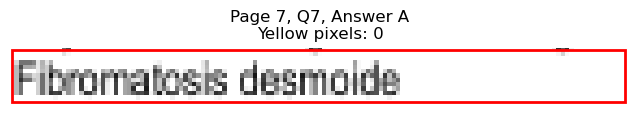

Page 7, Q7 - B: Detected box: x0=85.0, y0=506.8, x1=165.4, y1=518.9
Page 7, Q7, B: Yellow pixels: 1238
Page 7, Q7, B: Total non-white pixels: 1716
Page 7, Q7, B: Yellow percentage: 72.1%


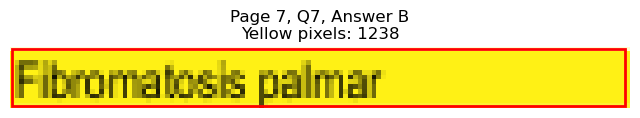

Page 7, Q7 - C: Detected box: x0=85.0, y0=518.8, x1=163.5, y1=530.9
Page 7, Q7, C: Yellow pixels: 129
Page 7, Q7, C: Total non-white pixels: 565
Page 7, Q7, C: Yellow percentage: 22.8%


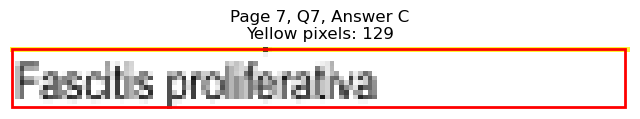

Page 7, Q7 - D: Detected box: x0=336.7, y0=494.7, x1=473.1, y1=506.8
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 725
Page 7, Q7, D: Yellow percentage: 0.0%


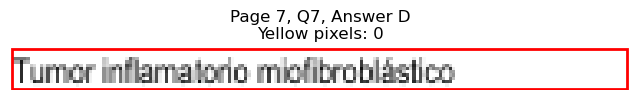

Page 7, Q7 - E: Detected box: x0=336.7, y0=506.8, x1=445.9, y1=518.9
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 550
Page 7, Q7, E: Yellow percentage: 0.0%


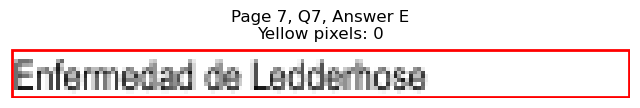


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=102.3, y1=579.2
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 82
Page 7, Q8, A: Yellow percentage: 0.0%


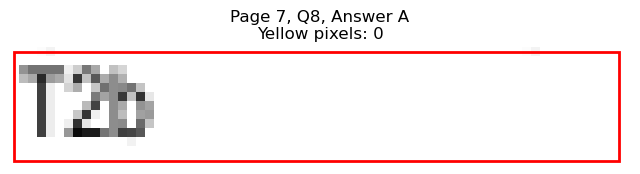

Page 7, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=102.3, y1=591.2
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 81
Page 7, Q8, B: Yellow percentage: 0.0%


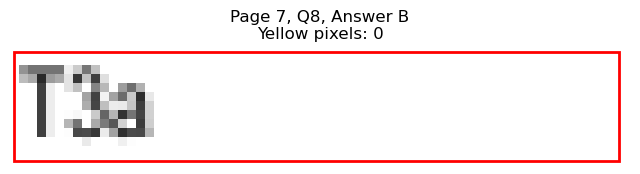

Page 7, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=102.3, y1=603.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 83
Page 7, Q8, C: Yellow percentage: 0.0%


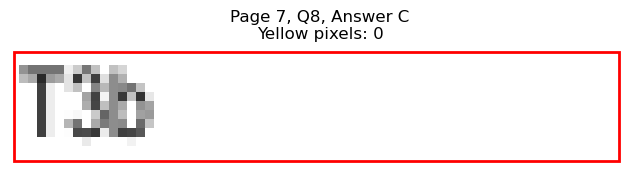

Page 7, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=354.0, y1=579.2
Page 7, Q8, D: Yellow pixels: 759
Page 7, Q8, D: Total non-white pixels: 884
Page 7, Q8, D: Yellow percentage: 85.9%


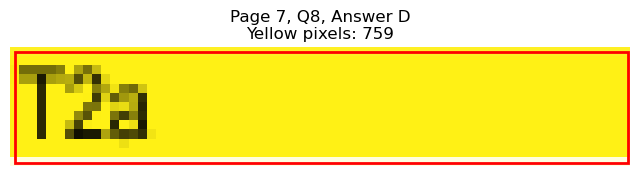

Page 7, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=349.2, y1=591.2
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 106
Page 7, Q8, E: Yellow percentage: 0.0%


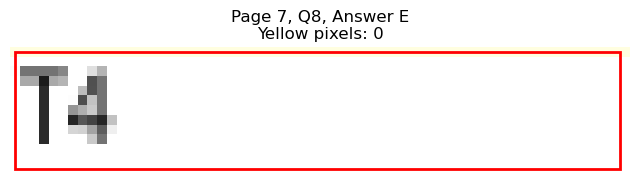


Page 7, Q8 - Selected Answer: D (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=627.3, x1=127.6, y1=639.4
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 204
Page 7, Q9, A: Yellow percentage: 0.0%


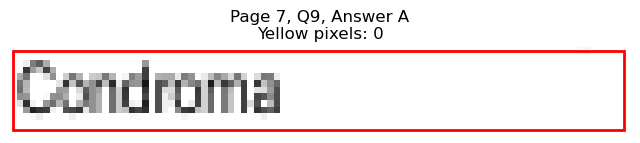

Page 7, Q9 - B: Detected box: x0=85.0, y0=639.3, x1=140.1, y1=651.4
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 281
Page 7, Q9, B: Yellow percentage: 0.0%


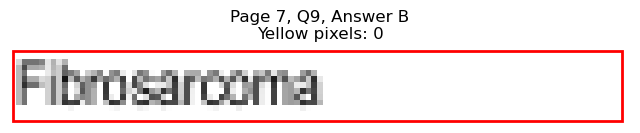

Page 7, Q9 - C: Detected box: x0=85.0, y0=651.4, x1=148.6, y1=663.5
Page 7, Q9, C: Yellow pixels: 1248
Page 7, Q9, C: Total non-white pixels: 1495
Page 7, Q9, C: Yellow percentage: 83.5%


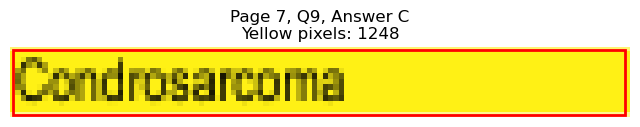

Page 7, Q9 - D: Detected box: x0=336.7, y0=627.3, x1=391.3, y1=639.4
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 268
Page 7, Q9, D: Yellow percentage: 0.0%


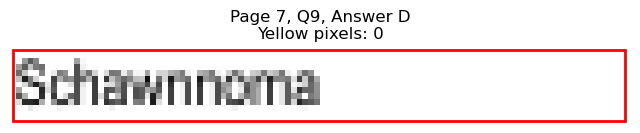

Page 7, Q9 - E: Detected box: x0=336.7, y0=639.3, x1=394.2, y1=651.4
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 298
Page 7, Q9, E: Yellow percentage: 0.0%


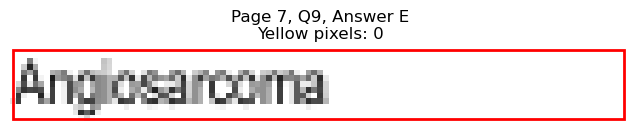


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=85.0, y0=687.5, x1=104.2, y1=699.7
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 99
Page 7, Q10, A: Yellow percentage: 0.0%


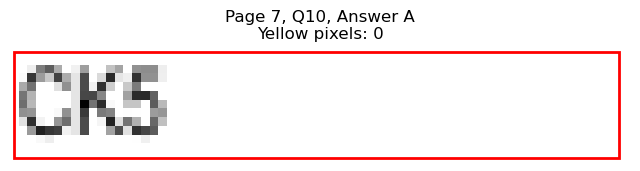

Page 7, Q10 - B: Detected box: x0=85.0, y0=699.5, x1=106.0, y1=711.7
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 109
Page 7, Q10, B: Yellow percentage: 0.0%


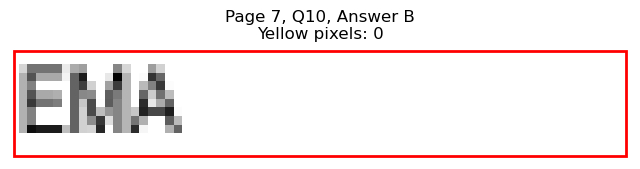

Page 7, Q10 - C: Detected box: x0=85.0, y0=711.7, x1=110.3, y1=723.8
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 118
Page 7, Q10, C: Yellow percentage: 0.0%


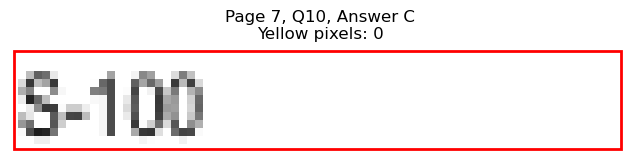

Page 7, Q10 - D: Detected box: x0=336.7, y0=687.5, x1=354.4, y1=699.7
Page 7, Q10, D: Yellow pixels: 69
Page 7, Q10, D: Total non-white pixels: 150
Page 7, Q10, D: Yellow percentage: 46.0%


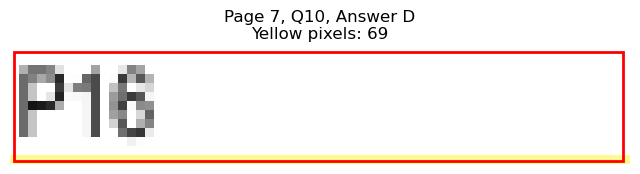

Page 7, Q10 - E: Detected box: x0=336.7, y0=699.5, x1=378.9, y1=711.7
Page 7, Q10, E: Yellow pixels: 1012
Page 7, Q10, E: Total non-white pixels: 1209
Page 7, Q10, E: Yellow percentage: 83.7%


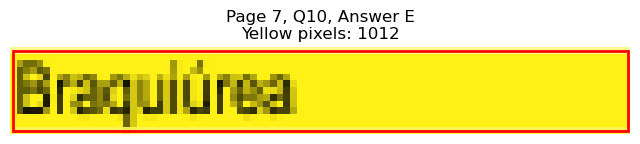


Page 7, Q10 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=139.6, y1=121.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 287
Page 8, Q1, A: Yellow percentage: 0.0%


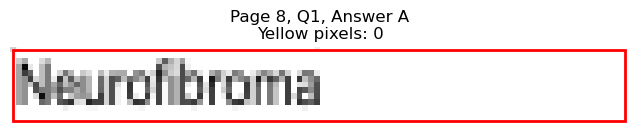

Page 8, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=129.5, y1=133.3
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 199
Page 8, Q1, B: Yellow percentage: 0.0%


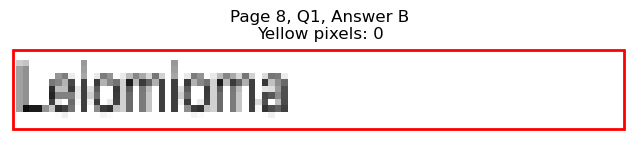

Page 8, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=138.6, y1=145.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 270
Page 8, Q1, C: Yellow percentage: 0.0%


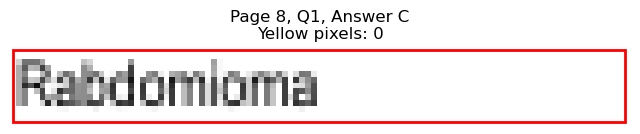

Page 8, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=370.6, y1=121.3
Page 8, Q1, D: Yellow pixels: 85
Page 8, Q1, D: Total non-white pixels: 253
Page 8, Q1, D: Yellow percentage: 33.6%


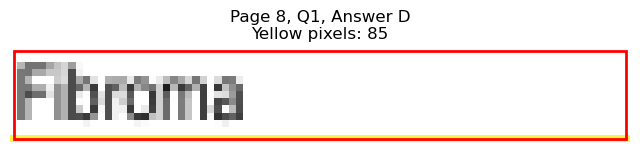

Page 8, Q1 - E: Detected box: x0=336.7, y0=181.4, x1=390.0, y1=193.5
Page 8, Q1, E: Yellow pixels: 104
Page 8, Q1, E: Total non-white pixels: 676
Page 8, Q1, E: Yellow percentage: 15.4%


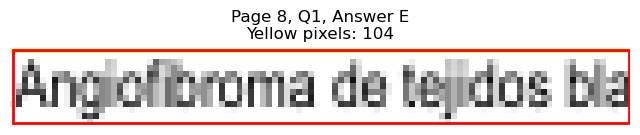


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=233.8, y1=181.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 763
Page 8, Q2, A: Yellow percentage: 0.0%


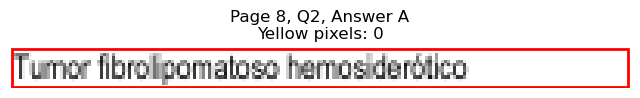

Page 8, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=222.4, y1=193.5
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 714
Page 8, Q2, B: Yellow percentage: 0.0%


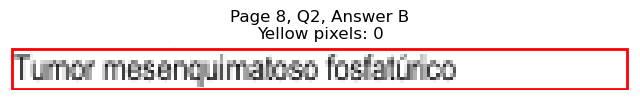

Page 8, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=221.5, y1=205.5
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 700
Page 8, Q2, C: Yellow percentage: 0.0%


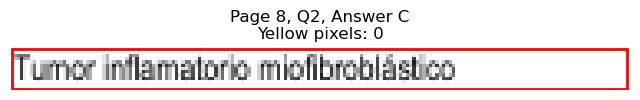

Page 8, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=451.5, y1=181.5
Page 8, Q2, D: Yellow pixels: 1671
Page 8, Q2, D: Total non-white pixels: 2158
Page 8, Q2, D: Yellow percentage: 77.4%


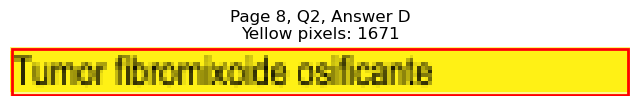

Page 8, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=461.6, y1=193.5
Page 8, Q2, E: Yellow pixels: 176
Page 8, Q2, E: Total non-white pixels: 850
Page 8, Q2, E: Yellow percentage: 20.7%


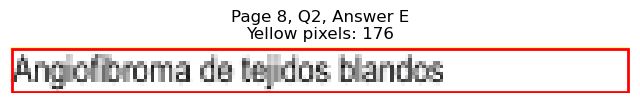


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=162.5, y1=289.9
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 377
Page 8, Q3, A: Yellow percentage: 0.0%


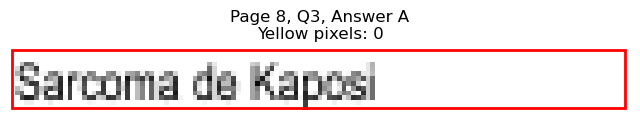

Page 8, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=193.1, y1=302.0
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 551
Page 8, Q3, B: Yellow percentage: 0.0%


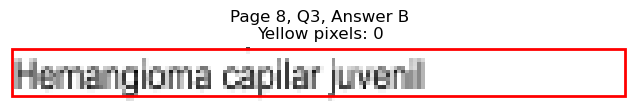

Page 8, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=142.5, y1=314.0
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 303
Page 8, Q3, C: Yellow percentage: 0.0%


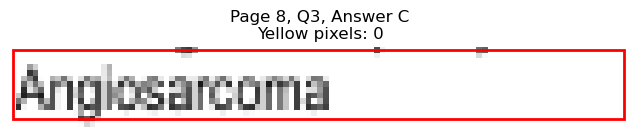

Page 8, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=414.7, y1=289.9
Page 8, Q3, D: Yellow pixels: 1234
Page 8, Q3, D: Total non-white pixels: 1677
Page 8, Q3, D: Yellow percentage: 73.6%


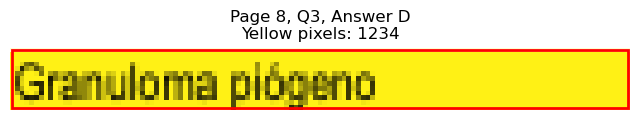

Page 8, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=415.2, y1=302.0
Page 8, Q3, E: Yellow pixels: 126
Page 8, Q3, E: Total non-white pixels: 522
Page 8, Q3, E: Yellow percentage: 24.1%


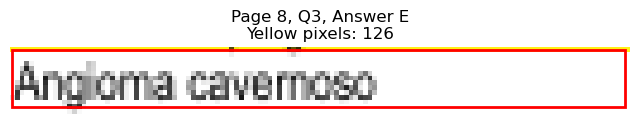


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=153.9, y1=386.3
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 369
Page 8, Q4, A: Yellow percentage: 0.0%


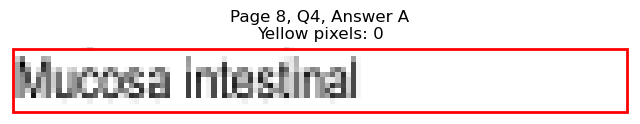

Page 8, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=160.1, y1=398.4
Page 8, Q4, B: Yellow pixels: 127
Page 8, Q4, B: Total non-white pixels: 499
Page 8, Q4, B: Yellow percentage: 25.5%


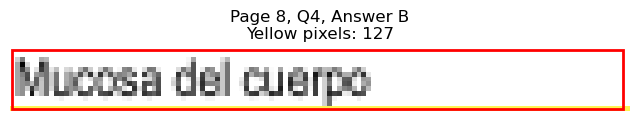

Page 8, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=141.5, y1=410.4
Page 8, Q4, C: Yellow pixels: 1179
Page 8, Q4, C: Total non-white pixels: 1404
Page 8, Q4, C: Yellow percentage: 84.0%


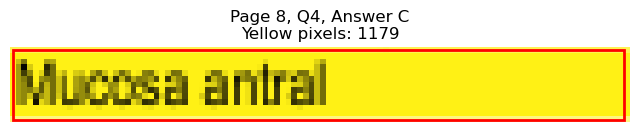

Page 8, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=498.5, y1=386.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 859
Page 8, Q4, D: Yellow percentage: 0.0%


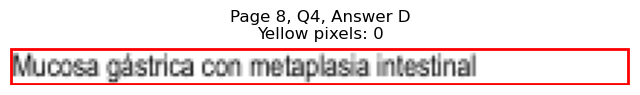

Page 8, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=481.3, y1=398.4
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 721
Page 8, Q4, E: Yellow percentage: 0.0%


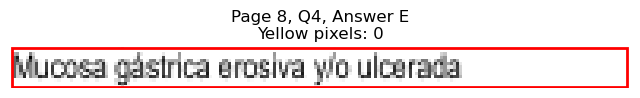


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=122.3, y1=446.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 192
Page 8, Q5, A: Yellow percentage: 0.0%


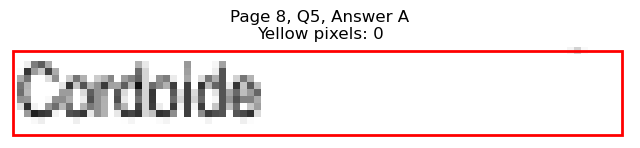

Page 8, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=114.1, y1=458.7
Page 8, Q5, B: Yellow pixels: 921
Page 8, Q5, B: Total non-white pixels: 1053
Page 8, Q5, B: Yellow percentage: 87.5%


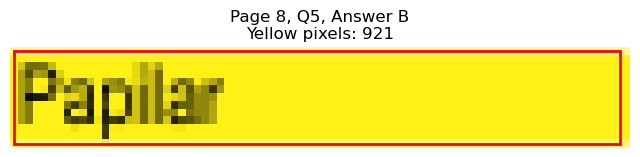

Page 8, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=141.5, y1=470.7
Page 8, Q5, C: Yellow pixels: 108
Page 8, Q5, C: Total non-white pixels: 404
Page 8, Q5, C: Yellow percentage: 26.7%


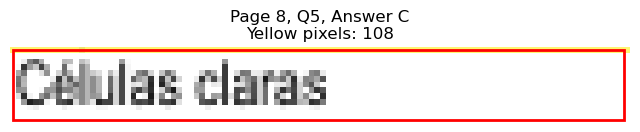

Page 8, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=394.2, y1=446.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 279
Page 8, Q5, D: Yellow percentage: 0.0%


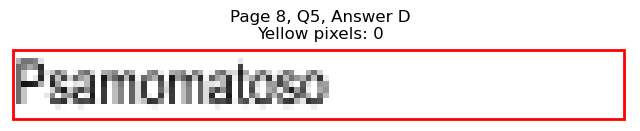

Page 8, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=389.8, y1=458.7
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 277
Page 8, Q5, E: Yellow percentage: 0.0%


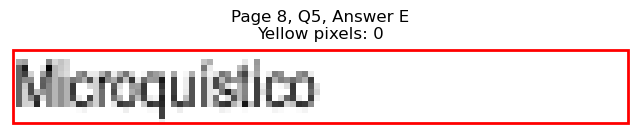


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=494.7, x1=111.3, y1=506.8
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 148
Page 8, Q6, A: Yellow percentage: 0.0%


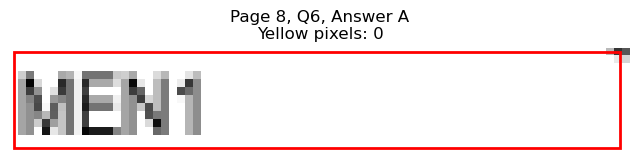

Page 8, Q6 - B: Detected box: x0=85.0, y0=506.8, x1=110.3, y1=518.9
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 198
Page 8, Q6, B: Yellow percentage: 0.0%


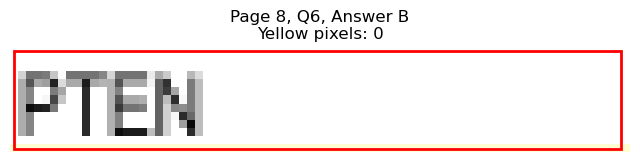

Page 8, Q6 - C: Detected box: x0=85.0, y0=518.8, x1=118.0, y1=530.9
Page 8, Q6, C: Yellow pixels: 858
Page 8, Q6, C: Total non-white pixels: 1092
Page 8, Q6, C: Yellow percentage: 78.6%


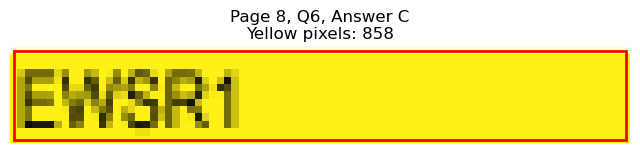

Page 8, Q6 - D: Detected box: x0=336.7, y0=494.7, x1=356.2, y1=506.8
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 92
Page 8, Q6, D: Yellow percentage: 0.0%


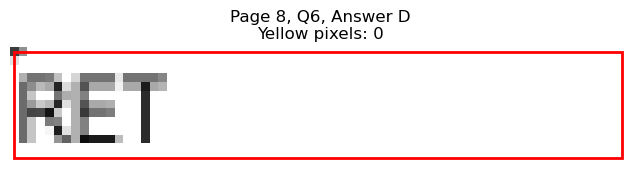

Page 8, Q6 - E: Detected box: x0=336.7, y0=506.8, x1=355.4, y1=518.9
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 76
Page 8, Q6, E: Yellow percentage: 0.0%


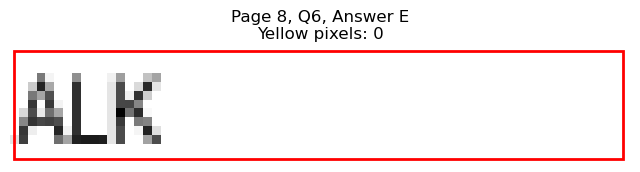


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=115.6, y1=567.0
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 158
Page 8, Q7, A: Yellow percentage: 0.0%


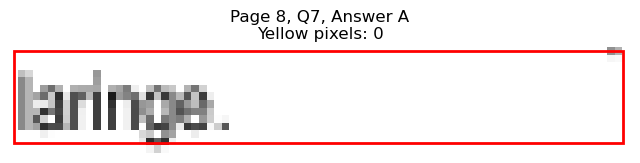

Page 8, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=134.8, y1=579.2
Page 8, Q7, B: Yellow pixels: 101
Page 8, Q7, B: Total non-white pixels: 365
Page 8, Q7, B: Yellow percentage: 27.7%


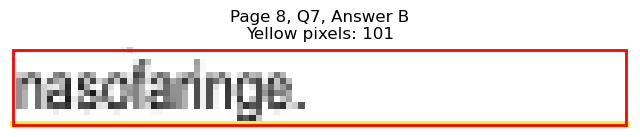

Page 8, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=118.0, y1=591.2
Page 8, Q7, C: Yellow pixels: 895
Page 8, Q7, C: Total non-white pixels: 1092
Page 8, Q7, C: Yellow percentage: 82.0%


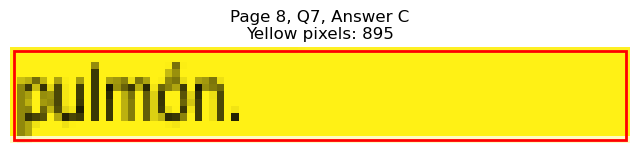

Page 8, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=379.3, y1=567.0
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 218
Page 8, Q7, D: Yellow percentage: 0.0%


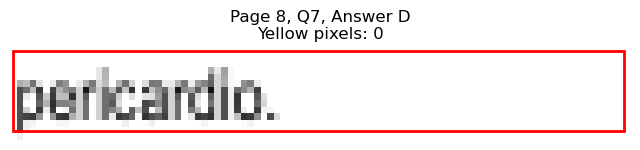

Page 8, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=400.4, y1=579.2
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 325
Page 8, Q7, E: Yellow percentage: 0.0%


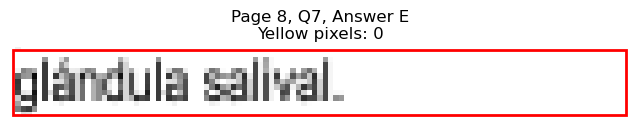


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=615.2, x1=124.2, y1=627.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 207
Page 8, Q8, A: Yellow percentage: 0.0%


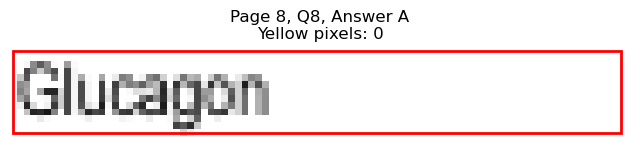

Page 8, Q8 - B: Detected box: x0=85.0, y0=627.3, x1=125.7, y1=639.4
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 208
Page 8, Q8, B: Yellow percentage: 0.0%


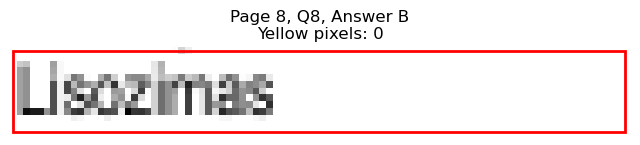

Page 8, Q8 - C: Detected box: x0=85.0, y0=639.3, x1=171.6, y1=651.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 454
Page 8, Q8, C: Yellow percentage: 0.0%


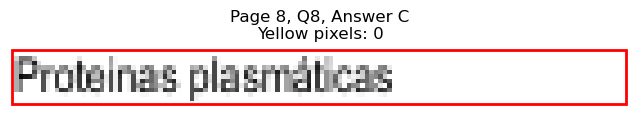

Page 8, Q8 - D: Detected box: x0=336.7, y0=615.2, x1=377.8, y1=627.3
Page 8, Q8, D: Yellow pixels: 933
Page 8, Q8, D: Total non-white pixels: 1196
Page 8, Q8, D: Yellow percentage: 78.0%


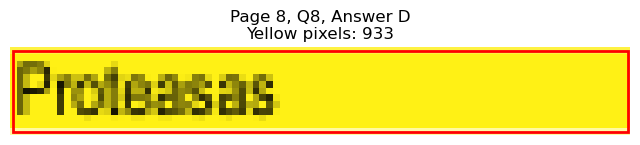

Page 8, Q8 - E: Detected box: x0=336.7, y0=627.3, x1=368.7, y1=639.4
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 249
Page 8, Q8, E: Yellow percentage: 0.0%


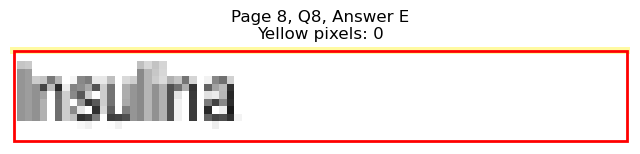


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=85.0, y0=711.7, x1=148.2, y1=723.8
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 324
Page 8, Q9, A: Yellow percentage: 0.0%


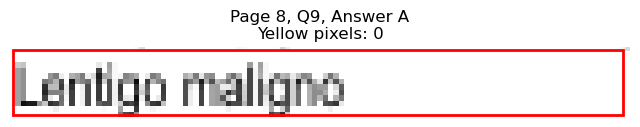

Page 8, Q9 - B: Detected box: x0=85.0, y0=723.7, x1=130.0, y1=735.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 233
Page 8, Q9, B: Yellow percentage: 0.0%


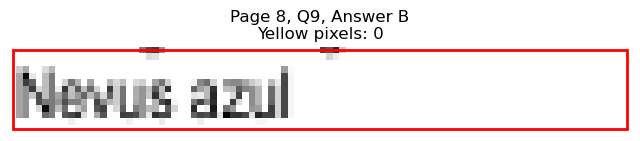

Page 8, Q9 - C: Detected box: x0=85.0, y0=735.8, x1=151.9, y1=747.9
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 350
Page 8, Q9, C: Yellow percentage: 0.0%


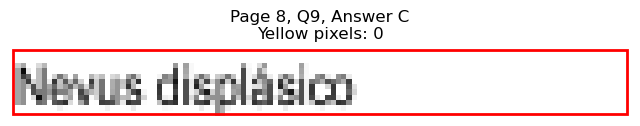

Page 8, Q9 - D: Detected box: x0=336.7, y0=711.7, x1=411.8, y1=723.8
Page 8, Q9, D: Yellow pixels: 1192
Page 8, Q9, D: Total non-white pixels: 1638
Page 8, Q9, D: Yellow percentage: 72.8%


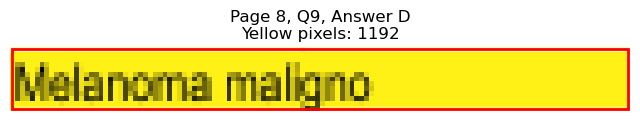

Page 8, Q9 - E: Detected box: x0=336.7, y0=723.7, x1=407.0, y1=735.8
Page 8, Q9, E: Yellow pixels: 117
Page 8, Q9, E: Total non-white pixels: 494
Page 8, Q9, E: Yellow percentage: 23.7%


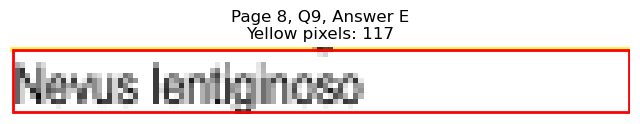


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=152.5, y1=109.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 323
Page 9, Q1, A: Yellow percentage: 0.0%


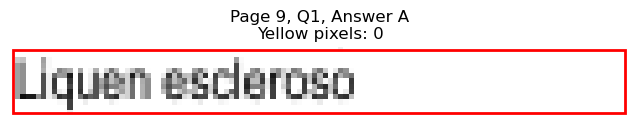

Page 9, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=172.1, y1=121.3
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 463
Page 9, Q1, B: Yellow percentage: 0.0%


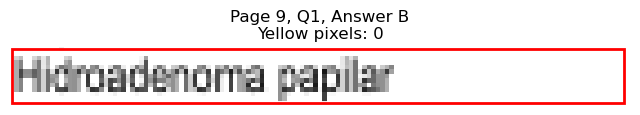

Page 9, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=158.7, y1=133.3
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 354
Page 9, Q1, C: Yellow percentage: 0.0%


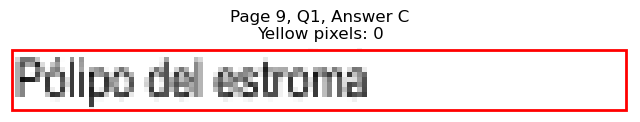

Page 9, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=423.3, y1=109.2
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 454
Page 9, Q1, D: Yellow percentage: 0.0%


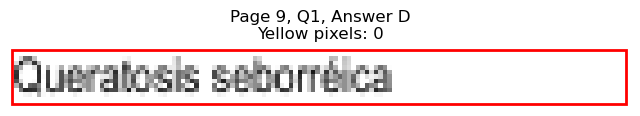

Page 9, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=423.8, y1=121.3
Page 9, Q1, E: Yellow pixels: 1275
Page 9, Q1, E: Total non-white pixels: 1794
Page 9, Q1, E: Yellow percentage: 71.1%


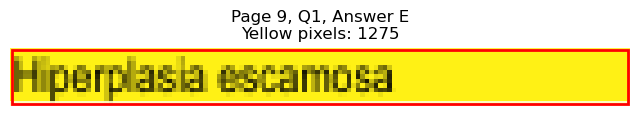


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=157.3, x1=109.0, y1=169.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 118
Page 9, Q2, A: Yellow percentage: 0.0%


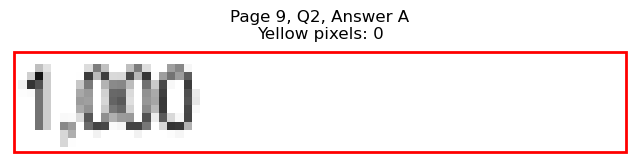

Page 9, Q2 - B: Detected box: x0=85.0, y0=169.4, x1=109.0, y1=181.5
Page 9, Q2, B: Yellow pixels: 877
Page 9, Q2, B: Total non-white pixels: 975
Page 9, Q2, B: Yellow percentage: 89.9%


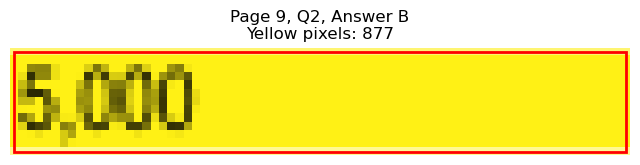

Page 9, Q2 - C: Detected box: x0=85.0, y0=181.4, x1=109.0, y1=193.5
Page 9, Q2, C: Yellow pixels: 75
Page 9, Q2, C: Total non-white pixels: 199
Page 9, Q2, C: Yellow percentage: 37.7%


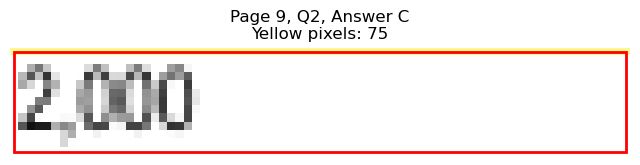

Page 9, Q2 - D: Detected box: x0=336.7, y0=157.3, x1=360.7, y1=169.4
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 116
Page 9, Q2, D: Yellow percentage: 0.0%


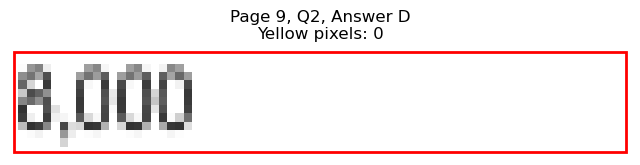

Page 9, Q2 - E: Detected box: x0=336.7, y0=169.4, x1=365.4, y1=181.5
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 125
Page 9, Q2, E: Yellow percentage: 0.0%


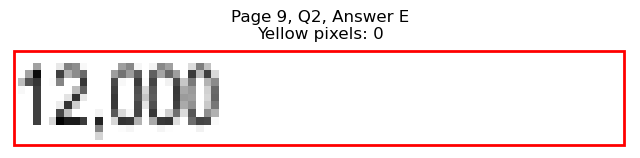


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=163.9, y1=253.8
Page 9, Q3, A: Yellow pixels: 1221
Page 9, Q3, A: Total non-white pixels: 1690
Page 9, Q3, A: Yellow percentage: 72.2%


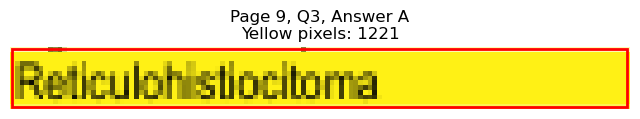

Page 9, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=150.6, y1=265.8
Page 9, Q3, B: Yellow pixels: 117
Page 9, Q3, B: Total non-white pixels: 446
Page 9, Q3, B: Yellow percentage: 26.2%


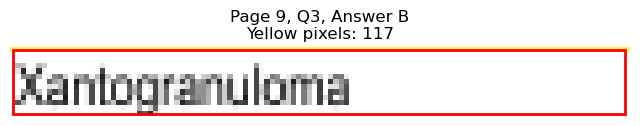

Page 9, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=149.5, y1=277.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 342
Page 9, Q3, C: Yellow percentage: 0.0%


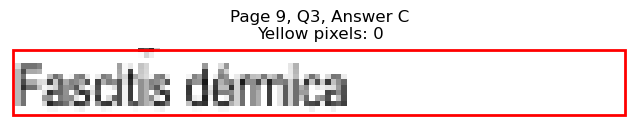

Page 9, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=419.5, y1=253.8
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 426
Page 9, Q3, D: Yellow percentage: 0.0%


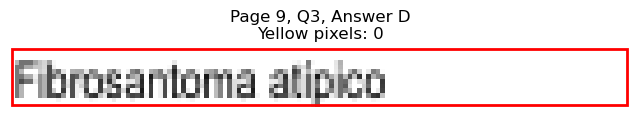

Page 9, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=473.1, y1=265.8
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 697
Page 9, Q3, E: Yellow percentage: 0.0%


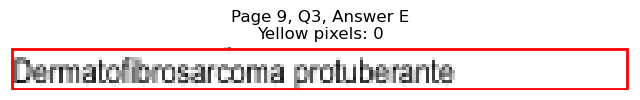


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=156.3, y1=314.0
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 338
Page 9, Q4, A: Yellow percentage: 0.0%


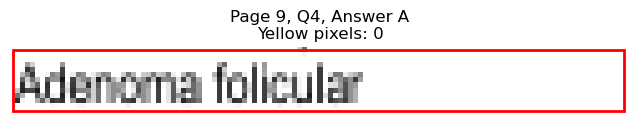

Page 9, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=168.3, y1=326.0
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 417
Page 9, Q4, B: Yellow percentage: 0.0%


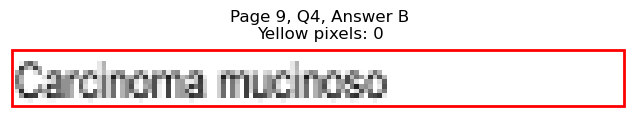

Page 9, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=216.2, y1=338.2
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 667
Page 9, Q4, C: Yellow percentage: 0.0%


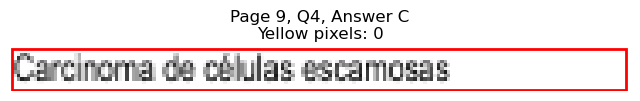

Page 9, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=401.7, y1=314.0
Page 9, Q4, D: Yellow pixels: 116
Page 9, Q4, D: Total non-white pixels: 550
Page 9, Q4, D: Yellow percentage: 21.1%


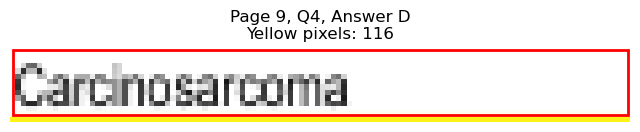

Page 9, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=414.2, y1=326.0
Page 9, Q4, E: Yellow pixels: 1243
Page 9, Q4, E: Total non-white pixels: 1806
Page 9, Q4, E: Yellow percentage: 68.8%


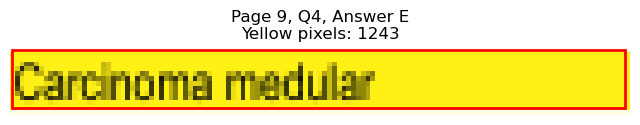


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=70.8, y0=362.2, x1=79.0, y1=374.3
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 63
Page 9, Q5, A: Yellow percentage: 0.0%


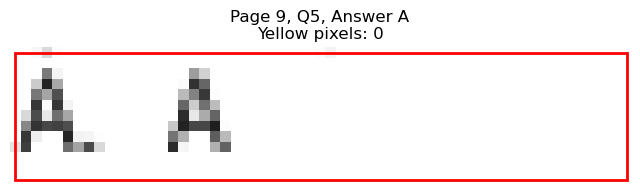

Page 9, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=98.9, y1=386.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 64
Page 9, Q5, B: Yellow percentage: 0.0%


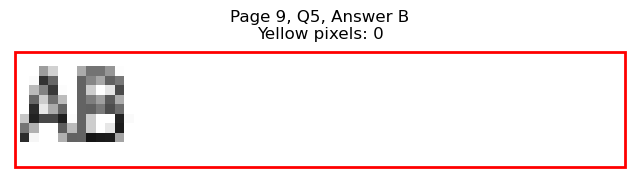

Page 9, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=98.0, y1=398.4
Page 9, Q5, C: Yellow pixels: 722
Page 9, Q5, C: Total non-white pixels: 832
Page 9, Q5, C: Yellow percentage: 86.8%


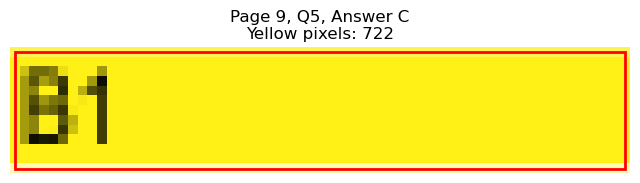

Page 9, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=349.6, y1=374.3
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 63
Page 9, Q5, D: Yellow percentage: 0.0%


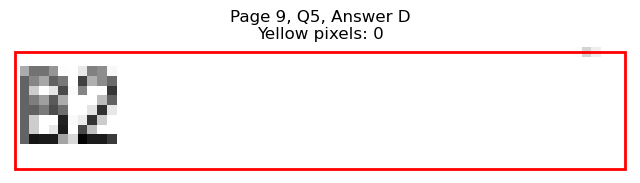

Page 9, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=349.6, y1=386.3
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 64
Page 9, Q5, E: Yellow percentage: 0.0%


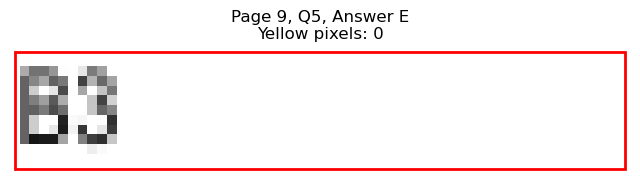


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=285.1, y1=470.7
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 996
Page 9, Q6, A: Yellow percentage: 0.0%


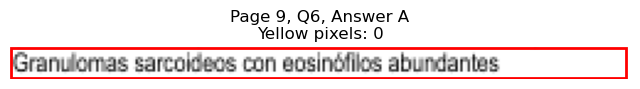

Page 9, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=328.6, y1=482.8
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 1248
Page 9, Q6, B: Yellow percentage: 0.0%


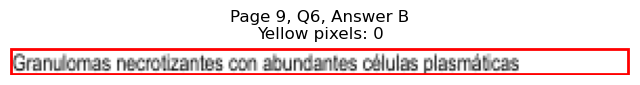

Page 9, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=298.5, y1=494.8
Page 9, Q6, C: Yellow pixels: 1
Page 9, Q6, C: Total non-white pixels: 1359
Page 9, Q6, C: Yellow percentage: 0.1%


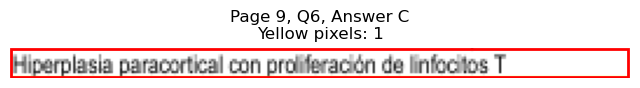

Page 9, Q6 - D: Detected box: x0=85.0, y0=494.7, x1=236.7, y1=506.8
Page 9, Q6, D: Yellow pixels: 1825
Page 9, Q6, D: Total non-white pixels: 2639
Page 9, Q6, D: Yellow percentage: 69.2%


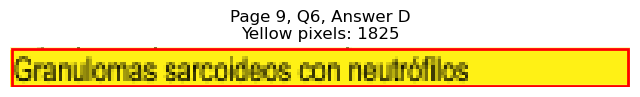

Page 9, Q6 - E: Detected box: x0=85.0, y0=506.8, x1=287.5, y1=518.9
Page 9, Q6, E: Yellow pixels: 254
Page 9, Q6, E: Total non-white pixels: 1233
Page 9, Q6, E: Yellow percentage: 20.6%


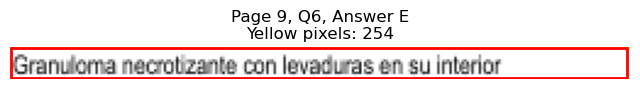


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=128.5, y1=555.0
Page 9, Q7, A: Yellow pixels: 952
Page 9, Q7, A: Total non-white pixels: 1235
Page 9, Q7, A: Yellow percentage: 77.1%


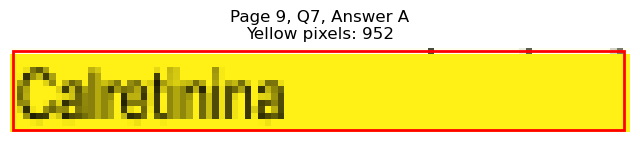

Page 9, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=109.3, y1=567.0
Page 9, Q7, B: Yellow pixels: 76
Page 9, Q7, B: Total non-white pixels: 204
Page 9, Q7, B: Yellow percentage: 37.3%


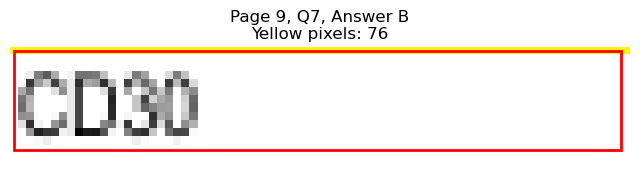

Page 9, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=109.3, y1=579.2
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 116
Page 9, Q7, C: Yellow percentage: 0.0%


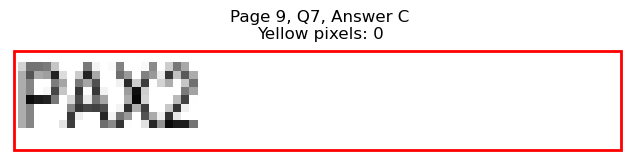

Page 9, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=361.0, y1=555.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 124
Page 9, Q7, D: Yellow percentage: 0.0%


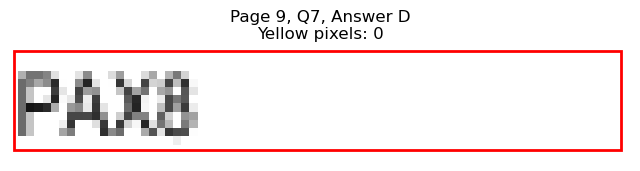

Page 9, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=366.8, y1=567.0
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 135
Page 9, Q7, E: Yellow percentage: 0.0%


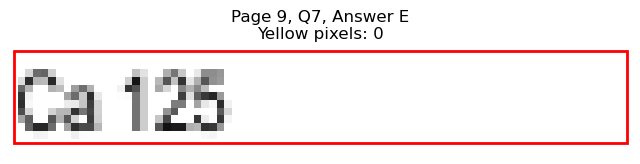


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=225.8, y1=615.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 724
Page 9, Q8, A: Yellow percentage: 0.0%


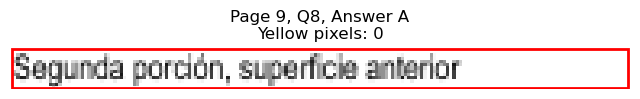

Page 9, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=225.8, y1=627.3
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 711
Page 9, Q8, B: Yellow percentage: 0.0%


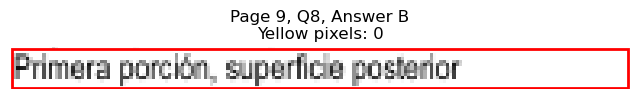

Page 9, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=230.0, y1=639.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 763
Page 9, Q8, C: Yellow percentage: 0.0%


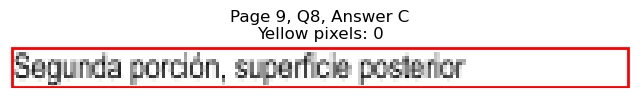

Page 9, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=473.1, y1=615.3
Page 9, Q8, D: Yellow pixels: 1687
Page 9, Q8, D: Total non-white pixels: 2444
Page 9, Q8, D: Yellow percentage: 69.0%


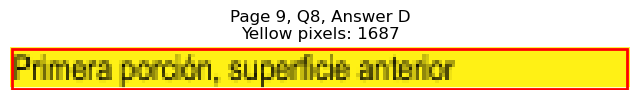

Page 9, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=472.7, y1=627.3
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 848
Page 9, Q8, E: Yellow percentage: 0.0%


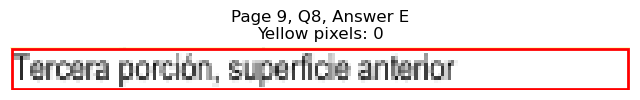


Page 9, Q8 - Selected Answer: D (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=108.0, y1=675.5
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 112
Page 9, Q9, A: Yellow percentage: 0.0%


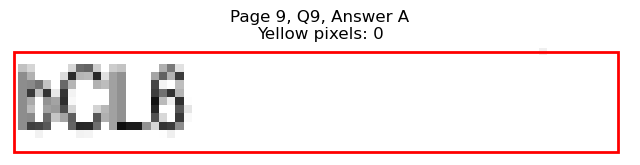

Page 9, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=109.3, y1=687.5
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 117
Page 9, Q9, B: Yellow percentage: 0.0%


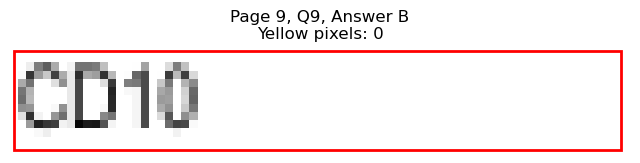

Page 9, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=104.7, y1=699.7
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 100
Page 9, Q9, C: Yellow percentage: 0.0%


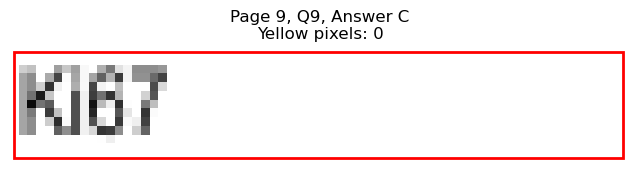

Page 9, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=361.0, y1=675.5
Page 9, Q9, D: Yellow pixels: 76
Page 9, Q9, D: Total non-white pixels: 197
Page 9, Q9, D: Yellow percentage: 38.6%


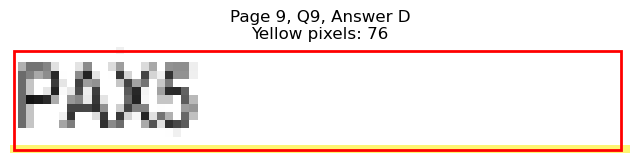

Page 9, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=360.6, y1=687.5
Page 9, Q9, E: Yellow pixels: 884
Page 9, Q9, E: Total non-white pixels: 975
Page 9, Q9, E: Yellow percentage: 90.7%


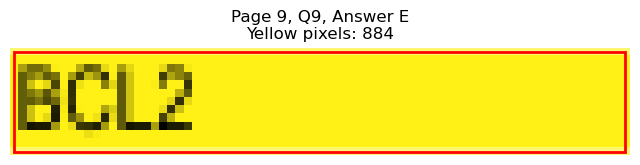


Page 9, Q9 - Selected Answer: E (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=118.9, y1=735.8
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 162
Page 9, Q10, A: Yellow percentage: 0.0%


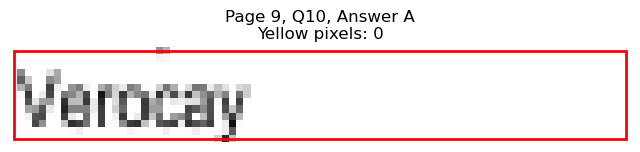

Page 9, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=143.9, y1=747.9
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 300
Page 9, Q10, B: Yellow percentage: 0.0%


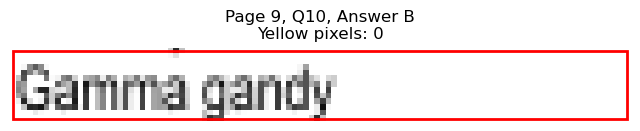

Page 9, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=114.7, y1=759.9
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 163
Page 9, Q10, C: Yellow percentage: 0.0%


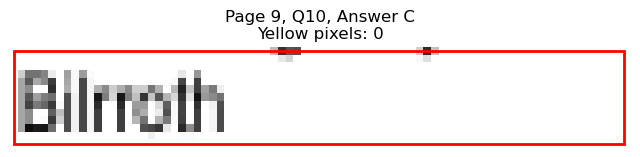

Page 9, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=358.6, y1=735.8
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 119
Page 9, Q10, D: Yellow percentage: 0.0%


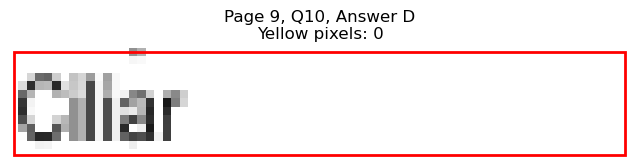

Page 9, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=369.2, y1=747.9
Page 9, Q10, E: Yellow pixels: 868
Page 9, Q10, E: Total non-white pixels: 1092
Page 9, Q10, E: Yellow percentage: 79.5%


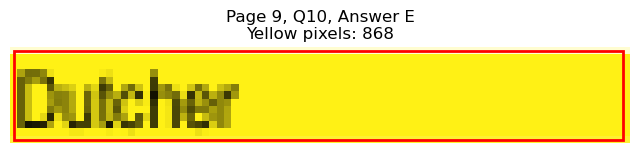


Page 9, Q10 - Selected Answer: E (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=85.0, y0=109.2, x1=116.5, y1=121.3
Page 10, Q1, A: Yellow pixels: 875
Page 10, Q1, A: Total non-white pixels: 1079
Page 10, Q1, A: Yellow percentage: 81.1%


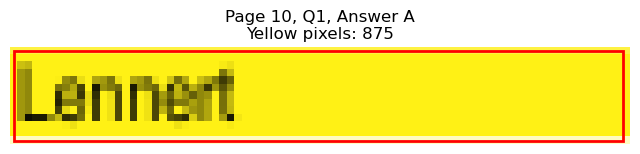

Page 10, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=182.7, y1=133.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 650
Page 10, Q1, B: Yellow percentage: 0.0%


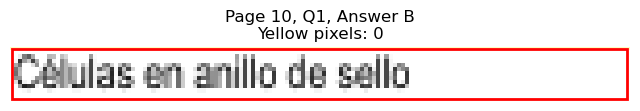

Page 10, Q1 - C: Detected box: x0=85.0, y0=133.2, x1=119.9, y1=145.3
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 188
Page 10, Q1, C: Yellow percentage: 0.0%


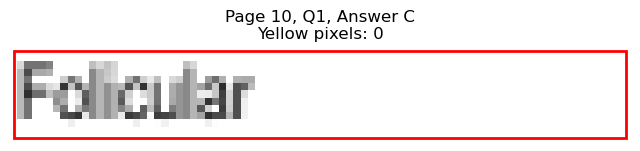

Page 10, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=410.4, y1=121.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 385
Page 10, Q1, D: Yellow percentage: 0.0%


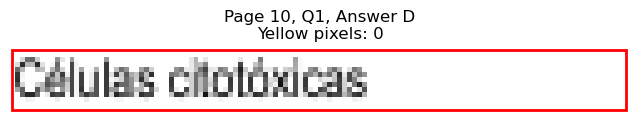

Page 10, Q1 - E: Detected box: x0=336.7, y0=121.2, x1=389.8, y1=133.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 302
Page 10, Q1, E: Yellow percentage: 0.0%


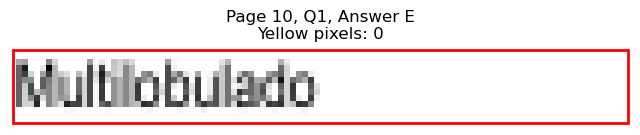


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=115.1, y1=193.5
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 156
Page 10, Q2, A: Yellow percentage: 0.0%


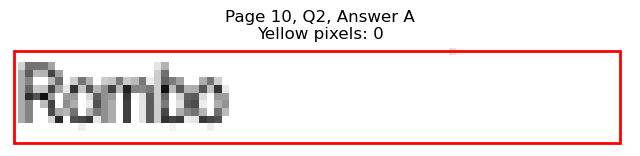

Page 10, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=127.6, y1=205.5
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 201
Page 10, Q2, B: Yellow percentage: 0.0%


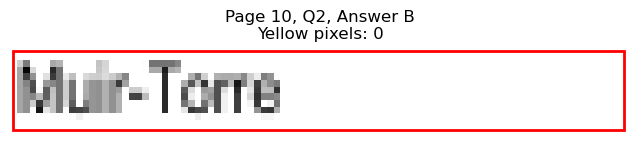

Page 10, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=149.1, y1=217.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 352
Page 10, Q2, C: Yellow percentage: 0.0%


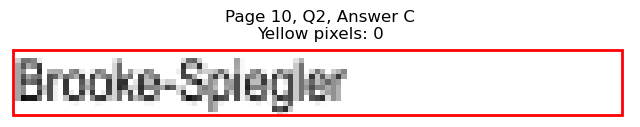

Page 10, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=366.8, y1=193.5
Page 10, Q2, D: Yellow pixels: 920
Page 10, Q2, D: Total non-white pixels: 1053
Page 10, Q2, D: Yellow percentage: 87.4%


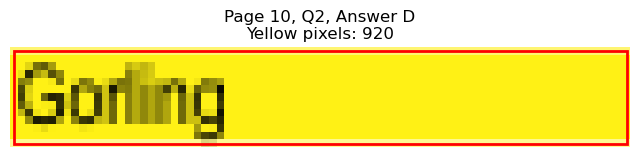

Page 10, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=363.0, y1=205.5
Page 10, Q2, E: Yellow pixels: 77
Page 10, Q2, E: Total non-white pixels: 209
Page 10, Q2, E: Yellow percentage: 36.8%


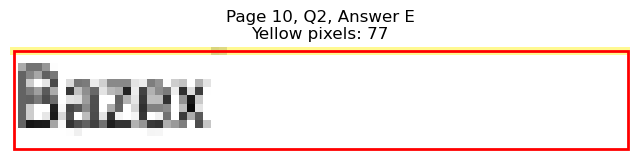


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=125.2, y1=253.8
Page 10, Q3, A: Yellow pixels: 919
Page 10, Q3, A: Total non-white pixels: 1196
Page 10, Q3, A: Yellow percentage: 76.8%


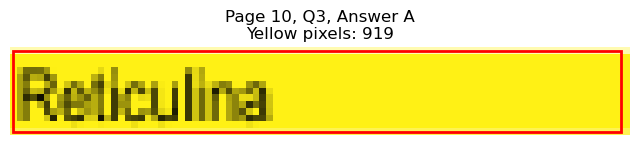

Page 10, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=104.7, y1=265.8
Page 10, Q3, B: Yellow pixels: 71
Page 10, Q3, B: Total non-white pixels: 165
Page 10, Q3, B: Yellow percentage: 43.0%


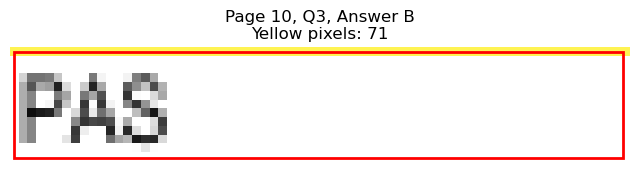

Page 10, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=127.6, y1=277.9
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 216
Page 10, Q3, C: Yellow percentage: 0.0%


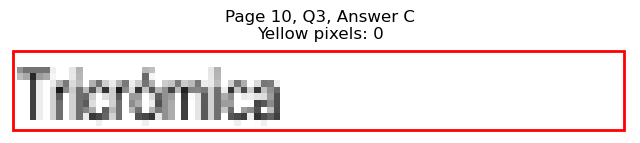

Page 10, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=369.7, y1=253.8
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 160
Page 10, Q3, D: Yellow percentage: 0.0%


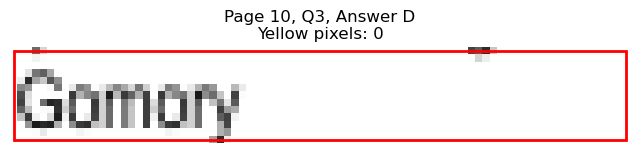

Page 10, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=415.6, y1=265.8
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 388
Page 10, Q3, E: Yellow percentage: 0.0%


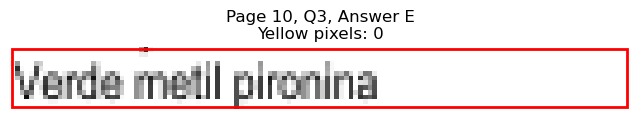


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=301.9, x1=156.4, y1=314.0
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 370
Page 10, Q4, A: Yellow percentage: 0.0%


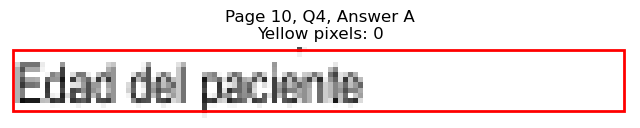

Page 10, Q4 - B: Detected box: x0=85.0, y0=313.9, x1=195.5, y1=326.0
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 529
Page 10, Q4, B: Yellow percentage: 0.0%


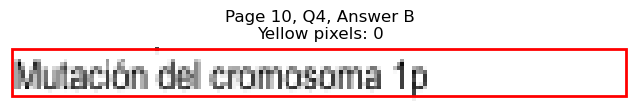

Page 10, Q4 - C: Detected box: x0=85.0, y0=326.1, x1=158.3, y1=338.2
Page 10, Q4, C: Yellow pixels: 1186
Page 10, Q4, C: Total non-white pixels: 1625
Page 10, Q4, C: Yellow percentage: 73.0%


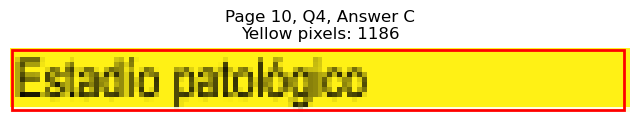

Page 10, Q4 - D: Detected box: x0=336.7, y0=301.9, x1=424.8, y1=314.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 412
Page 10, Q4, D: Yellow percentage: 0.0%


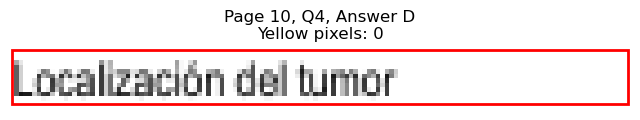

Page 10, Q4 - E: Detected box: x0=336.7, y0=313.9, x1=394.2, y1=326.0
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 331
Page 10, Q4, E: Yellow percentage: 0.0%


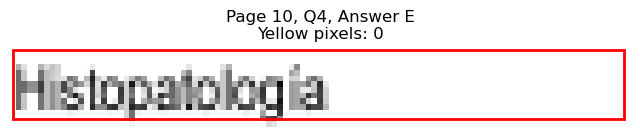


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=362.2, x1=146.8, y1=374.3
Page 10, Q5, A: Yellow pixels: 113
Page 10, Q5, A: Total non-white pixels: 420
Page 10, Q5, A: Yellow percentage: 26.9%


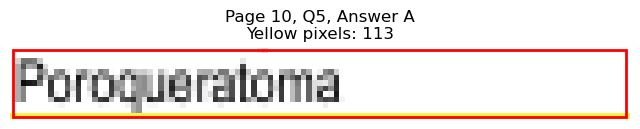

Page 10, Q5 - B: Detected box: x0=85.0, y0=374.2, x1=168.7, y1=386.3
Page 10, Q5, B: Yellow pixels: 1267
Page 10, Q5, B: Total non-white pixels: 1755
Page 10, Q5, B: Yellow percentage: 72.2%


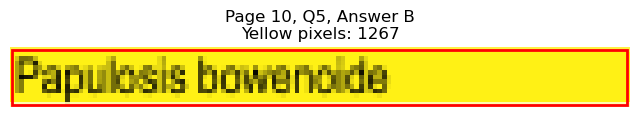

Page 10, Q5 - C: Detected box: x0=85.0, y0=386.3, x1=181.7, y1=398.4
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 640
Page 10, Q5, C: Yellow percentage: 0.0%


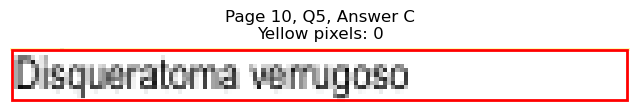

Page 10, Q5 - D: Detected box: x0=336.7, y0=362.2, x1=412.8, y1=374.3
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 407
Page 10, Q5, D: Yellow percentage: 0.0%


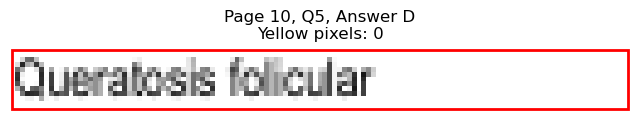

Page 10, Q5 - E: Detected box: x0=336.7, y0=374.2, x1=415.2, y1=386.3
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 412
Page 10, Q5, E: Yellow percentage: 0.0%


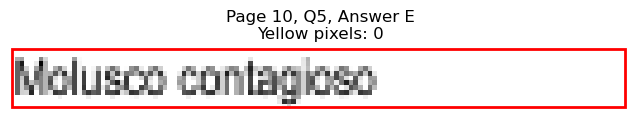


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=446.6, x1=177.4, y1=458.7
Page 10, Q6, A: Yellow pixels: 144
Page 10, Q6, A: Total non-white pixels: 662
Page 10, Q6, A: Yellow percentage: 21.8%


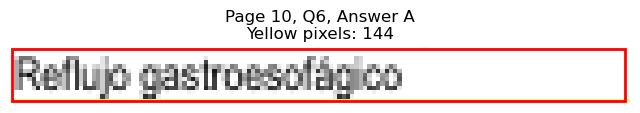

Page 10, Q6 - B: Detected box: x0=85.0, y0=458.6, x1=159.1, y1=470.7
Page 10, Q6, B: Yellow pixels: 1315
Page 10, Q6, B: Total non-white pixels: 1638
Page 10, Q6, B: Yellow percentage: 80.3%


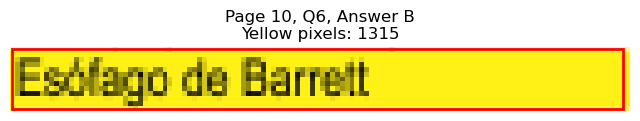

Page 10, Q6 - C: Detected box: x0=85.0, y0=470.7, x1=153.9, y1=482.8
Page 10, Q6, C: Yellow pixels: 120
Page 10, Q6, C: Total non-white pixels: 454
Page 10, Q6, C: Yellow percentage: 26.4%


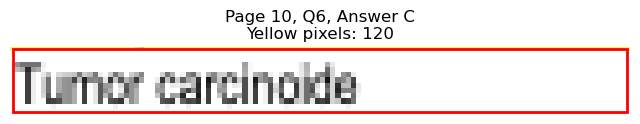

Page 10, Q6 - D: Detected box: x0=336.7, y0=446.6, x1=386.5, y1=458.7
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 241
Page 10, Q6, D: Yellow percentage: 0.0%


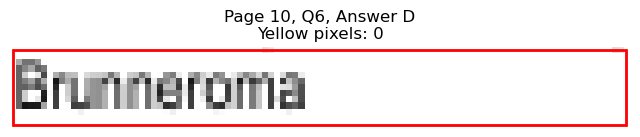

Page 10, Q6 - E: Detected box: x0=336.7, y0=458.6, x1=443.0, y1=470.7
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 517
Page 10, Q6, E: Yellow percentage: 0.0%


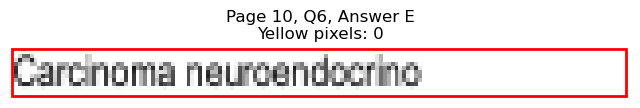


Page 10, Q6 - Selected Answer: B (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=506.8, x1=121.3, y1=518.9
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 199
Page 10, Q7, A: Yellow percentage: 0.0%


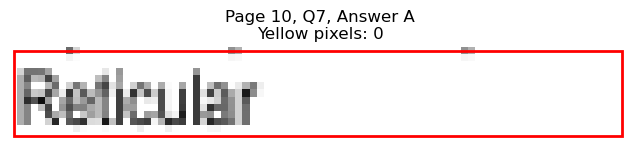

Page 10, Q7 - B: Detected box: x0=85.0, y0=518.8, x1=109.0, y1=530.9
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 128
Page 10, Q7, B: Yellow percentage: 0.0%


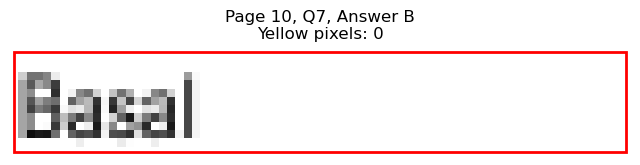

Page 10, Q7 - C: Detected box: x0=85.0, y0=530.9, x1=165.9, y1=543.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 431
Page 10, Q7, C: Yellow percentage: 0.0%


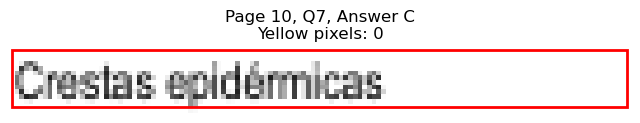

Page 10, Q7 - D: Detected box: x0=336.7, y0=506.8, x1=382.6, y1=518.9
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 338
Page 10, Q7, D: Yellow percentage: 0.0%


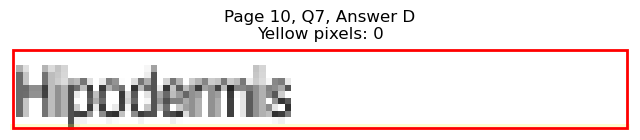

Page 10, Q7 - E: Detected box: x0=336.7, y0=518.8, x1=365.8, y1=530.9
Page 10, Q7, E: Yellow pixels: 826
Page 10, Q7, E: Total non-white pixels: 1040
Page 10, Q7, E: Yellow percentage: 79.4%


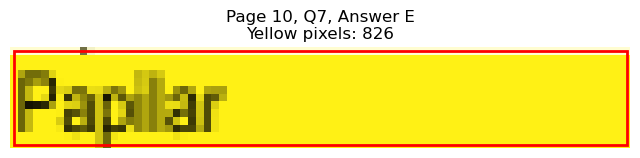


Page 10, Q7 - Selected Answer: E (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=567.1, x1=104.2, y1=579.2
Page 10, Q8, A: Yellow pixels: 788
Page 10, Q8, A: Total non-white pixels: 923
Page 10, Q8, A: Yellow percentage: 85.4%


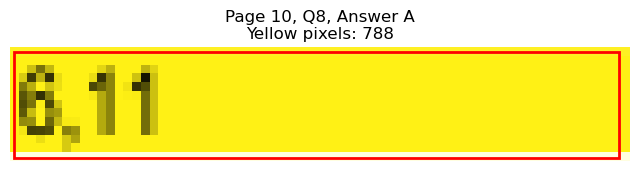

Page 10, Q8 - B: Detected box: x0=85.0, y0=579.1, x1=109.0, y1=591.2
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 179
Page 10, Q8, B: Yellow percentage: 0.0%


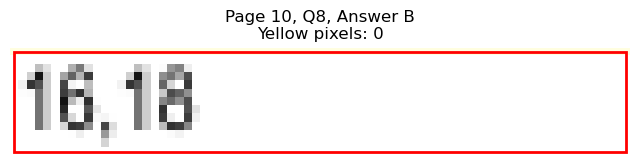

Page 10, Q8 - C: Detected box: x0=85.0, y0=591.2, x1=109.0, y1=603.3
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 107
Page 10, Q8, C: Yellow percentage: 0.0%


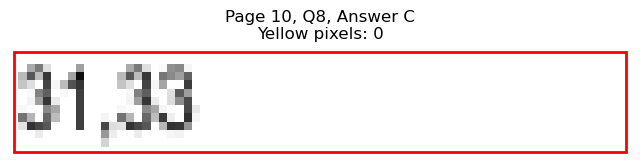

Page 10, Q8 - D: Detected box: x0=336.7, y0=567.1, x1=360.7, y1=579.2
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 115
Page 10, Q8, D: Yellow percentage: 0.0%


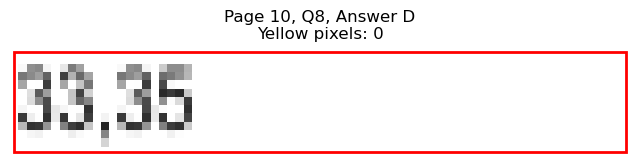

Page 10, Q8 - E: Detected box: x0=336.7, y0=579.1, x1=360.7, y1=591.2
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 95
Page 10, Q8, E: Yellow percentage: 0.0%


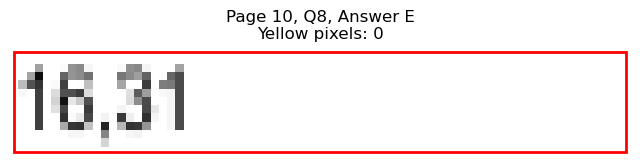


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=639.3, x1=128.5, y1=651.4
Page 10, Q9, A: Yellow pixels: 1047
Page 10, Q9, A: Total non-white pixels: 1235
Page 10, Q9, A: Yellow percentage: 84.8%


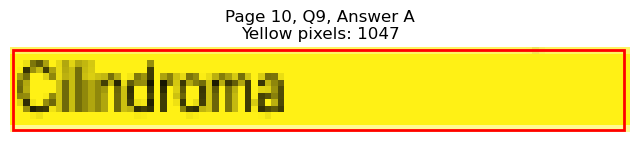

Page 10, Q9 - B: Detected box: x0=85.0, y0=651.4, x1=147.7, y1=663.5
Page 10, Q9, B: Yellow pixels: 114
Page 10, Q9, B: Total non-white pixels: 443
Page 10, Q9, B: Yellow percentage: 25.7%


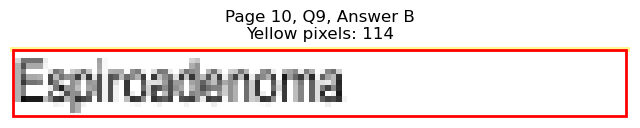

Page 10, Q9 - C: Detected box: x0=85.0, y0=663.4, x1=126.1, y1=675.5
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 221
Page 10, Q9, C: Yellow percentage: 0.0%


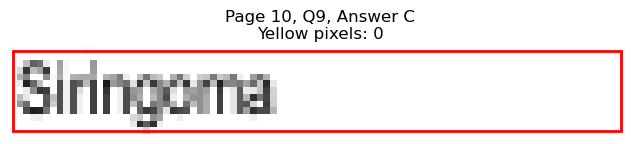

Page 10, Q9 - D: Detected box: x0=336.7, y0=639.3, x1=387.4, y1=651.4
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 244
Page 10, Q9, D: Yellow percentage: 0.0%


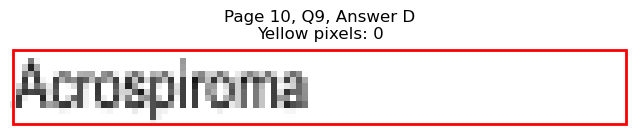

Page 10, Q9 - E: Detected box: x0=336.7, y0=651.4, x1=387.0, y1=663.5
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 224
Page 10, Q9, E: Yellow percentage: 0.0%


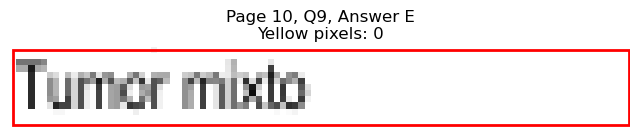


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=85.0, y0=711.7, x1=128.1, y1=723.8
Page 10, Q10, A: Yellow pixels: 945
Page 10, Q10, A: Total non-white pixels: 1235
Page 10, Q10, A: Yellow percentage: 76.5%


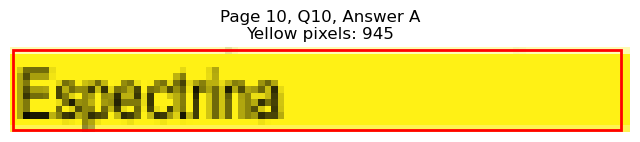

Page 10, Q10 - B: Detected box: x0=85.0, y0=723.7, x1=128.5, y1=735.8
Page 10, Q10, B: Yellow pixels: 93
Page 10, Q10, B: Total non-white pixels: 304
Page 10, Q10, B: Yellow percentage: 30.6%


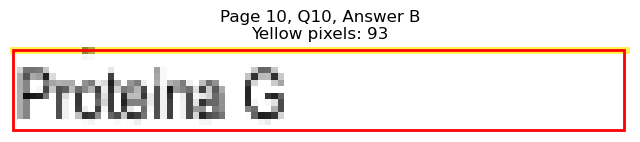

Page 10, Q10 - C: Detected box: x0=85.0, y0=735.8, x1=138.1, y1=747.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 288
Page 10, Q10, C: Yellow percentage: 0.0%


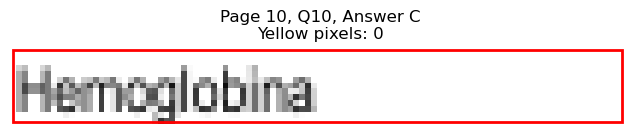

Page 10, Q10 - D: Detected box: x0=336.7, y0=711.7, x1=375.4, y1=723.8
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 203
Page 10, Q10, D: Yellow percentage: 0.0%


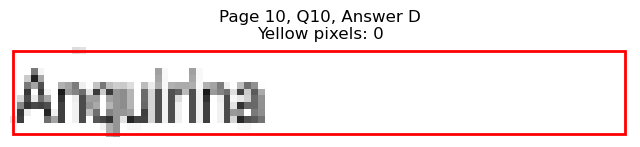

Page 10, Q10 - E: Detected box: x0=336.7, y0=723.7, x1=394.3, y1=735.8
Page 10, Q10, E: Yellow pixels: 0
Page 10, Q10, E: Total non-white pixels: 309
Page 10, Q10, E: Yellow percentage: 0.0%


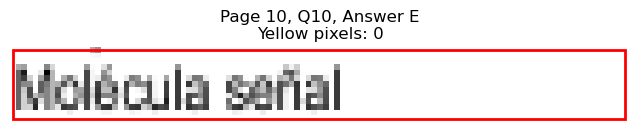


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)





Page 11: Found 2 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=125.2, y1=133.3
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 220
Page 11, Q1, A: Yellow percentage: 0.0%


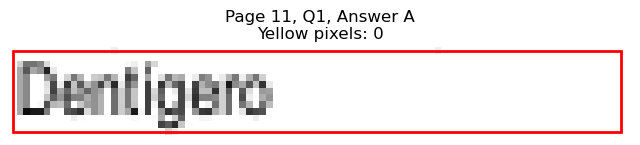

Page 11, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=141.0, y1=145.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 304
Page 11, Q1, B: Yellow percentage: 0.0%


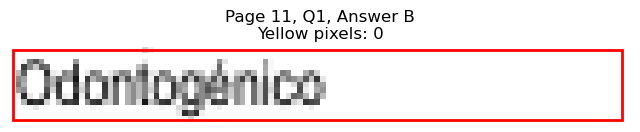

Page 11, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=158.3, y1=157.4
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 392
Page 11, Q1, C: Yellow percentage: 0.0%


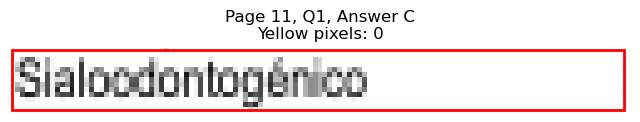

Page 11, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=375.4, y1=133.3
Page 11, Q1, D: Yellow pixels: 926
Page 11, Q1, D: Total non-white pixels: 1170
Page 11, Q1, D: Yellow percentage: 79.1%


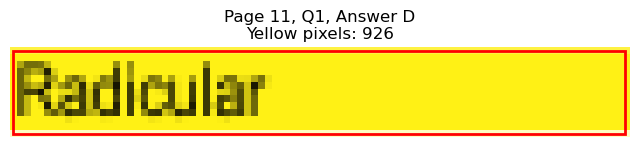

Page 11, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=428.1, y1=145.3
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 621
Page 11, Q1, E: Yellow percentage: 0.0%


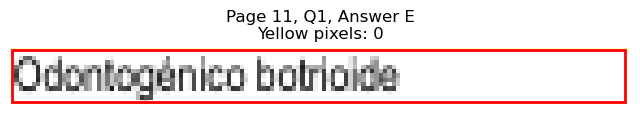


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=136.2, y1=217.7
Page 11, Q2, A: Yellow pixels: 1106
Page 11, Q2, A: Total non-white pixels: 1339
Page 11, Q2, A: Yellow percentage: 82.6%


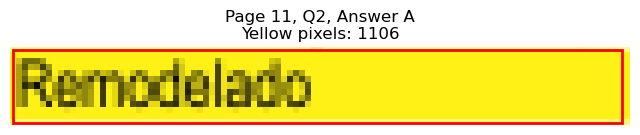

Page 11, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=159.6, y1=229.7
Page 11, Q2, B: Yellow pixels: 126
Page 11, Q2, B: Total non-white pixels: 502
Page 11, Q2, B: Yellow percentage: 25.1%


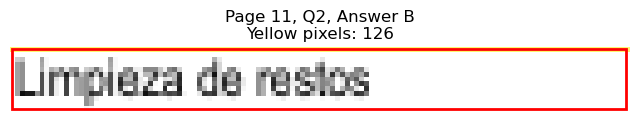

Page 11, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=205.1, y1=241.8
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 626
Page 11, Q2, C: Yellow percentage: 0.0%


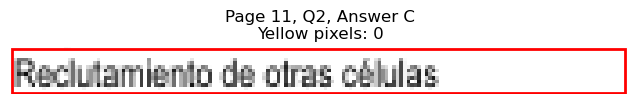

Page 11, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=491.3, y1=217.7
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 773
Page 11, Q2, D: Yellow percentage: 0.0%


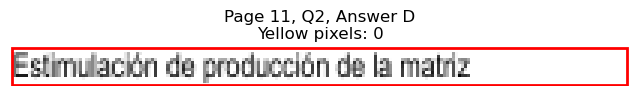

Page 11, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=401.4, y1=229.7
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 353
Page 11, Q2, E: Yellow percentage: 0.0%


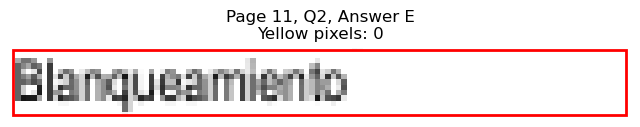


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el tumor de la glándula pituitaria po...
1   Varón con lesión elevada en colon distal, infi...
2   Paciente encontrado fallecido por infarto mioc...
3   La diseminación temprana del adenocarcinoma de...
4   Paciente de 5 años con tumor cerebral, localiz...
..                                                ...
95  ¿Cuáles son las cepas del PVH que se asocian a...
96  Paciente con tumor en turbante con lesiones er...
97  El examen microscópico de un frotis de sangre ...
98  Paciente con inflamación en ápice dental; dien...
99  Los macrófagos en la cicatrización de las heri...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                      option_B  \
0       Adenoma pituitario               Adenoma atípico   
1    Pólipos inflamatorios  Síndrome de Cronkhite-Canadá   
2                  Caseosa                         Grasa   
3   ganglios paraaórticos.                       pulmón.   
4                   Difuso                    Pilocítico   
..                     ...                           ...   
95                    6,11                         16,18   
96              Cilindroma                 Espiroadenoma   
97              Espectrina                    Proteina G   
98               Dentígero                  Odontogénico   
99              Remodelado            Limpieza de restos   

                            option_C                                 option_D  \
0   Oncocitoma de células fusiformes                     Carcinoma pituitario   
1                      Malacoplaquia                       Síndrome de Cowdon   
2                       Liquefactiva                              Coagulativa   
3                            pleura.                                 cerebro.   
4                         Anaplásico                                 Fibrilar   
..                               ...                                      ...   
95                             31,33                                    33,35   
96                         Siringoma                              Acrospiroma   
97                       Hemoglobina                                Anquirina   
98                 Sialoodontogénico                                Radicular   
99    Reclutamiento de otras células  Estimulación de producción de la matriz   

                     option_E  
0               Gangliocitoma  
1   Pólipo de prolapso mucoso  
2                     Química  
3     tejido retroperitoneal.  
4               Gemistocítico  
..                        ...  
95                      16,31  
96                Tumor mixto  
97             Molécula señal  
98     Odontogénico botrioide  
99             Blanqueamiento  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               E
4               B
..            ...
95              A
96              A
97              A
98              D
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions                option_A  \
0   ¿Cuál es el tumor de la glándula pituitaria po...      Adenoma pituitario   
1   Varón con lesión elevada en colon distal, infi...   Pólipos inflamatorios   
2   Paciente encontrado fallecido por infarto mioc...                 Caseosa   
3   La diseminación temprana del adenocarcinoma de...  ganglios paraaórticos.   
4   Paciente de 5 años con tumor cerebral, localiz...                  Difuso   
..                                                ...                     ...   
95  ¿Cuáles son las cepas del PVH que se asocian a...                    6,11   
96  Paciente con tumor en turbante con lesiones er...              Cilindroma   
97  El examen microscópico de un frotis de sangre ...              Espectrina   
98  Paciente con inflamación en ápice dental; dien...               Dentígero   
99  Los macrófagos en la cicatrización de las heri...              Remodelado   

                        option_B                          option_C  \
0                Adenoma atípico  Oncocitoma de células fusiformes   
1   Síndrome de Cronkhite-Canadá                     Malacoplaquia   
2                          Grasa                      Liquefactiva   
3                        pulmón.                           pleura.   
4                     Pilocítico                        Anaplásico   
..                           ...                               ...   
95                         16,18                             31,33   
96                 Espiroadenoma                         Siringoma   
97                    Proteina G                       Hemoglobina   
98                  Odontogénico                 Sialoodontogénico   
99            Limpieza de restos    Reclutamiento de otras células   

                                   option_D                   option_E  \
0                      Carcinoma pituitario              Gangliocitoma   
1                        Síndrome de Cowdon  Pólipo de prolapso mucoso   
2                               Coagulativa                    Química   
3                                  cerebro.    tejido retroperitoneal.   
4                                  Fibrilar              Gemistocítico   
..                                      ...                        ...   
95                                    33,35                      16,31   
96                              Acrospiroma                Tumor mixto   
97                                Anquirina             Molécula señal   
98                                Radicular     Odontogénico botrioide   
99  Estimulación de producción de la matriz             Blanqueamiento   

   correct_answer  
0               E  
1               C  
2               D  
3               E  
4               B  
..            ...  
95              A  
96              A  
97              A  
98              D  
99              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/ANATOMIA PATOLOGICA.csv
